In [1]:
import numpy as np
import gym
import pybulletgym
import torch
import os
from spinup.env_wrapper.pomdp_wrapper import POMDPWrapper
from spinup.algos.pytorch.lstm_td3.lstm_td3 import MLPCritic, MLPActor, MLPActorCritic
import json
import matplotlib.pyplot as plt


In [51]:
MDP_to_POMDP = {}

## MDP-> POMDP: 
### Baselines

In [350]:
root_dir = r"D:\POMDP_Data\clean_spinup_MDP_Baselines"
tasks = ['AntPyBulletEnv-v0']

for sub_dir in os.listdir(root_dir):
    # print(sub_dir)
    # print(sub_dir.split('_'))
    params = sub_dir.split('_')
    alg_name = params[1]
    task_name = params[2]
    seed = params[4]
    if task_name in tasks:
        if alg_name not in MDP_to_POMDP:
            MDP_to_POMDP[alg_name] = {}
        if task_name not in MDP_to_POMDP[alg_name]:
            MDP_to_POMDP[alg_name][task_name] = {}
        if seed not in MDP_to_POMDP[alg_name][task_name]:
            MDP_to_POMDP[alg_name][task_name][seed] = {}
        #
        print("********************************************************************")
        for exp_run in os.listdir(os.path.join(root_dir, sub_dir)):
            print(exp_run)
            # Load pre-trained model
            config_path = os.path.join(root_dir, sub_dir, exp_run, 'config.json')
            with open(config_path, 'r') as config_file:
                config_json = json.load(config_file)
            model_path = os.path.join(root_dir, sub_dir, exp_run, 'pyt_save', 'model.pt')
            ac = torch.load(model_path)
            # print(ac)

            # Retrive hyper-parameters
            env_name = config_json['env_name']
            num_test_episodes = config_json['num_test_episodes']
            max_ep_len = config_json['max_ep_len']
            if alg_name == 'TD3-OW' or alg_name == 'TD3-OW-AddPastAct':
                observation_window_size = config_json['observation_window_size']
            
            for pomdp_type in ['MDP', 'flickering', 'random_noise', 'random_sensor_missing']:
                print("\t{}".format(pomdp_type))
                MDP_to_POMDP[alg_name][task_name][seed][pomdp_type] = []
                # Create environment
                if pomdp_type == 'MDP':
                    test_env = gym.make(env_name)
                else:
                    test_env = POMDPWrapper(env_name, pomdp_type, flicker_prob, random_noise_sigma, random_sensor_missing_prob)
                obs_dim = test_env.observation_space.shape[0]
                act_dim = test_env.action_space.shape[0]
                act_limit = test_env.action_space.high[0]
                
                # Evaluation
                for j in range(num_test_episodes):
                    # Reset environment
                    o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
                    if alg_name == 'TD3-OW':
                        ow_o = np.zeros([int(observation_window_size * obs_dim)])
                        ow_o[-obs_dim:] = o
                    elif alg_name == 'TD3-OW-AddPastAct':
                        ow_o = np.zeros([int((observation_window_size - 1) * (obs_dim + act_dim) + obs_dim)])
                        ow_o[-obs_dim:] = o
                    elif alg_name == 'LSTM-TD3':
                        pass
                    else:
                        pass

                    # Interact
                    while not(d or (ep_len == max_ep_len)):
                        # Take deterministic actions at test time 
                        if alg_name == 'TD3-OW' or alg_name == 'TD3-OW-AddPastAct':
                            action = ac.act(torch.as_tensor(ow_o, dtype=torch.float32))
                        elif alg_name == 'SAC':
                            action = ac.act(torch.as_tensor(o, dtype=torch.float32), True)
                        else:
                            action = ac.act(torch.as_tensor(o, dtype=torch.float32))
                        o, r, d, _ = test_env.step(action)
                        ep_ret += r
                        ep_len += 1

                        # Construct Observation-Window-based observation for TD3-OW and TD3-OW-AddPastAct
                        if alg_name == 'TD3-OW':
                            ow_o[:-obs_dim] = ow_o[obs_dim:]
                            ow_o[-obs_dim:] = o
                        elif alg_name == 'TD3-OW-AddPastAct':
                            ow_o[:-(obs_dim + act_dim)] = ow_o[(obs_dim + act_dim):]
                            ow_o[-(obs_dim + act_dim):] = np.concatenate((action, o))

                    print('\t  Episod-{}: Ep_Return={}, Ep_Len={}'.format(j, ep_ret, ep_len))
                    MDP_to_POMDP[alg_name][task_name][seed][pomdp_type].append(ep_ret)


********************************************************************
2020-10-27_00-00-00_DDPG_AntPyBulletEnv-v0_MDP_s0
	MDP
WalkerBase::__init__
options= 


C:\ProgramData\Anaconda3\envs\app_cloud\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


	  Episod-0: Ep_Return=1649.3961464245865, Ep_Len=1000
	  Episod-1: Ep_Return=1550.8576863037258, Ep_Len=1000
	  Episod-2: Ep_Return=1539.0337597957216, Ep_Len=1000
	  Episod-3: Ep_Return=1660.9765205983103, Ep_Len=1000
	  Episod-4: Ep_Return=1603.0214171930845, Ep_Len=1000
	  Episod-5: Ep_Return=1624.0046345261671, Ep_Len=1000
	  Episod-6: Ep_Return=1601.7122303802578, Ep_Len=1000
	  Episod-7: Ep_Return=1586.685397737716, Ep_Len=1000
	  Episod-8: Ep_Return=1581.4631776511008, Ep_Len=1000
	  Episod-9: Ep_Return=1614.3450561939326, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=989.025076231745, Ep_Len=1000
	  Episod-1: Ep_Return=1214.6074294171747, Ep_Len=1000
	  Episod-2: Ep_Return=1002.7500231868306, Ep_Len=1000
	  Episod-3: Ep_Return=1029.6751794485717, Ep_Len=1000
	  Episod-4: Ep_Return=1054.4257834860691, Ep_Len=1000
	  Episod-5: Ep_Return=1101.092917747644, Ep_Len=1000
	  Episod-6: Ep_Return=1006.4677348592902, Ep_Len=1000
	  Episod-7: Ep_Return=107

	  Episod-5: Ep_Return=688.5443136662218, Ep_Len=1000
	  Episod-6: Ep_Return=698.2918670394782, Ep_Len=1000
	  Episod-7: Ep_Return=630.2764197232462, Ep_Len=1000
	  Episod-8: Ep_Return=710.4576804961682, Ep_Len=1000
	  Episod-9: Ep_Return=816.4095901375167, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=736.9955717814556, Ep_Len=1000
	  Episod-1: Ep_Return=863.6096742158578, Ep_Len=1000
	  Episod-2: Ep_Return=864.0184714881302, Ep_Len=1000
	  Episod-3: Ep_Return=846.264333011159, Ep_Len=1000
	  Episod-4: Ep_Return=848.4063156993267, Ep_Len=1000
	  Episod-5: Ep_Return=902.0149541363243, Ep_Len=1000
	  Episod-6: Ep_Return=757.4958848730026, Ep_Len=1000
	  Episod-7: Ep_Return=843.7257395069211, Ep_Len=1000
	  Episod-8: Ep_Return=910.8894715736768, Ep_Len=1000
	  Episod-9: Ep_Return=877.4509511163984, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=868.2002849099568, Ep_Len=1000
	  Episod-1: Ep_Return=862.92847228060

	  Episod-9: Ep_Return=2020.7616114006976, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=2023.9002937179846, Ep_Len=1000
	  Episod-1: Ep_Return=1959.3055780558516, Ep_Len=1000
	  Episod-2: Ep_Return=2015.4527542185645, Ep_Len=1000
	  Episod-3: Ep_Return=1974.126786132405, Ep_Len=1000
	  Episod-4: Ep_Return=2051.68699452954, Ep_Len=1000
	  Episod-5: Ep_Return=2006.1868732707374, Ep_Len=1000
	  Episod-6: Ep_Return=1975.705101185154, Ep_Len=1000
	  Episod-7: Ep_Return=1992.057481330108, Ep_Len=1000
	  Episod-8: Ep_Return=2028.8295006457129, Ep_Len=1000
	  Episod-9: Ep_Return=1984.6339066518462, Ep_Len=1000
********************************************************************
2020-10-29_00-00-00_TD3-OW-AddPastAct_AntPyBulletEnv-v0_MDP_s1
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=2148.090086478399, Ep_Len=1000
	  Episod-1: Ep_Return=2098.605325349188, Ep_Len=1000
	  Episod-2: Ep_Return=2091.3014670924445, Ep_Len=1000
	  Episod-3: Ep

	  Episod-0: Ep_Return=2217.0664737755906, Ep_Len=1000
	  Episod-1: Ep_Return=2196.3037406587096, Ep_Len=1000
	  Episod-2: Ep_Return=2181.1597348227, Ep_Len=1000
	  Episod-3: Ep_Return=2225.756961187465, Ep_Len=1000
	  Episod-4: Ep_Return=2191.1749531450573, Ep_Len=1000
	  Episod-5: Ep_Return=2180.1781428037366, Ep_Len=1000
	  Episod-6: Ep_Return=2174.1327531687516, Ep_Len=1000
	  Episod-7: Ep_Return=2170.188133729547, Ep_Len=1000
	  Episod-8: Ep_Return=2200.982008959839, Ep_Len=1000
	  Episod-9: Ep_Return=2197.3664949823687, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=2097.5998557632165, Ep_Len=1000
	  Episod-1: Ep_Return=2118.0491448375687, Ep_Len=1000
	  Episod-2: Ep_Return=2076.9382683620724, Ep_Len=1000
	  Episod-3: Ep_Return=2025.0595391546772, Ep_Len=1000
	  Episod-4: Ep_Return=2061.312117956954, Ep_Len=1000
	  Episod-5: Ep_Return=2100.6432816352008, Ep_Len=1000
	  Episod-6: Ep_Return=2076.1381123944643, Ep_Len=1000
	  Episod-7: Ep_Return=2055.5

	  Episod-3: Ep_Return=2212.4345874222195, Ep_Len=1000
	  Episod-4: Ep_Return=2206.8065938409995, Ep_Len=1000
	  Episod-5: Ep_Return=2223.8962150236202, Ep_Len=1000
	  Episod-6: Ep_Return=2190.330308200089, Ep_Len=1000
	  Episod-7: Ep_Return=2209.4470544626915, Ep_Len=1000
	  Episod-8: Ep_Return=2224.5639937001492, Ep_Len=1000
	  Episod-9: Ep_Return=2191.8281483713545, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=2251.143443096755, Ep_Len=1000
	  Episod-1: Ep_Return=2219.9837308132564, Ep_Len=1000
	  Episod-2: Ep_Return=2236.3787465090372, Ep_Len=1000
	  Episod-3: Ep_Return=2275.758307592516, Ep_Len=1000
	  Episod-4: Ep_Return=2242.198459375818, Ep_Len=1000
	  Episod-5: Ep_Return=2159.3847033557163, Ep_Len=1000
	  Episod-6: Ep_Return=2202.6734771653987, Ep_Len=1000
	  Episod-7: Ep_Return=2337.7615282353618, Ep_Len=1000
	  Episod-8: Ep_Return=2316.4535418868795, Ep_Len=1000
	  Episod-9: Ep_Return=2170.1941480456417, Ep_Len=1000
	random_sensor_missing
W

## MDP-> POMDP: 
### LSTM-TD3

In [225]:
root_dir = r"D:\POMDP_Data\new_spinup_resumable_MDP_LSTM_TD3"
DEVICE = "cpu"  # "cuda"
lstm_td3_MDP_to_POMDP = {}
for sub_dir in os.listdir(root_dir):
    print(sub_dir)
    print(sub_dir.split('_'))
    params = sub_dir.split('_')
    alg_name = params[1]
    task_name = params[2]
    seed = params[4]
    hist_len = params[5]
    if task_name in tasks:
        if alg_name not in lstm_td3_MDP_to_POMDP:
            lstm_td3_MDP_to_POMDP[alg_name] = {}
        if task_name not in lstm_td3_MDP_to_POMDP[alg_name]:
            lstm_td3_MDP_to_POMDP[alg_name][task_name] = {}
        if hist_len not in lstm_td3_MDP_to_POMDP[alg_name][task_name]:
            lstm_td3_MDP_to_POMDP[alg_name][task_name][hist_len] = {}
        if seed not in lstm_td3_MDP_to_POMDP[alg_name][task_name][hist_len]:
            lstm_td3_MDP_to_POMDP[alg_name][task_name][hist_len][seed] = {}
        #
        print("********************************************************************")
        for exp_run in os.listdir(os.path.join(root_dir, sub_dir)):
            print(exp_run)
            # Load pre-trained model
            config_path = os.path.join(root_dir, sub_dir, exp_run, 'config.json')
            with open(config_path, 'r') as config_file:
                config_json = json.load(config_file)
            # Retrive hyper-parameters
            env_name = config_json['env_name']
            num_test_episodes = config_json['num_test_episodes']
            max_ep_len = config_json['max_ep_len']
            max_hist_len = config_json['max_hist_len']
            
            #
            env = gym.make(task_name)
            obs_dim = env.observation_space.shape[0]
            act_dim = env.action_space.shape[0]
            act_limit = env.action_space.high[0]
            critic_mem_pre_lstm_hid_sizes = config_json['critic_mem_pre_lstm_hid_sizes']
            critic_mem_lstm_hid_sizes = config_json['critic_mem_lstm_hid_sizes']
            critic_mem_after_lstm_hid_size = config_json['critic_mem_after_lstm_hid_size']
            critic_cur_feature_hid_sizes = config_json['critic_cur_feature_hid_sizes']
            critic_post_comb_hid_sizes = config_json['critic_post_comb_hid_sizes']
            critic_mem_gate = config_json['critic_mem_gate']
            critic_mem_gate_before_current_feature_extraction = config_json['critic_mem_gate_before_current_feature_extraction']
            critic_hist_with_past_act = config_json['critic_hist_with_past_act']
            critic_use_hist_mask = config_json['critic_use_hist_mask']
            actor_mem_pre_lstm_hid_sizes = config_json['actor_mem_pre_lstm_hid_sizes']
            actor_mem_lstm_hid_sizes = config_json['actor_mem_lstm_hid_sizes']
            actor_mem_after_lstm_hid_size = config_json['actor_mem_after_lstm_hid_size']
            actor_cur_feature_hid_sizes = config_json['actor_cur_feature_hid_sizes']
            actor_post_comb_hid_sizes = config_json['actor_post_comb_hid_sizes']
            actor_mem_gate = config_json['actor_mem_gate']
            actor_mem_gate_before_current_feature_extraction = config_json['actor_mem_gate_before_current_feature_extraction']
            actor_hist_with_past_act = config_json['actor_hist_with_past_act']
            actor_use_hist_mask = config_json['actor_use_hist_mask']    
            ac = MLPActorCritic(obs_dim, act_dim, act_limit,
                                critic_mem_pre_lstm_hid_sizes=critic_mem_pre_lstm_hid_sizes,
                                critic_mem_lstm_hid_sizes=critic_mem_lstm_hid_sizes,
                                critic_mem_after_lstm_hid_size=critic_mem_after_lstm_hid_size,
                                critic_cur_feature_hid_sizes=critic_cur_feature_hid_sizes,
                                critic_post_comb_hid_sizes=critic_post_comb_hid_sizes,
                                critic_mem_gate=critic_mem_gate,
                                critic_mem_gate_before_current_feature_extraction=critic_mem_gate_before_current_feature_extraction,
                                critic_hist_with_past_act=critic_hist_with_past_act,
                                critic_use_hist_mask=critic_use_hist_mask,
                                actor_mem_pre_lstm_hid_sizes=actor_mem_pre_lstm_hid_sizes,
                                actor_mem_lstm_hid_sizes=actor_mem_lstm_hid_sizes,
                                actor_mem_after_lstm_hid_size=actor_mem_after_lstm_hid_size,
                                actor_cur_feature_hid_sizes=actor_cur_feature_hid_sizes,
                                actor_post_comb_hid_sizes=actor_post_comb_hid_sizes,
                                actor_mem_gate=actor_mem_gate,
                                actor_mem_gate_before_current_feature_extraction=actor_mem_gate_before_current_feature_extraction,
                                actor_hist_with_past_act=actor_hist_with_past_act,
                                actor_use_hist_mask=actor_use_hist_mask)
            # Load model
            resume_checkpoint_path = os.path.join(root_dir, sub_dir, exp_run, "pyt_save")
            checkpoint_files = os.listdir(resume_checkpoint_path)
            latest_model_checkpoint_file_path = os.path.join(resume_checkpoint_path, checkpoint_files[-1])
            
            model_checkpoint = torch.load(latest_model_checkpoint_file_path)
            ac.load_state_dict(model_checkpoint['ac_state_dict'])
            
            # print(ac)

            
            # Not include POMDP-RV, because POMDP-RV changed the dimension of observation.
            for pomdp_type in ['MDP', 'flickering', 'random_noise', 'random_sensor_missing']:
                print("\t{}".format(pomdp_type))
                lstm_td3_MDP_to_POMDP[alg_name][task_name][hist_len][seed][pomdp_type] = []
                # Create environment
                if pomdp_type == 'MDP':
                    test_env = gym.make(env_name)
                else:
                    test_env = POMDPWrapper(env_name, pomdp_type, flicker_prob, random_noise_sigma, random_sensor_missing_prob)
                obs_dim = test_env.observation_space.shape[0]
                act_dim = test_env.action_space.shape[0]
                act_limit = test_env.action_space.high[0]
                
                # Evaluation
                for j in range(num_test_episodes):
                    # Reset environment
                    o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
                    if max_hist_len > 0:
                        o_buff = np.zeros([max_hist_len, obs_dim])
                        a_buff = np.zeros([max_hist_len, act_dim])
                        o_buff[0, :] = o
                        o_buff_len = 0
                    else:
                        o_buff = np.zeros([1, obs_dim])
                        a_buff = np.zeros([1, act_dim])
                        o_buff_len = 0

                    # Interact
                    while not(d or (ep_len == max_ep_len)):
                        # Take deterministic actions at test time 
                        h_o = torch.tensor(o_buff).view(1, o_buff.shape[0], o_buff.shape[1]).float().to(DEVICE)
                        h_a = torch.tensor(a_buff).view(1, a_buff.shape[0], a_buff.shape[1]).float().to(DEVICE)
                        h_l = torch.tensor([o_buff_len]).float().to(DEVICE)
                        a = ac.act(torch.as_tensor(o, dtype=torch.float32).view(1, -1).to(DEVICE),
                                   h_o, h_a, h_l).reshape(act_dim)
                        
                        o2, r, d, _ = test_env.step(a)
                        ep_ret += r
                        ep_len += 1

                        # Add short history
                        if max_hist_len != 0:
                            if o_buff_len == max_hist_len:
                                o_buff[:max_hist_len - 1] = o_buff[1:]
                                a_buff[:max_hist_len - 1] = a_buff[1:]
                                o_buff[max_hist_len - 1] = list(o)
                                a_buff[max_hist_len - 1] = list(a)
                            else:
                                o_buff[o_buff_len + 1 - 1] = list(o)
                                a_buff[o_buff_len + 1 - 1] = list(a)
                                o_buff_len += 1
                        o = o2
                    print('\t  Episod-{}: Ep_Return={}, Ep_Len={}'.format(j, ep_ret, ep_len))
                    lstm_td3_MDP_to_POMDP[alg_name][task_name][hist_len][seed][pomdp_type].append(ep_ret)


2021-01-22_LSTM-TD3_AntPyBulletEnv-v0_False_0_0
['2021-01-22', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'False', '0', '0']
********************************************************************
2021-01-22_21-34-24-LSTM-TD3_AntPyBulletEnv-v0_False_0_0_s0
WalkerBase::__init__
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=2638.225176572201, Ep_Len=1000
	  Episod-1: Ep_Return=2643.72699688457, Ep_Len=1000
	  Episod-2: Ep_Return=2650.5558052045953, Ep_Len=1000
	  Episod-3: Ep_Return=2623.2402099836922, Ep_Len=1000
	  Episod-4: Ep_Return=2616.6986713276697, Ep_Len=1000
	  Episod-5: Ep_Return=2645.3815427727845, Ep_Len=1000
	  Episod-6: Ep_Return=2625.853581851642, Ep_Len=1000
	  Episod-7: Ep_Return=2653.196027895093, Ep_Len=1000
	  Episod-8: Ep_Return=2628.7765952180725, Ep_Len=1000
	  Episod-9: Ep_Return=2642.2256296661726, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1521.7925794814062, Ep_Len=1000
	  Episod-1: Ep_Return=1641.9213489104568, Ep_Len=1000
	

	  Episod-1: Ep_Return=2457.2956039070687, Ep_Len=1000
	  Episod-2: Ep_Return=2466.196430217275, Ep_Len=1000
	  Episod-3: Ep_Return=2483.3567160314847, Ep_Len=1000
	  Episod-4: Ep_Return=2468.923068048721, Ep_Len=1000
	  Episod-5: Ep_Return=2472.1509786291645, Ep_Len=1000
	  Episod-6: Ep_Return=2463.9909138100165, Ep_Len=1000
	  Episod-7: Ep_Return=2468.137545662411, Ep_Len=1000
	  Episod-8: Ep_Return=2488.6339516160488, Ep_Len=1000
	  Episod-9: Ep_Return=2480.337517485557, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1970.946954766413, Ep_Len=1000
	  Episod-1: Ep_Return=2127.454284825027, Ep_Len=1000
	  Episod-2: Ep_Return=2173.150978289677, Ep_Len=1000
	  Episod-3: Ep_Return=2006.9899503501674, Ep_Len=1000
	  Episod-4: Ep_Return=1988.8149646593902, Ep_Len=1000
	  Episod-5: Ep_Return=2028.0742413144337, Ep_Len=1000
	  Episod-6: Ep_Return=2144.375466823039, Ep_Len=1000
	  Episod-7: Ep_Return=2142.7841409920184, Ep_Len=1000
	  Episod-8: Ep_Return=2099.91

	  Episod-7: Ep_Return=2824.214324160134, Ep_Len=1000
	  Episod-8: Ep_Return=2822.6797470579445, Ep_Len=1000
	  Episod-9: Ep_Return=2813.316740344107, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=2245.41436237369, Ep_Len=1000
	  Episod-1: Ep_Return=2147.215737920843, Ep_Len=1000
	  Episod-2: Ep_Return=1977.4690133935921, Ep_Len=1000
	  Episod-3: Ep_Return=2279.2326018020262, Ep_Len=1000
	  Episod-4: Ep_Return=2206.7943103905086, Ep_Len=1000
	  Episod-5: Ep_Return=1986.3373952550655, Ep_Len=1000
	  Episod-6: Ep_Return=2188.404296144641, Ep_Len=1000
	  Episod-7: Ep_Return=2259.6998575368953, Ep_Len=1000
	  Episod-8: Ep_Return=2193.3809007197683, Ep_Len=1000
	  Episod-9: Ep_Return=2228.278569111396, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=2334.9144893687057, Ep_Len=1000
	  Episod-1: Ep_Return=2274.3438024548004, Ep_Len=1000
	  Episod-2: Ep_Return=2346.8512393830656, Ep_Len=1000
	  Episod-3: Ep_Return=2389.83112319518

	  Episod-3: Ep_Return=1627.6340959645315, Ep_Len=1000
	  Episod-4: Ep_Return=1646.524920911206, Ep_Len=1000
	  Episod-5: Ep_Return=1714.7820480198131, Ep_Len=1000
	  Episod-6: Ep_Return=1773.2215515373791, Ep_Len=1000
	  Episod-7: Ep_Return=1953.9552106435601, Ep_Len=1000
	  Episod-8: Ep_Return=1699.6559930300825, Ep_Len=1000
	  Episod-9: Ep_Return=1838.279799068408, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=2213.0087372703797, Ep_Len=1000
	  Episod-1: Ep_Return=2131.71595484258, Ep_Len=1000
	  Episod-2: Ep_Return=2190.5211285142877, Ep_Len=1000
	  Episod-3: Ep_Return=2209.1642690345107, Ep_Len=1000
	  Episod-4: Ep_Return=2097.026725882136, Ep_Len=1000
	  Episod-5: Ep_Return=2196.7483381445923, Ep_Len=1000
	  Episod-6: Ep_Return=2224.082174216066, Ep_Len=1000
	  Episod-7: Ep_Return=2135.064896697239, Ep_Len=1000
	  Episod-8: Ep_Return=2169.4290462568456, Ep_Len=1000
	  Episod-9: Ep_Return=2179.5926152039515, Ep_Len=1000
	random_sensor_missing
Walk

	  Episod-9: Ep_Return=1158.9993972491818, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1774.211333208495, Ep_Len=1000
	  Episod-1: Ep_Return=1622.1710780959104, Ep_Len=1000
	  Episod-2: Ep_Return=1557.1879344194806, Ep_Len=1000
	  Episod-3: Ep_Return=1816.937626935628, Ep_Len=1000
	  Episod-4: Ep_Return=1809.7228353291002, Ep_Len=1000
	  Episod-5: Ep_Return=1661.1104493319745, Ep_Len=1000
	  Episod-6: Ep_Return=1773.7061949174413, Ep_Len=1000
	  Episod-7: Ep_Return=1635.697624475642, Ep_Len=1000
	  Episod-8: Ep_Return=1748.3020882782291, Ep_Len=1000
	  Episod-9: Ep_Return=1771.255778261052, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1266.0534251540673, Ep_Len=1000
	  Episod-1: Ep_Return=763.9526608252573, Ep_Len=1000
	  Episod-2: Ep_Return=966.0922265937492, Ep_Len=1000
	  Episod-3: Ep_Return=778.7348573414478, Ep_Len=1000
	  Episod-4: Ep_Return=626.1284335512105, Ep_Len=1000
	  Episod-5: Ep_Return=1088.6

	  Episod-5: Ep_Return=2336.0068692571203, Ep_Len=1000
	  Episod-6: Ep_Return=2351.59437069948, Ep_Len=1000
	  Episod-7: Ep_Return=2275.0844366764063, Ep_Len=1000
	  Episod-8: Ep_Return=2327.6680918485504, Ep_Len=1000
	  Episod-9: Ep_Return=2350.463891421217, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=2184.3656163766805, Ep_Len=1000
	  Episod-1: Ep_Return=2299.311655113688, Ep_Len=1000
	  Episod-2: Ep_Return=2194.190838502166, Ep_Len=1000
	  Episod-3: Ep_Return=2279.148704910618, Ep_Len=1000
	  Episod-4: Ep_Return=2237.397475612911, Ep_Len=1000
	  Episod-5: Ep_Return=2192.484187679061, Ep_Len=1000
	  Episod-6: Ep_Return=2259.401105386477, Ep_Len=1000
	  Episod-7: Ep_Return=2253.809699659737, Ep_Len=1000
	  Episod-8: Ep_Return=2202.992987678245, Ep_Len=1000
	  Episod-9: Ep_Return=2276.901432451205, Ep_Len=1000
2021-01-22_LSTM-TD3_HalfCheetahPyBulletEnv-v0_False_0_0
['2021-01-22', 'LSTM-TD3', 'HalfCheetahPyBulletEnv-v0', 'False', '0', '0']
20

In [283]:
import joblib
fname = 'D:\POMDP_Data\evaluation_on_different_environment.pkl'
joblib.dump({'baselines_MDP_to_POMDP': MDP_to_POMDP, 'lstm_td3_MDP_to_POMDP': lstm_td3_MDP_to_POMDP, 
             'baselines_POMDP_to_MDP': baselines_POMDP_to_MDP, 'lstm_td3_POMDP_to_MDP': lstm_td3_POMDP_to_MDP}, fname)
# reload_collected_environment_change_data = joblib.load(fname)

['D:\\POMDP_Data\\evaluation_on_different_environment.pkl']

In [322]:
 MDP_to_POMDP['DDPG']['AntPyBulletEnv-v0']

{'s0': {'flickering': [985.1365913998804,
   1015.8794903411405,
   1168.837856609786,
   1088.9633587455075,
   1148.4388762292074,
   1135.5874946723873,
   1093.665924989961,
   1187.5025505474753,
   966.1897788216802,
   1163.1665615004558],
  'random_noise': [1551.824226094635,
   1540.141159288047,
   1488.2448922552337,
   1454.520435841358,
   1449.6158731906671,
   1564.3954838246718,
   1447.2731785110348,
   1487.2630684072512,
   1528.7492988991028,
   1579.736988779131],
  'random_sensor_missing': [1305.0928583037232,
   1299.2943534629012,
   1472.5287735044585,
   1415.5257635654611,
   1331.8546637064064,
   1324.3114493302257,
   1378.4442505004674,
   1339.907648820905,
   1325.3463540949685,
   1368.616479554668],
  'MDP': []},
 's1': {'flickering': [-0.5757455207451139,
   -0.9814749030512759,
   -0.9481107618616083,
   -1.1343098724566518,
   -0.5878882226985302,
   -0.8854635172159764,
   -0.6238178358340525,
   -0.6970159942458856,
   -0.9736246592976392,
   -0.

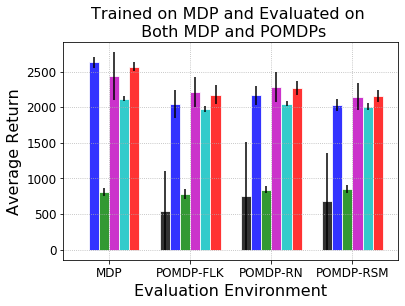

In [321]:
color = {'TD3':'b', 'TD3-OW':'m', 'TD3-OW-AddPastAct':'c', 'SAC':'g', 'DDPG':'k',
         'LSTM-TD3_HistLen0': 'k', 'LSTM-TD3_HistLen1': 'c', 'LSTM-TD3_HistLen3': 'b', 'LSTM-TD3_HistLen5': 'r'}
algs = ['DDPG', 'TD3', 'SAC', 'TD3-OW', 'TD3-OW-AddPastAct']
bar_width = 0.125
fig, axes = plt.subplots(1)
# Baselines
for alg_i, alg in enumerate(algs):
    # Calculate mean
    pomdp_evaluation = []
    pomdp_evaluation_mean = []
    pomdp_evaluation_std = []
    for pomdp_type in ['MDP', 'flickering', 'random_noise', 'random_sensor_missing']:
        s_run_evals = []
        for s_run in MDP_to_POMDP[alg]['AntPyBulletEnv-v0'].keys():
            s_run_evals += MDP_to_POMDP[alg]['AntPyBulletEnv-v0'][s_run][pomdp_type]
        pomdp_evaluation.append(s_run_evals)
        pomdp_evaluation_mean.append(np.mean(s_run_evals))
        pomdp_evaluation_std.append(np.std(s_run_evals))
    
    # Plot
    axes.bar(np.arange(0,4) + alg_i*bar_width - 2.5*bar_width, pomdp_evaluation_mean, yerr = pomdp_evaluation_std,
             width = bar_width, label='{}'.format(alg), color=color[alg], alpha=0.8, edgecolor='w')
# LSTM-TD3
lstm_td3_pomdp_evaluation = []
lstm_td3_pomdp_evaluation_mean = []
lstm_td3_pomdp_evaluation_std = []
for pomdp_type in ['MDP', 'flickering', 'random_noise', 'random_sensor_missing']:
    s_run_evals = []
    for s_run in lstm_td3_MDP_to_POMDP['LSTM-TD3']['AntPyBulletEnv-v0']['5'].keys():
        s_run_evals += lstm_td3_MDP_to_POMDP['LSTM-TD3']['AntPyBulletEnv-v0']['5'][s_run][pomdp_type]
    lstm_td3_pomdp_evaluation.append(s_run_evals)
    lstm_td3_pomdp_evaluation_mean.append(np.mean(s_run_evals))
    lstm_td3_pomdp_evaluation_std.append(np.std(s_run_evals))
    
# Plot
axes.bar(np.arange(0, 4) + 5*bar_width - 2.5*bar_width, lstm_td3_pomdp_evaluation_mean, yerr = lstm_td3_pomdp_evaluation_std,
         width = bar_width, label='{}'.format('LSTM-TD3'), color='r', alpha=0.8, edgecolor='w')

axes.set_xticks(np.arange(len(['MDP', 'flickering', 'random_noise', 'random_sensor_missing'])))
axes.set_xticklabels(['MDP', 'POMDP-FLK', 'POMDP-RN', 'POMDP-RSM'], fontsize=12)
axes.set_xlabel('Evaluation Environment', fontsize=16)
axes.set_ylabel('Average Return', fontsize=16)
axes.set_title('Trained on MDP and Evaluated on \n Both MDP and POMDPs', fontsize=16)
# axes.legend(ncol=3, bbox_to_anchor=(1.05, 1))
axes.grid(True, linestyle=':')
fig.savefig("D:\POMDP_Data\images\MDP_to_POMDP_evaluation.png", bbox_inches='tight')
plt.rc('font', size=12)

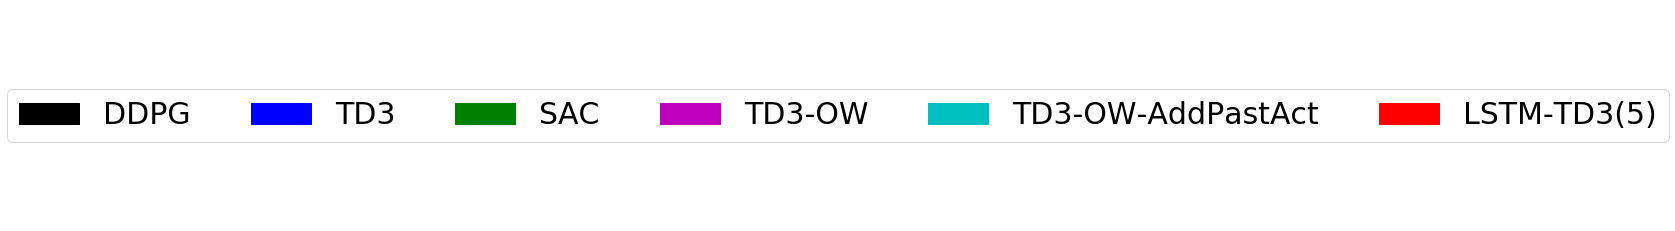

In [355]:
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D

lw_scale = 4

legend_elements= []
for alg in algs:
    legend_elements.append(Patch(facecolor=color[alg], edgecolor=color[alg], label=alg))
legend_elements.append(Patch(facecolor='r', edgecolor='r', label='LSTM-TD3(5)')) 
# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center', ncol=6)
ax.axis(False)
plt.show()
plt.rc('font', size=30)
fig.savefig("D:\POMDP_Data\images\MDP_to_POMDP_legend.png", bbox_inches='tight')


In [359]:
plt.rc('font', size=14)

## POMDP -> MDP
### Baselines


In [282]:
# root_dir = r"D:\POMDP_Data\clean_spinup_POMDP_Flickering_Baselines"
tasks = ['AntPyBulletEnv-v0']
baselines_POMDP_to_MDP = {}

root_dir_all_pomdp = ["D:\POMDP_Data\clean_spinup_POMDP_Flickering_Baselines", 
                      "D:\POMDP_Data\clean_spinup_POMDP_RandomNoise_Baselines",
                      "D:\POMDP_Data\clean_spinup_POMDP_RandomSensorMissing_Baselines",
                      "D:\POMDP_Data\clean_spinup_POMDP_RemoveVelocity_Baselines"]
for root_dir in root_dir_all_pomdp:
    for sub_dir in os.listdir(root_dir):
        print(sub_dir)
        print(sub_dir.split('_'))
        params = sub_dir.split('_')
        alg_name = params[1]
        task_name = params[2]
        pomdp_hyperparam = params[3]
        seed = params[4]
        if 'POMDP-RemoveVelocity' == pomdp_hyperparam:
            continue
        if task_name in tasks:
            if alg_name not in baselines_POMDP_to_MDP:
                baselines_POMDP_to_MDP[alg_name] = {}
            if task_name not in baselines_POMDP_to_MDP[alg_name]:
                baselines_POMDP_to_MDP[alg_name][task_name] = {}
            if pomdp_hyperparam not in baselines_POMDP_to_MDP[alg_name][task_name]:
                baselines_POMDP_to_MDP[alg_name][task_name][pomdp_hyperparam] = {}
            if seed not in baselines_POMDP_to_MDP[alg_name][task_name][pomdp_hyperparam]:
                baselines_POMDP_to_MDP[alg_name][task_name][pomdp_hyperparam][seed] = {}
            #
            print("********************************************************************")
            for exp_run in os.listdir(os.path.join(root_dir, sub_dir)):
                print(exp_run)
                # Load pre-trained model
                config_path = os.path.join(root_dir, sub_dir, exp_run, 'config.json')
                with open(config_path, 'r') as config_file:
                    config_json = json.load(config_file)
                model_path = os.path.join(root_dir, sub_dir, exp_run, 'pyt_save', 'model.pt')
                ac = torch.load(model_path)
                # print(ac)

                # Retrive hyper-parameters
                env_name = config_json['env_name']
                num_test_episodes = config_json['num_test_episodes']
                max_ep_len = config_json['max_ep_len']
                if alg_name == 'TD3-OW' or alg_name == 'TD3-OW-AddPastAct':
                    observation_window_size = config_json['observation_window_size']

                for pomdp_type in ['MDP', 'flickering', 'random_noise', 'random_sensor_missing']:
                    print("\t{}".format(pomdp_type))
                    baselines_POMDP_to_MDP[alg_name][task_name][pomdp_hyperparam][seed][pomdp_type] = []
                    # Create environment
                    if pomdp_type == 'MDP':
                        test_env = gym.make(env_name)
                    else:
                        test_env = POMDPWrapper(env_name, pomdp_type, flicker_prob, random_noise_sigma, random_sensor_missing_prob)
                    obs_dim = test_env.observation_space.shape[0]
                    act_dim = test_env.action_space.shape[0]
                    act_limit = test_env.action_space.high[0]

                    # Evaluation
                    for j in range(num_test_episodes):
                        # Reset environment
                        o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
                        if alg_name == 'TD3-OW':
                            ow_o = np.zeros([int(observation_window_size * obs_dim)])
                            ow_o[-obs_dim:] = o
                        elif alg_name == 'TD3-OW-AddPastAct':
                            ow_o = np.zeros([int((observation_window_size - 1) * (obs_dim + act_dim) + obs_dim)])
                            ow_o[-obs_dim:] = o
                        elif alg_name == 'LSTM-TD3':
                            pass
                        else:
                            pass

                        # Interact
                        while not(d or (ep_len == max_ep_len)):
                            # Take deterministic actions at test time 
                            if alg_name == 'TD3-OW' or alg_name == 'TD3-OW-AddPastAct':
                                action = ac.act(torch.as_tensor(ow_o, dtype=torch.float32))
                            elif alg_name == 'SAC':
                                action = ac.act(torch.as_tensor(o, dtype=torch.float32), True)
                            else:
                                action = ac.act(torch.as_tensor(o, dtype=torch.float32))
                            o, r, d, _ = test_env.step(action)
                            ep_ret += r
                            ep_len += 1

                            # Construct Observation-Window-based observation for TD3-OW and TD3-OW-AddPastAct
                            if alg_name == 'TD3-OW':
                                ow_o[:-obs_dim] = ow_o[obs_dim:]
                                ow_o[-obs_dim:] = o
                            elif alg_name == 'TD3-OW-AddPastAct':
                                ow_o[:-(obs_dim + act_dim)] = ow_o[(obs_dim + act_dim):]
                                ow_o[-(obs_dim + act_dim):] = np.concatenate((action, o))

                        print('\t  Episod-{}: Ep_Return={}, Ep_Len={}'.format(j, ep_ret, ep_len))
                        baselines_POMDP_to_MDP[alg_name][task_name][pomdp_hyperparam][seed][pomdp_type].append(ep_ret)

2020-11-17_DDPG_AntMuJoCoEnv-v0_POMDP-Flickering-FlickProb-0.2_s0
['2020-11-17', 'DDPG', 'AntMuJoCoEnv-v0', 'POMDP-Flickering-FlickProb-0.2', 's0']
2020-11-17_DDPG_AntMuJoCoEnv-v0_POMDP-Flickering-FlickProb-0.2_s1
['2020-11-17', 'DDPG', 'AntMuJoCoEnv-v0', 'POMDP-Flickering-FlickProb-0.2', 's1']
2020-11-17_DDPG_AntPyBulletEnv-v0_POMDP-Flickering-FlickProb-0.2_s0
['2020-11-17', 'DDPG', 'AntPyBulletEnv-v0', 'POMDP-Flickering-FlickProb-0.2', 's0']
********************************************************************
2020-11-17_00-01-23_DDPG_AntPyBulletEnv-v0_POMDP-Flickering-FlickProb-0.2_s0
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=741.7631394082019, Ep_Len=1000
	  Episod-1: Ep_Return=397.34627567768575, Ep_Len=1000
	  Episod-2: Ep_Return=740.861651086443, Ep_Len=1000
	  Episod-3: Ep_Return=454.42986500873076, Ep_Len=1000
	  Episod-4: Ep_Return=542.9659805235221, Ep_Len=1000
	  Episod-5: Ep_Return=543.288051101932, Ep_Len=1000
	  Episod-6: Ep_Return=536.4946047808736, Ep_L

	  Episod-2: Ep_Return=8.714980800777267, Ep_Len=20
	  Episod-3: Ep_Return=8.501206774808814, Ep_Len=20
	  Episod-4: Ep_Return=8.585181815283432, Ep_Len=20
	  Episod-5: Ep_Return=8.579439191377606, Ep_Len=20
	  Episod-6: Ep_Return=8.359072675384231, Ep_Len=20
	  Episod-7: Ep_Return=8.450584854200132, Ep_Len=20
	  Episod-8: Ep_Return=8.524606503950782, Ep_Len=20
	  Episod-9: Ep_Return=8.597667235902918, Ep_Len=20
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=7.075803170070868, Ep_Len=22
	  Episod-1: Ep_Return=7.405282845410691, Ep_Len=20
	  Episod-2: Ep_Return=29.969651349674674, Ep_Len=68
	  Episod-3: Ep_Return=6.833781859846203, Ep_Len=21
	  Episod-4: Ep_Return=7.722921325785861, Ep_Len=20
	  Episod-5: Ep_Return=8.008646278649394, Ep_Len=20
	  Episod-6: Ep_Return=7.573916144894611, Ep_Len=20
	  Episod-7: Ep_Return=7.695654558946262, Ep_Len=20
	  Episod-8: Ep_Return=6.684368360582447, Ep_Len=23
	  Episod-9: Ep_Return=7.207805080938852, Ep_Len=21
	random_noise
Walker

	  Episod-0: Ep_Return=80.13199647776167, Ep_Len=1000
	  Episod-1: Ep_Return=114.33776209170132, Ep_Len=1000
	  Episod-2: Ep_Return=84.17863637420612, Ep_Len=1000
	  Episod-3: Ep_Return=81.4668058998093, Ep_Len=1000
	  Episod-4: Ep_Return=88.28731329160722, Ep_Len=1000
	  Episod-5: Ep_Return=85.43832814655845, Ep_Len=1000
	  Episod-6: Ep_Return=80.80015091311907, Ep_Len=1000
	  Episod-7: Ep_Return=81.3403359712374, Ep_Len=1000
	  Episod-8: Ep_Return=82.71887951436317, Ep_Len=1000
	  Episod-9: Ep_Return=89.23315749703384, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=121.21062405196713, Ep_Len=1000
	  Episod-1: Ep_Return=87.97953647092284, Ep_Len=1000
	  Episod-2: Ep_Return=88.77496145908727, Ep_Len=1000
	  Episod-3: Ep_Return=88.1243208877676, Ep_Len=1000
	  Episod-4: Ep_Return=89.6538605544141, Ep_Len=1000
	  Episod-5: Ep_Return=79.60363013340363, Ep_Len=1000
	  Episod-6: Ep_Return=87.58683400847583, Ep_Len=1000
	  Episod-7: Ep_Return=89.97498392233888,

	  Episod-0: Ep_Return=787.1805387903036, Ep_Len=1000
	  Episod-1: Ep_Return=876.0094944692377, Ep_Len=1000
	  Episod-2: Ep_Return=795.2419893893857, Ep_Len=1000
	  Episod-3: Ep_Return=851.8060609736168, Ep_Len=1000
	  Episod-4: Ep_Return=859.2374803888999, Ep_Len=1000
	  Episod-5: Ep_Return=784.620794098495, Ep_Len=1000
	  Episod-6: Ep_Return=827.6540937435524, Ep_Len=1000
	  Episod-7: Ep_Return=837.727216948152, Ep_Len=1000
	  Episod-8: Ep_Return=723.142119335834, Ep_Len=1000
	  Episod-9: Ep_Return=875.3934608262269, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=612.2830002197551, Ep_Len=1000
	  Episod-1: Ep_Return=617.4520279410651, Ep_Len=1000
	  Episod-2: Ep_Return=621.0409121995608, Ep_Len=1000
	  Episod-3: Ep_Return=649.5268015229683, Ep_Len=1000
	  Episod-4: Ep_Return=639.2565200048313, Ep_Len=1000
	  Episod-5: Ep_Return=623.1299316507265, Ep_Len=1000
	  Episod-6: Ep_Return=660.9222775940426, Ep_Len=1000
	  Episod-7: Ep_Return=591.6713686552577, 

	  Episod-0: Ep_Return=1975.8152364127047, Ep_Len=1000
	  Episod-1: Ep_Return=1919.0468216977179, Ep_Len=1000
	  Episod-2: Ep_Return=1918.5911091595303, Ep_Len=1000
	  Episod-3: Ep_Return=1915.0783430873796, Ep_Len=1000
	  Episod-4: Ep_Return=1992.1716016284088, Ep_Len=1000
	  Episod-5: Ep_Return=1872.4577140490649, Ep_Len=1000
	  Episod-6: Ep_Return=1955.5546601780989, Ep_Len=1000
	  Episod-7: Ep_Return=1933.6043770680278, Ep_Len=1000
	  Episod-8: Ep_Return=1931.729425422842, Ep_Len=1000
	  Episod-9: Ep_Return=1941.3166720449192, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1864.0641050110885, Ep_Len=1000
	  Episod-1: Ep_Return=1885.606370548856, Ep_Len=1000
	  Episod-2: Ep_Return=1965.5385116757532, Ep_Len=1000
	  Episod-3: Ep_Return=1943.9264197548225, Ep_Len=1000
	  Episod-4: Ep_Return=1884.7794398112594, Ep_Len=1000
	  Episod-5: Ep_Return=1938.9638417680137, Ep_Len=1000
	  Episod-6: Ep_Return=1991.1309008072842, Ep_Len=1000
	  Episod-7: Ep_Return=1

	  Episod-3: Ep_Return=161.51592633322193, Ep_Len=1000
	  Episod-4: Ep_Return=69.6427109061571, Ep_Len=1000
	  Episod-5: Ep_Return=192.26857740115275, Ep_Len=1000
	  Episod-6: Ep_Return=193.8103478713853, Ep_Len=1000
	  Episod-7: Ep_Return=180.53690706570003, Ep_Len=1000
	  Episod-8: Ep_Return=188.0767220678863, Ep_Len=1000
	  Episod-9: Ep_Return=161.55992402764838, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=186.33092043212753, Ep_Len=1000
	  Episod-1: Ep_Return=185.5829776670254, Ep_Len=1000
	  Episod-2: Ep_Return=178.72298219438207, Ep_Len=1000
	  Episod-3: Ep_Return=187.8326892739897, Ep_Len=1000
	  Episod-4: Ep_Return=182.94265202421178, Ep_Len=1000
	  Episod-5: Ep_Return=185.1448904188548, Ep_Len=1000
	  Episod-6: Ep_Return=73.22448180936956, Ep_Len=1000
	  Episod-7: Ep_Return=189.69122938436405, Ep_Len=1000
	  Episod-8: Ep_Return=81.60097806612859, Ep_Len=1000
	  Episod-9: Ep_Return=182.79326411558085, Ep_Len=1000
	random_noise
WalkerBase::__ini

	  Episod-8: Ep_Return=1788.4962577639444, Ep_Len=1000
	  Episod-9: Ep_Return=1731.217153887475, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1701.7547597592236, Ep_Len=1000
	  Episod-1: Ep_Return=1669.0654076942087, Ep_Len=1000
	  Episod-2: Ep_Return=1648.7730183602205, Ep_Len=1000
	  Episod-3: Ep_Return=1670.9802051278798, Ep_Len=1000
	  Episod-4: Ep_Return=1746.3644162579244, Ep_Len=1000
	  Episod-5: Ep_Return=1666.7294552099243, Ep_Len=1000
	  Episod-6: Ep_Return=1757.9677571537065, Ep_Len=1000
	  Episod-7: Ep_Return=1717.5443367546998, Ep_Len=1000
	  Episod-8: Ep_Return=1705.1818006967371, Ep_Len=1000
	  Episod-9: Ep_Return=1712.7661154378848, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1647.9725115184772, Ep_Len=1000
	  Episod-1: Ep_Return=1664.261059371206, Ep_Len=1000
	  Episod-2: Ep_Return=1561.0881798188261, Ep_Len=1000
	  Episod-3: Ep_Return=1689.60483929174, Ep_Len=1000
	  Episod-4: Ep_Return=17

	  Episod-1: Ep_Return=155.17918216119506, Ep_Len=1000
	  Episod-2: Ep_Return=150.91789356525135, Ep_Len=1000
	  Episod-3: Ep_Return=90.576940762715, Ep_Len=1000
	  Episod-4: Ep_Return=174.60359208681774, Ep_Len=1000
	  Episod-5: Ep_Return=147.93964732772307, Ep_Len=1000
	  Episod-6: Ep_Return=102.76344614253021, Ep_Len=1000
	  Episod-7: Ep_Return=145.0872611724232, Ep_Len=1000
	  Episod-8: Ep_Return=183.44404153001773, Ep_Len=1000
	  Episod-9: Ep_Return=185.95957846611944, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=149.01143119955526, Ep_Len=1000
	  Episod-1: Ep_Return=93.68360487024812, Ep_Len=1000
	  Episod-2: Ep_Return=117.74886325905982, Ep_Len=1000
	  Episod-3: Ep_Return=187.1297525225317, Ep_Len=1000
	  Episod-4: Ep_Return=184.08362837691047, Ep_Len=1000
	  Episod-5: Ep_Return=87.69675189027114, Ep_Len=1000
	  Episod-6: Ep_Return=145.08483317842885, Ep_Len=1000
	  Episod-7: Ep_Return=154.11205550556403, Ep_Len=1000
	  Episod-8: Ep_Re

	  Episod-6: Ep_Return=844.602156347734, Ep_Len=1000
	  Episod-7: Ep_Return=894.440987902107, Ep_Len=1000
	  Episod-8: Ep_Return=650.6510875925577, Ep_Len=1000
	  Episod-9: Ep_Return=820.869102576967, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=850.4306686880738, Ep_Len=1000
	  Episod-1: Ep_Return=867.5641084428985, Ep_Len=1000
	  Episod-2: Ep_Return=684.7473662180656, Ep_Len=1000
	  Episod-3: Ep_Return=689.8418178583161, Ep_Len=1000
	  Episod-4: Ep_Return=751.4323871046175, Ep_Len=1000
	  Episod-5: Ep_Return=812.3348855870887, Ep_Len=1000
	  Episod-6: Ep_Return=732.3519946285717, Ep_Len=1000
	  Episod-7: Ep_Return=744.9574189182417, Ep_Len=1000
	  Episod-8: Ep_Return=848.4855661581355, Ep_Len=1000
	  Episod-9: Ep_Return=734.2740978075773, Ep_Len=1000
2020-12-12_DDPG_AntPyBulletEnv-v0_POMDP-RandomNoise-Sigma-0.05_s1
['2020-12-12', 'DDPG', 'AntPyBulletEnv-v0', 'POMDP-RandomNoise-Sigma-0.05', 's1']
*********************************************

	  Episod-2: Ep_Return=564.2197699642614, Ep_Len=1000
	  Episod-3: Ep_Return=444.2565173264401, Ep_Len=1000
	  Episod-4: Ep_Return=478.2932434550666, Ep_Len=1000
	  Episod-5: Ep_Return=586.7906146270526, Ep_Len=1000
	  Episod-6: Ep_Return=519.8891630722658, Ep_Len=1000
	  Episod-7: Ep_Return=502.9584364933932, Ep_Len=1000
	  Episod-8: Ep_Return=502.5463125192216, Ep_Len=1000
	  Episod-9: Ep_Return=458.3577139544546, Ep_Len=1000
2020-12-12_DDPG_AntPyBulletEnv-v0_POMDP-RandomNoise-Sigma-0.2_s0
['2020-12-12', 'DDPG', 'AntPyBulletEnv-v0', 'POMDP-RandomNoise-Sigma-0.2', 's0']
********************************************************************
2020-12-12_01-08-52_DDPG_AntPyBulletEnv-v0_POMDP-RandomNoise-Sigma-0.2_s0
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=179.5771025244816, Ep_Len=1000
	  Episod-1: Ep_Return=196.14827506352435, Ep_Len=1000
	  Episod-2: Ep_Return=177.69470746189467, Ep_Len=1000
	  Episod-3: Ep_Return=247.82358136360682, Ep_Len=844
	  Episod-4: Ep_Return=22

	  Episod-8: Ep_Return=512.2920667798968, Ep_Len=1000
	  Episod-9: Ep_Return=595.7486070843779, Ep_Len=1000
2020-12-12_DDPG_AntPyBulletEnv-v0_POMDP-RandomNoise-Sigma-0.5_s1
['2020-12-12', 'DDPG', 'AntPyBulletEnv-v0', 'POMDP-RandomNoise-Sigma-0.5', 's1']
********************************************************************
2020-12-12_01-08-52_DDPG_AntPyBulletEnv-v0_POMDP-RandomNoise-Sigma-0.5_s1
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=617.5763437827695, Ep_Len=1000
	  Episod-1: Ep_Return=642.0432107106077, Ep_Len=1000
	  Episod-2: Ep_Return=485.1932321646234, Ep_Len=1000
	  Episod-3: Ep_Return=561.1516921407267, Ep_Len=1000
	  Episod-4: Ep_Return=517.418603340144, Ep_Len=1000
	  Episod-5: Ep_Return=569.6726967304639, Ep_Len=1000
	  Episod-6: Ep_Return=620.451307241696, Ep_Len=1000
	  Episod-7: Ep_Return=601.2099438776612, Ep_Len=1000
	  Episod-8: Ep_Return=487.29024737713064, Ep_Len=1000
	  Episod-9: Ep_Return=593.7737007248924, Ep_Len=1000
	flickering
WalkerBase::__in

	  Episod-0: Ep_Return=555.310826565942, Ep_Len=1000
	  Episod-1: Ep_Return=781.6066372961022, Ep_Len=1000
	  Episod-2: Ep_Return=696.4609721216092, Ep_Len=1000
	  Episod-3: Ep_Return=601.736571570368, Ep_Len=1000
	  Episod-4: Ep_Return=594.732115844839, Ep_Len=1000
	  Episod-5: Ep_Return=603.873103876029, Ep_Len=1000
	  Episod-6: Ep_Return=519.5024903901067, Ep_Len=1000
	  Episod-7: Ep_Return=514.7606493053136, Ep_Len=1000
	  Episod-8: Ep_Return=522.1969071182041, Ep_Len=1000
	  Episod-9: Ep_Return=529.0791238573883, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=597.2814038668752, Ep_Len=1000
	  Episod-1: Ep_Return=599.7060866588638, Ep_Len=1000
	  Episod-2: Ep_Return=489.4070826950877, Ep_Len=1000
	  Episod-3: Ep_Return=433.8308828198923, Ep_Len=1000
	  Episod-4: Ep_Return=475.6941281163453, Ep_Len=1000
	  Episod-5: Ep_Return=455.3636128242001, Ep_Len=1000
	  Episod-6: Ep_Return=539.9824401647911, Ep_Len=1000
	  Episod-7: Ep_Return=540.1646325652321, E

	  Episod-6: Ep_Return=482.7237546715022, Ep_Len=1000
	  Episod-7: Ep_Return=472.53990473787263, Ep_Len=1000
	  Episod-8: Ep_Return=472.08768808658084, Ep_Len=1000
	  Episod-9: Ep_Return=487.15986790569895, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=477.31578775368735, Ep_Len=1000
	  Episod-1: Ep_Return=456.0955766597596, Ep_Len=1000
	  Episod-2: Ep_Return=481.26407575939476, Ep_Len=1000
	  Episod-3: Ep_Return=559.2491480183648, Ep_Len=1000
	  Episod-4: Ep_Return=522.766157126774, Ep_Len=1000
	  Episod-5: Ep_Return=592.8789766986025, Ep_Len=1000
	  Episod-6: Ep_Return=411.7745756268433, Ep_Len=1000
	  Episod-7: Ep_Return=554.1440884594141, Ep_Len=1000
	  Episod-8: Ep_Return=498.84423071414557, Ep_Len=1000
	  Episod-9: Ep_Return=402.4286680707521, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=490.4686931264284, Ep_Len=1000
	  Episod-1: Ep_Return=486.6325459364099, Ep_Len=1000
	  Episod-2: Ep_Return=471.43304697839187, 

	  Episod-2: Ep_Return=502.05301366689383, Ep_Len=1000
	  Episod-3: Ep_Return=606.9228989749267, Ep_Len=1000
	  Episod-4: Ep_Return=352.58416380186145, Ep_Len=473
	  Episod-5: Ep_Return=600.9657755693914, Ep_Len=1000
	  Episod-6: Ep_Return=71.60475947158085, Ep_Len=144
	  Episod-7: Ep_Return=10.123063672646818, Ep_Len=20
	  Episod-8: Ep_Return=20.054990213158455, Ep_Len=40
	  Episod-9: Ep_Return=24.0238519247854, Ep_Len=42
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=9.78499153214798, Ep_Len=20
	  Episod-1: Ep_Return=9.856088289670875, Ep_Len=20
	  Episod-2: Ep_Return=9.852589024862391, Ep_Len=20
	  Episod-3: Ep_Return=9.792087524186355, Ep_Len=20
	  Episod-4: Ep_Return=9.953045256393668, Ep_Len=20
	  Episod-5: Ep_Return=9.882223695535501, Ep_Len=20
	  Episod-6: Ep_Return=9.848918865201993, Ep_Len=20
	  Episod-7: Ep_Return=9.841314037685514, Ep_Len=20
	  Episod-8: Ep_Return=9.922464751772349, Ep_Len=20
	  Episod-9: Ep_Return=9.914288197211864, Ep_Len=20
	random_s

['2020-12-12', 'SAC', 'Walker2DMuJoCoEnv-v0', 'POMDP-RandomNoise-Sigma-0.05', 's0']
2020-12-12_SAC_Walker2DMuJoCoEnv-v0_POMDP-RandomNoise-Sigma-0.05_s1
['2020-12-12', 'SAC', 'Walker2DMuJoCoEnv-v0', 'POMDP-RandomNoise-Sigma-0.05', 's1']
2020-12-12_SAC_Walker2DMuJoCoEnv-v0_POMDP-RandomNoise-Sigma-0.1_s0
['2020-12-12', 'SAC', 'Walker2DMuJoCoEnv-v0', 'POMDP-RandomNoise-Sigma-0.1', 's0']
2020-12-12_SAC_Walker2DMuJoCoEnv-v0_POMDP-RandomNoise-Sigma-0.1_s1
['2020-12-12', 'SAC', 'Walker2DMuJoCoEnv-v0', 'POMDP-RandomNoise-Sigma-0.1', 's1']
2020-12-12_SAC_Walker2DMuJoCoEnv-v0_POMDP-RandomNoise-Sigma-0.2_s0
['2020-12-12', 'SAC', 'Walker2DMuJoCoEnv-v0', 'POMDP-RandomNoise-Sigma-0.2', 's0']
2020-12-12_SAC_Walker2DMuJoCoEnv-v0_POMDP-RandomNoise-Sigma-0.2_s1
['2020-12-12', 'SAC', 'Walker2DMuJoCoEnv-v0', 'POMDP-RandomNoise-Sigma-0.2', 's1']
2020-12-12_SAC_Walker2DMuJoCoEnv-v0_POMDP-RandomNoise-Sigma-0.5_s0
['2020-12-12', 'SAC', 'Walker2DMuJoCoEnv-v0', 'POMDP-RandomNoise-Sigma-0.5', 's0']
2020-12-12_SAC

	  Episod-9: Ep_Return=1242.3342050129083, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1096.9447636037023, Ep_Len=1000
	  Episod-1: Ep_Return=911.6137882498919, Ep_Len=1000
	  Episod-2: Ep_Return=1238.4183005515497, Ep_Len=1000
	  Episod-3: Ep_Return=1177.595243649727, Ep_Len=1000
	  Episod-4: Ep_Return=1023.9618729400146, Ep_Len=1000
	  Episod-5: Ep_Return=1165.204113590764, Ep_Len=1000
	  Episod-6: Ep_Return=1285.160307168077, Ep_Len=1000
	  Episod-7: Ep_Return=1091.2446224087425, Ep_Len=1000
	  Episod-8: Ep_Return=1202.5050870633802, Ep_Len=1000
	  Episod-9: Ep_Return=1135.237794147452, Ep_Len=1000
2020-12-12_TD3-OW_AntPyBulletEnv-v0_POMDP-RandomNoise-Sigma-0.1_s0
['2020-12-12', 'TD3-OW', 'AntPyBulletEnv-v0', 'POMDP-RandomNoise-Sigma-0.1', 's0']
********************************************************************
2020-12-12_02-00-07_TD3-OW_AntPyBulletEnv-v0_POMDP-RandomNoise-Sigma-0.1_s0
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep

	  Episod-2: Ep_Return=1136.0042397963223, Ep_Len=1000
	  Episod-3: Ep_Return=1169.783093946996, Ep_Len=1000
	  Episod-4: Ep_Return=1235.2455808310417, Ep_Len=1000
	  Episod-5: Ep_Return=1204.7993007462, Ep_Len=1000
	  Episod-6: Ep_Return=1227.699316090217, Ep_Len=1000
	  Episod-7: Ep_Return=1215.5994783918022, Ep_Len=1000
	  Episod-8: Ep_Return=1173.626703501779, Ep_Len=1000
	  Episod-9: Ep_Return=1161.9975748619624, Ep_Len=1000
2020-12-12_TD3-OW_AntPyBulletEnv-v0_POMDP-RandomNoise-Sigma-0.2_s1
['2020-12-12', 'TD3-OW', 'AntPyBulletEnv-v0', 'POMDP-RandomNoise-Sigma-0.2', 's1']
********************************************************************
2020-12-12_02-00-10_TD3-OW_AntPyBulletEnv-v0_POMDP-RandomNoise-Sigma-0.2_s1
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1536.4489654670786, Ep_Len=1000
	  Episod-1: Ep_Return=1607.9540741905876, Ep_Len=1000
	  Episod-2: Ep_Return=1548.764159847173, Ep_Len=1000
	  Episod-3: Ep_Return=1546.9617082859204, Ep_Len=1000
	  Episod-4: Ep_

	  Episod-7: Ep_Return=280.26379434086033, Ep_Len=1000
	  Episod-8: Ep_Return=172.3147694304002, Ep_Len=1000
	  Episod-9: Ep_Return=273.0112036315393, Ep_Len=1000
2020-12-12_TD3-OW_HalfCheetahMuJoCoEnv-v0_POMDP-RandomNoise-Sigma-0.05_s0
['2020-12-12', 'TD3-OW', 'HalfCheetahMuJoCoEnv-v0', 'POMDP-RandomNoise-Sigma-0.05', 's0']
2020-12-12_TD3-OW_HalfCheetahMuJoCoEnv-v0_POMDP-RandomNoise-Sigma-0.05_s1
['2020-12-12', 'TD3-OW', 'HalfCheetahMuJoCoEnv-v0', 'POMDP-RandomNoise-Sigma-0.05', 's1']
2020-12-12_TD3-OW_HalfCheetahMuJoCoEnv-v0_POMDP-RandomNoise-Sigma-0.1_s0
['2020-12-12', 'TD3-OW', 'HalfCheetahMuJoCoEnv-v0', 'POMDP-RandomNoise-Sigma-0.1', 's0']
2020-12-12_TD3-OW_HalfCheetahMuJoCoEnv-v0_POMDP-RandomNoise-Sigma-0.1_s1
['2020-12-12', 'TD3-OW', 'HalfCheetahMuJoCoEnv-v0', 'POMDP-RandomNoise-Sigma-0.1', 's1']
2020-12-12_TD3-OW_HalfCheetahMuJoCoEnv-v0_POMDP-RandomNoise-Sigma-0.2_s0
['2020-12-12', 'TD3-OW', 'HalfCheetahMuJoCoEnv-v0', 'POMDP-RandomNoise-Sigma-0.2', 's0']
2020-12-12_TD3-OW_HalfC

	  Episod-0: Ep_Return=1570.8082891845988, Ep_Len=1000
	  Episod-1: Ep_Return=1533.631007645136, Ep_Len=1000
	  Episod-2: Ep_Return=1547.8478706755939, Ep_Len=1000
	  Episod-3: Ep_Return=1539.9178361258116, Ep_Len=1000
	  Episod-4: Ep_Return=1544.3856003601093, Ep_Len=1000
	  Episod-5: Ep_Return=1536.0707085327538, Ep_Len=1000
	  Episod-6: Ep_Return=1586.5208444078207, Ep_Len=1000
	  Episod-7: Ep_Return=1538.0442450753865, Ep_Len=1000
	  Episod-8: Ep_Return=1560.5816276227326, Ep_Len=1000
	  Episod-9: Ep_Return=1556.1988315609299, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1372.5346307106854, Ep_Len=1000
	  Episod-1: Ep_Return=1466.5053382102294, Ep_Len=1000
	  Episod-2: Ep_Return=1407.4621831329296, Ep_Len=1000
	  Episod-3: Ep_Return=1358.3990762843184, Ep_Len=1000
	  Episod-4: Ep_Return=1423.401283659736, Ep_Len=1000
	  Episod-5: Ep_Return=1363.73748622967, Ep_Len=1000
	  Episod-6: Ep_Return=1449.6674034798832, Ep_Len=1000
	  Episod-7: Ep_Return=140

	  Episod-5: Ep_Return=1305.7192270533783, Ep_Len=1000
	  Episod-6: Ep_Return=1290.06094303304, Ep_Len=1000
	  Episod-7: Ep_Return=1160.8553030596668, Ep_Len=1000
	  Episod-8: Ep_Return=1206.8665130396469, Ep_Len=1000
	  Episod-9: Ep_Return=1301.295749797382, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1018.1066069132108, Ep_Len=1000
	  Episod-1: Ep_Return=935.2326339084505, Ep_Len=1000
	  Episod-2: Ep_Return=903.1073433582411, Ep_Len=1000
	  Episod-3: Ep_Return=1125.1124499775874, Ep_Len=1000
	  Episod-4: Ep_Return=873.932416354772, Ep_Len=1000
	  Episod-5: Ep_Return=1059.0347777265902, Ep_Len=1000
	  Episod-6: Ep_Return=1000.6118619765849, Ep_Len=1000
	  Episod-7: Ep_Return=888.2422772994162, Ep_Len=1000
	  Episod-8: Ep_Return=1148.9026011788376, Ep_Len=1000
	  Episod-9: Ep_Return=977.7771593683146, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1022.5075481046316, Ep_Len=1000
	  Episod-1: Ep_Return=1037.3388032848381

	  Episod-0: Ep_Return=542.5313658693841, Ep_Len=1000
	  Episod-1: Ep_Return=528.4410735482052, Ep_Len=1000
	  Episod-2: Ep_Return=550.7365063197841, Ep_Len=1000
	  Episod-3: Ep_Return=413.1962405688867, Ep_Len=1000
	  Episod-4: Ep_Return=540.0779067505231, Ep_Len=1000
	  Episod-5: Ep_Return=367.24387928521145, Ep_Len=1000
	  Episod-6: Ep_Return=342.40946070044646, Ep_Len=1000
	  Episod-7: Ep_Return=433.96187076863896, Ep_Len=1000
	  Episod-8: Ep_Return=376.2355091578326, Ep_Len=1000
	  Episod-9: Ep_Return=506.76369222513995, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=477.05911241358694, Ep_Len=1000
	  Episod-1: Ep_Return=516.0925361477018, Ep_Len=1000
	  Episod-2: Ep_Return=534.0185643052811, Ep_Len=1000
	  Episod-3: Ep_Return=537.1879189469473, Ep_Len=1000
	  Episod-4: Ep_Return=454.661908636961, Ep_Len=1000
	  Episod-5: Ep_Return=534.7098869501488, Ep_Len=1000
	  Episod-6: Ep_Return=552.8646392235639, Ep_Len=1000
	  Episod-7: Ep_Return=460.834945

	  Episod-0: Ep_Return=288.4173568497363, Ep_Len=1000
	  Episod-1: Ep_Return=187.44538007331943, Ep_Len=1000
	  Episod-2: Ep_Return=187.56200433878772, Ep_Len=1000
	  Episod-3: Ep_Return=288.0081166426281, Ep_Len=1000
	  Episod-4: Ep_Return=287.85699542719755, Ep_Len=1000
	  Episod-5: Ep_Return=186.89760607941216, Ep_Len=1000
	  Episod-6: Ep_Return=186.49416428475462, Ep_Len=1000
	  Episod-7: Ep_Return=286.88425505735006, Ep_Len=1000
	  Episod-8: Ep_Return=186.9359080703588, Ep_Len=1000
	  Episod-9: Ep_Return=78.42189357050496, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=186.61655268349503, Ep_Len=1000
	  Episod-1: Ep_Return=286.62402961165145, Ep_Len=1000
	  Episod-2: Ep_Return=286.5340476130027, Ep_Len=1000
	  Episod-3: Ep_Return=186.26586893539144, Ep_Len=1000
	  Episod-4: Ep_Return=186.8386188554469, Ep_Len=1000
	  Episod-5: Ep_Return=188.39694889090532, Ep_Len=1000
	  Episod-6: Ep_Return=186.49338138211834, Ep_Len=1000
	  Episod-7: Ep_Return=290.4

	  Episod-3: Ep_Return=1807.369402393654, Ep_Len=1000
	  Episod-4: Ep_Return=1676.2280577013337, Ep_Len=1000
	  Episod-5: Ep_Return=1587.093034651294, Ep_Len=1000
	  Episod-6: Ep_Return=1622.1293068864334, Ep_Len=1000
	  Episod-7: Ep_Return=1607.7454661160873, Ep_Len=1000
	  Episod-8: Ep_Return=1770.7297951086919, Ep_Len=1000
	  Episod-9: Ep_Return=1765.8651099896424, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1498.9519270070414, Ep_Len=1000
	  Episod-1: Ep_Return=1780.0196105007153, Ep_Len=1000
	  Episod-2: Ep_Return=1313.3016109434498, Ep_Len=1000
	  Episod-3: Ep_Return=1009.9480521568729, Ep_Len=1000
	  Episod-4: Ep_Return=1440.4084805921784, Ep_Len=1000
	  Episod-5: Ep_Return=1630.4353645085203, Ep_Len=1000
	  Episod-6: Ep_Return=1750.104213429788, Ep_Len=1000
	  Episod-7: Ep_Return=1643.6081202865691, Ep_Len=1000
	  Episod-8: Ep_Return=1642.4419874049643, Ep_Len=1000
	  Episod-9: Ep_Return=1634.3103522271601, Ep_Len=1000
	random_noise
WalkerBase:

	  Episod-0: Ep_Return=1476.100382386276, Ep_Len=1000
	  Episod-1: Ep_Return=1448.977743566227, Ep_Len=1000
	  Episod-2: Ep_Return=1513.0354685956418, Ep_Len=1000
	  Episod-3: Ep_Return=1440.7057000261373, Ep_Len=1000
	  Episod-4: Ep_Return=1506.9379036439313, Ep_Len=1000
	  Episod-5: Ep_Return=1405.0844790767287, Ep_Len=1000
	  Episod-6: Ep_Return=1478.2226998417184, Ep_Len=1000
	  Episod-7: Ep_Return=1531.6157749046065, Ep_Len=1000
	  Episod-8: Ep_Return=1476.3224381172065, Ep_Len=1000
	  Episod-9: Ep_Return=1409.9364077866205, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1416.763141287617, Ep_Len=1000
	  Episod-1: Ep_Return=1400.5936063459253, Ep_Len=1000
	  Episod-2: Ep_Return=1453.3968614410269, Ep_Len=1000
	  Episod-3: Ep_Return=1432.702286321994, Ep_Len=1000
	  Episod-4: Ep_Return=1363.721114716477, Ep_Len=1000
	  Episod-5: Ep_Return=1354.9673867423023, Ep_Len=1000
	  Episod-6: Ep_Return=1383.4586578422804, Ep_Len=1000
	  Episod-7: Ep_

	  Episod-4: Ep_Return=1421.4986777022455, Ep_Len=1000
	  Episod-5: Ep_Return=1373.0309465580203, Ep_Len=1000
	  Episod-6: Ep_Return=1472.9021988800025, Ep_Len=1000
	  Episod-7: Ep_Return=1411.6176694247251, Ep_Len=1000
	  Episod-8: Ep_Return=1384.7290082240074, Ep_Len=1000
	  Episod-9: Ep_Return=1446.7789255107627, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1321.8133686861697, Ep_Len=1000
	  Episod-1: Ep_Return=1377.8061474596748, Ep_Len=1000
	  Episod-2: Ep_Return=1301.6983024149445, Ep_Len=1000
	  Episod-3: Ep_Return=1375.7203844892629, Ep_Len=1000
	  Episod-4: Ep_Return=1246.6607835913992, Ep_Len=1000
	  Episod-5: Ep_Return=1341.83868696335, Ep_Len=1000
	  Episod-6: Ep_Return=1346.5581922496524, Ep_Len=1000
	  Episod-7: Ep_Return=1326.5839341962935, Ep_Len=1000
	  Episod-8: Ep_Return=1272.8881268855337, Ep_Len=1000
	  Episod-9: Ep_Return=1205.6327010115097, Ep_Len=1000
2021-01-29_TD3-OW_HalfCheetahPyBulletEnv-v0_POMDP-RandomNoise-Sigma-

	  Episod-8: Ep_Return=561.4962791145851, Ep_Len=1000
	  Episod-9: Ep_Return=527.3475443256749, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=546.6657354865106, Ep_Len=1000
	  Episod-1: Ep_Return=480.3303350460424, Ep_Len=1000
	  Episod-2: Ep_Return=535.2723890885524, Ep_Len=1000
	  Episod-3: Ep_Return=574.7444515912385, Ep_Len=1000
	  Episod-4: Ep_Return=615.2989690363016, Ep_Len=1000
	  Episod-5: Ep_Return=592.268877423113, Ep_Len=1000
	  Episod-6: Ep_Return=515.105988264353, Ep_Len=1000
	  Episod-7: Ep_Return=551.9016744328723, Ep_Len=1000
	  Episod-8: Ep_Return=550.3083312186442, Ep_Len=1000
	  Episod-9: Ep_Return=476.06295201995204, Ep_Len=1000
2020-12-13_DDPG_AntPyBulletEnv-v0_POMDP-RandomSensorMissing-MissProb-0.05_s1
['2020-12-13', 'DDPG', 'AntPyBulletEnv-v0', 'POMDP-RandomSensorMissing-MissProb-0.05', 's1']
********************************************************************
2020-12-13_10-13-22_DDPG_AntPyBulletEnv-v0_POMDP-RandomSenso

	  Episod-1: Ep_Return=540.9965078205546, Ep_Len=1000
	  Episod-2: Ep_Return=578.5157719675441, Ep_Len=1000
	  Episod-3: Ep_Return=569.134313749955, Ep_Len=1000
	  Episod-4: Ep_Return=554.7405100717436, Ep_Len=1000
	  Episod-5: Ep_Return=527.7081734761819, Ep_Len=1000
	  Episod-6: Ep_Return=490.5704592635477, Ep_Len=1000
	  Episod-7: Ep_Return=569.2842799750359, Ep_Len=1000
	  Episod-8: Ep_Return=530.8770678483879, Ep_Len=1000
	  Episod-9: Ep_Return=628.7950135820803, Ep_Len=1000
2020-12-13_DDPG_AntPyBulletEnv-v0_POMDP-RandomSensorMissing-MissProb-0.2_s0
['2020-12-13', 'DDPG', 'AntPyBulletEnv-v0', 'POMDP-RandomSensorMissing-MissProb-0.2', 's0']
********************************************************************
2020-12-13_10-13-22_DDPG_AntPyBulletEnv-v0_POMDP-RandomSensorMissing-MissProb-0.2_s0
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=721.11034435928, Ep_Len=1000
	  Episod-1: Ep_Return=538.692174434416, Ep_Len=1000
	  Episod-2: Ep_Return=453.8386520279866, Ep_Len=100

	  Episod-5: Ep_Return=712.4627486131818, Ep_Len=1000
	  Episod-6: Ep_Return=583.0523473046657, Ep_Len=1000
	  Episod-7: Ep_Return=537.5162197801826, Ep_Len=1000
	  Episod-8: Ep_Return=658.6732274106572, Ep_Len=1000
	  Episod-9: Ep_Return=359.3496516430854, Ep_Len=1000
2020-12-13_DDPG_AntPyBulletEnv-v0_POMDP-RandomSensorMissing-MissProb-0.5_s1
['2020-12-13', 'DDPG', 'AntPyBulletEnv-v0', 'POMDP-RandomSensorMissing-MissProb-0.5', 's1']
********************************************************************
2020-12-13_10-13-17_DDPG_AntPyBulletEnv-v0_POMDP-RandomSensorMissing-MissProb-0.5_s1
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=0.4900474067500906, Ep_Len=20
	  Episod-1: Ep_Return=1.860369195514067, Ep_Len=20
	  Episod-2: Ep_Return=1.7062517442391245, Ep_Len=20
	  Episod-3: Ep_Return=2.0614120441852717, Ep_Len=20
	  Episod-4: Ep_Return=1.1000738737988267, Ep_Len=20
	  Episod-5: Ep_Return=1.0069076859057526, Ep_Len=20
	  Episod-6: Ep_Return=1.2057009783340615, Ep_Len=20
	 

	  Episod-0: Ep_Return=732.3443697014512, Ep_Len=1000
	  Episod-1: Ep_Return=705.195165465723, Ep_Len=1000
	  Episod-2: Ep_Return=707.600733907499, Ep_Len=1000
	  Episod-3: Ep_Return=784.0792008166783, Ep_Len=1000
	  Episod-4: Ep_Return=801.4515030216115, Ep_Len=1000
	  Episod-5: Ep_Return=703.9494664383826, Ep_Len=1000
	  Episod-6: Ep_Return=711.1288329446728, Ep_Len=1000
	  Episod-7: Ep_Return=723.3853494498496, Ep_Len=1000
	  Episod-8: Ep_Return=709.9748361120776, Ep_Len=1000
	  Episod-9: Ep_Return=798.974669621143, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=612.9920809078018, Ep_Len=1000
	  Episod-1: Ep_Return=590.1967885948357, Ep_Len=1000
	  Episod-2: Ep_Return=608.795869835188, Ep_Len=1000
	  Episod-3: Ep_Return=606.7973222094394, Ep_Len=1000
	  Episod-4: Ep_Return=575.286037720647, Ep_Len=1000
	  Episod-5: Ep_Return=522.963598708859, Ep_Len=1000
	  Episod-6: Ep_Return=517.650714070518, Ep_Len=1000
	  Episod-7: Ep_Return=606.1489090425715, Ep_L

	  Episod-5: Ep_Return=804.6036258934674, Ep_Len=1000
	  Episod-6: Ep_Return=763.818717516081, Ep_Len=1000
	  Episod-7: Ep_Return=892.6727249460736, Ep_Len=1000
	  Episod-8: Ep_Return=898.4056060030299, Ep_Len=1000
	  Episod-9: Ep_Return=801.1016657850705, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=714.3490342797735, Ep_Len=1000
	  Episod-1: Ep_Return=751.9895856313362, Ep_Len=1000
	  Episod-2: Ep_Return=793.0864802170582, Ep_Len=1000
	  Episod-3: Ep_Return=709.894419501376, Ep_Len=1000
	  Episod-4: Ep_Return=827.5760464567726, Ep_Len=1000
	  Episod-5: Ep_Return=744.764346683799, Ep_Len=1000
	  Episod-6: Ep_Return=796.2581302732004, Ep_Len=1000
	  Episod-7: Ep_Return=771.0810903595033, Ep_Len=1000
	  Episod-8: Ep_Return=725.5598636263861, Ep_Len=1000
	  Episod-9: Ep_Return=861.0406131038488, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=764.5588872753813, Ep_Len=1000
	  Episod-1: Ep_Return=744.0625988117819, Ep_Len=10

	  Episod-0: Ep_Return=41.36669810724704, Ep_Len=83
	  Episod-1: Ep_Return=67.47714693895246, Ep_Len=134
	  Episod-2: Ep_Return=9.871457781369099, Ep_Len=20
	  Episod-3: Ep_Return=9.904714725572557, Ep_Len=20
	  Episod-4: Ep_Return=9.878684293873084, Ep_Len=20
	  Episod-5: Ep_Return=9.870923664489236, Ep_Len=20
	  Episod-6: Ep_Return=10.156239684463072, Ep_Len=20
	  Episod-7: Ep_Return=9.83120314170519, Ep_Len=20
	  Episod-8: Ep_Return=9.82300140049192, Ep_Len=20
	  Episod-9: Ep_Return=9.841628431780556, Ep_Len=20
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=9.873201787260768, Ep_Len=20
	  Episod-1: Ep_Return=9.906570117155207, Ep_Len=20
	  Episod-2: Ep_Return=9.930469738610554, Ep_Len=20
	  Episod-3: Ep_Return=9.905588565125072, Ep_Len=20
	  Episod-4: Ep_Return=9.921827581856633, Ep_Len=20
	  Episod-5: Ep_Return=9.910396095096075, Ep_Len=20
	  Episod-6: Ep_Return=9.908519074204378, Ep_Len=20
	  Episod-7: Ep_Return=16.663826863023857, Ep_Len=32
	  Episod-8: Ep_Re

	  Episod-0: Ep_Return=1934.9664586049244, Ep_Len=1000
	  Episod-1: Ep_Return=1954.1818671655617, Ep_Len=1000
	  Episod-2: Ep_Return=1848.7338185432804, Ep_Len=1000
	  Episod-3: Ep_Return=2040.1568535933468, Ep_Len=1000
	  Episod-4: Ep_Return=2029.9254732149238, Ep_Len=1000
	  Episod-5: Ep_Return=2091.5925277296988, Ep_Len=1000
	  Episod-6: Ep_Return=2020.4527398374516, Ep_Len=1000
	  Episod-7: Ep_Return=1863.2623388672637, Ep_Len=1000
	  Episod-8: Ep_Return=1977.1683746751269, Ep_Len=1000
	  Episod-9: Ep_Return=2036.8971622381996, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1827.0676691086785, Ep_Len=1000
	  Episod-1: Ep_Return=1798.6697770717406, Ep_Len=1000
	  Episod-2: Ep_Return=1661.5962731099062, Ep_Len=1000
	  Episod-3: Ep_Return=1769.5160730713114, Ep_Len=1000
	  Episod-4: Ep_Return=1680.3739358799237, Ep_Len=1000
	  Episod-5: Ep_Return=1870.6370672692371, Ep_Len=1000
	  Episod-6: Ep_Return=1746.8683599593978, Ep_Len=1000
	  Episod-7: Ep_Return

	  Episod-2: Ep_Return=760.0637276031598, Ep_Len=1000
	  Episod-3: Ep_Return=740.4723977485596, Ep_Len=1000
	  Episod-4: Ep_Return=739.7889759872287, Ep_Len=1000
	  Episod-5: Ep_Return=745.0036268824156, Ep_Len=1000
	  Episod-6: Ep_Return=765.2605531266598, Ep_Len=1000
	  Episod-7: Ep_Return=739.7817360139439, Ep_Len=1000
	  Episod-8: Ep_Return=758.8114939243738, Ep_Len=1000
	  Episod-9: Ep_Return=769.7120310159052, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=645.0714645319005, Ep_Len=1000
	  Episod-1: Ep_Return=652.310661254366, Ep_Len=1000
	  Episod-2: Ep_Return=673.009888628381, Ep_Len=1000
	  Episod-3: Ep_Return=628.5670360278889, Ep_Len=1000
	  Episod-4: Ep_Return=595.4786065536059, Ep_Len=1000
	  Episod-5: Ep_Return=594.5515079037461, Ep_Len=1000
	  Episod-6: Ep_Return=627.0471735309527, Ep_Len=1000
	  Episod-7: Ep_Return=663.7825147120241, Ep_Len=1000
	  Episod-8: Ep_Return=634.9213719903615, Ep_Len=1000
	  Episod-9: Ep_Return=624.8616696048819,

	  Episod-6: Ep_Return=102.66974554084594, Ep_Len=1000
	  Episod-7: Ep_Return=625.2967665148803, Ep_Len=1000
	  Episod-8: Ep_Return=115.74799646191397, Ep_Len=1000
	  Episod-9: Ep_Return=496.62984938641216, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=180.18809456435403, Ep_Len=401
	  Episod-1: Ep_Return=472.29461000847954, Ep_Len=1000
	  Episod-2: Ep_Return=533.4576973352304, Ep_Len=1000
	  Episod-3: Ep_Return=637.8242194717776, Ep_Len=1000
	  Episod-4: Ep_Return=658.217876145638, Ep_Len=1000
	  Episod-5: Ep_Return=696.4831847555548, Ep_Len=1000
	  Episod-6: Ep_Return=536.0187302228759, Ep_Len=1000
	  Episod-7: Ep_Return=634.2223822147648, Ep_Len=1000
	  Episod-8: Ep_Return=638.5780055063371, Ep_Len=1000
	  Episod-9: Ep_Return=623.5718019929817, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=99.03771992066754, Ep_Len=1000
	  Episod-1: Ep_Return=100.44872951822038, Ep_Len=1000
	  Episod-2: Ep_Return=556.9425788375288, Ep

	  Episod-0: Ep_Return=1109.8167958492384, Ep_Len=1000
	  Episod-1: Ep_Return=1228.9493062241202, Ep_Len=1000
	  Episod-2: Ep_Return=992.9254253727405, Ep_Len=1000
	  Episod-3: Ep_Return=1249.7686261618414, Ep_Len=1000
	  Episod-4: Ep_Return=917.28976528146, Ep_Len=1000
	  Episod-5: Ep_Return=1310.293313504473, Ep_Len=1000
	  Episod-6: Ep_Return=1176.543496453566, Ep_Len=1000
	  Episod-7: Ep_Return=1403.818850376831, Ep_Len=1000
	  Episod-8: Ep_Return=1191.399647374993, Ep_Len=1000
	  Episod-9: Ep_Return=1302.2654430302969, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=959.7160968843561, Ep_Len=1000
	  Episod-1: Ep_Return=899.6088482155895, Ep_Len=1000
	  Episod-2: Ep_Return=723.8549665931099, Ep_Len=1000
	  Episod-3: Ep_Return=883.6572547402908, Ep_Len=1000
	  Episod-4: Ep_Return=848.1490263675907, Ep_Len=1000
	  Episod-5: Ep_Return=1078.6694398141883, Ep_Len=1000
	  Episod-6: Ep_Return=955.2222007141444, Ep_Len=1000
	  Episod-7: Ep_Return=814.030817974

	  Episod-4: Ep_Return=774.5561786091997, Ep_Len=1000
	  Episod-5: Ep_Return=601.7999423760006, Ep_Len=1000
	  Episod-6: Ep_Return=713.9366236472615, Ep_Len=1000
	  Episod-7: Ep_Return=665.3926819242258, Ep_Len=1000
	  Episod-8: Ep_Return=593.3845279667622, Ep_Len=1000
	  Episod-9: Ep_Return=844.9646313246739, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=724.7855833403626, Ep_Len=1000
	  Episod-1: Ep_Return=706.9379251080182, Ep_Len=1000
	  Episod-2: Ep_Return=628.1567026677142, Ep_Len=1000
	  Episod-3: Ep_Return=602.3550544107516, Ep_Len=1000
	  Episod-4: Ep_Return=739.3137848986845, Ep_Len=1000
	  Episod-5: Ep_Return=673.7200853374774, Ep_Len=1000
	  Episod-6: Ep_Return=599.45368246576, Ep_Len=1000
	  Episod-7: Ep_Return=648.6004970783865, Ep_Len=1000
	  Episod-8: Ep_Return=700.6493931286592, Ep_Len=1000
	  Episod-9: Ep_Return=631.026713741693, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=645.4934947845294, Ep_Len=10

	  Episod-9: Ep_Return=3.825003081254543, Ep_Len=20
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=4.93717130384757, Ep_Len=20
	  Episod-1: Ep_Return=4.281025091122135, Ep_Len=20
	  Episod-2: Ep_Return=398.0685541813648, Ep_Len=1000
	  Episod-3: Ep_Return=614.22744441941, Ep_Len=1000
	  Episod-4: Ep_Return=677.4533273136952, Ep_Len=1000
	  Episod-5: Ep_Return=4.406722176041511, Ep_Len=20
	  Episod-6: Ep_Return=3.9870567445672345, Ep_Len=20
	  Episod-7: Ep_Return=398.7898340369363, Ep_Len=1000
	  Episod-8: Ep_Return=3.5640995374284095, Ep_Len=20
	  Episod-9: Ep_Return=4.07246273009514, Ep_Len=20
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=3.68553276023158, Ep_Len=20
	  Episod-1: Ep_Return=3.562777264422039, Ep_Len=20
	  Episod-2: Ep_Return=4.728273423617066, Ep_Len=20
	  Episod-3: Ep_Return=4.027097021804367, Ep_Len=20
	  Episod-4: Ep_Return=2.340774017827062, Ep_Len=21
	  Episod-5: Ep_Return=3.8371976386770257, Ep_Len=20
	  Episod-6: Ep_Return

	  Episod-0: Ep_Return=210.4625658856503, Ep_Len=1000
	  Episod-1: Ep_Return=239.3107672678625, Ep_Len=1000
	  Episod-2: Ep_Return=219.9100567474236, Ep_Len=1000
	  Episod-3: Ep_Return=239.1575857858112, Ep_Len=1000
	  Episod-4: Ep_Return=237.48670659241313, Ep_Len=1000
	  Episod-5: Ep_Return=225.8346733927046, Ep_Len=1000
	  Episod-6: Ep_Return=239.66743363304244, Ep_Len=1000
	  Episod-7: Ep_Return=218.70514325350277, Ep_Len=1000
	  Episod-8: Ep_Return=203.8482525118642, Ep_Len=1000
	  Episod-9: Ep_Return=204.64981705422994, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=235.63410754196303, Ep_Len=1000
	  Episod-1: Ep_Return=235.65334981002025, Ep_Len=1000
	  Episod-2: Ep_Return=234.6831378895709, Ep_Len=1000
	  Episod-3: Ep_Return=234.3471078672742, Ep_Len=1000
	  Episod-4: Ep_Return=226.32405157176544, Ep_Len=1000
	  Episod-5: Ep_Return=225.88417461779164, Ep_Len=1000
	  Episod-6: Ep_Return=237.1521157772872, Ep_Len=1000
	  Episod-7: Ep_Return=237.5915

	  Episod-1: Ep_Return=645.6121142201035, Ep_Len=1000
	  Episod-2: Ep_Return=626.9398251638603, Ep_Len=1000
	  Episod-3: Ep_Return=626.2950050281311, Ep_Len=1000
	  Episod-4: Ep_Return=633.6638991349714, Ep_Len=1000
	  Episod-5: Ep_Return=643.4763060421537, Ep_Len=1000
	  Episod-6: Ep_Return=634.6806891556218, Ep_Len=1000
	  Episod-7: Ep_Return=636.0831944157587, Ep_Len=1000
	  Episod-8: Ep_Return=626.3507081803526, Ep_Len=1000
	  Episod-9: Ep_Return=645.5438149926453, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=621.719978949904, Ep_Len=1000
	  Episod-1: Ep_Return=604.3401236573246, Ep_Len=1000
	  Episod-2: Ep_Return=605.6342757139264, Ep_Len=1000
	  Episod-3: Ep_Return=617.8472305889577, Ep_Len=1000
	  Episod-4: Ep_Return=612.7085691714245, Ep_Len=1000
	  Episod-5: Ep_Return=615.4434381714752, Ep_Len=1000
	  Episod-6: Ep_Return=618.5279466091508, Ep_Len=1000
	  Episod-7: Ep_Return=614.5059183862143, Ep_Len=1000
	  Episod-8: Ep_Return=616.8294714014626

	  Episod-0: Ep_Return=1604.2214738711787, Ep_Len=1000
	  Episod-1: Ep_Return=1588.7167724913147, Ep_Len=1000
	  Episod-2: Ep_Return=1556.1007901273729, Ep_Len=1000
	  Episod-3: Ep_Return=1605.7907614743233, Ep_Len=1000
	  Episod-4: Ep_Return=1470.166525441858, Ep_Len=1000
	  Episod-5: Ep_Return=1606.2972667865024, Ep_Len=1000
	  Episod-6: Ep_Return=1548.732453967888, Ep_Len=1000
	  Episod-7: Ep_Return=1613.5523166240243, Ep_Len=1000
	  Episod-8: Ep_Return=1583.3094960895817, Ep_Len=1000
	  Episod-9: Ep_Return=1618.2960760197598, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1548.2467763286586, Ep_Len=1000
	  Episod-1: Ep_Return=1594.6731060502038, Ep_Len=1000
	  Episod-2: Ep_Return=1510.6646316008157, Ep_Len=1000
	  Episod-3: Ep_Return=1557.7875682897177, Ep_Len=1000
	  Episod-4: Ep_Return=1621.8503365184865, Ep_Len=1000
	  Episod-5: Ep_Return=1553.1626823724823, Ep_Len=1000
	  Episod-6: Ep_Return=1553.8733305115265, Ep_Len=1000
	  Episod-7: Ep_Return

	  Episod-6: Ep_Return=1.2002118258591503, Ep_Len=20
	  Episod-7: Ep_Return=-1.085056656833331, Ep_Len=20
	  Episod-8: Ep_Return=-0.3697467223493742, Ep_Len=20
	  Episod-9: Ep_Return=0.18680739169358196, Ep_Len=20
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=0.06432861307257509, Ep_Len=20
	  Episod-1: Ep_Return=-0.34124314887740237, Ep_Len=20
	  Episod-2: Ep_Return=1.0537340318071067, Ep_Len=20
	  Episod-3: Ep_Return=0.6226002812240035, Ep_Len=20
	  Episod-4: Ep_Return=-0.586282138430398, Ep_Len=20
	  Episod-5: Ep_Return=0.227186479661031, Ep_Len=20
	  Episod-6: Ep_Return=0.5442179262885469, Ep_Len=20
	  Episod-7: Ep_Return=0.39277422746818, Ep_Len=20
	  Episod-8: Ep_Return=0.8774716346320921, Ep_Len=20
	  Episod-9: Ep_Return=0.1270413989361252, Ep_Len=20
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=0.40007642914861163, Ep_Len=20
	  Episod-1: Ep_Return=0.8922055361952514, Ep_Len=20
	  Episod-2: Ep_Return=0.48105273576802476, Ep_Len

RuntimeError: size mismatch, m1: [1 x 28], m2: [25 x 256] at C:\cb\pytorch_1000000000000\work\aten\src\TH/generic/THTensorMath.cpp:41

### LSTM-TD3

In [217]:

root_dir = r"D:\POMDP_Data\new_spinup_resumable_POMDP_LSTM_TD3"
DEVICE = "cpu"  # "cuda"
lstm_td3_POMDP_to_MDP = {}
for sub_dir in os.listdir(root_dir):
    print(sub_dir)
    print(sub_dir.split('_'))
    params = sub_dir.split('_')
    alg_name = params[1]
    task_name = params[2]
    pomdp_hyperparam = '_'.join(params[4:-2])
    seed = params[-2]
    hist_len = params[-1]
    if 'remove_velocity' == pomdp_hyperparam:
        continue
    if task_name in tasks:
        if alg_name not in lstm_td3_POMDP_to_MDP:
            lstm_td3_POMDP_to_MDP[alg_name] = {}
        if task_name not in lstm_td3_POMDP_to_MDP[alg_name]:
            lstm_td3_POMDP_to_MDP[alg_name][task_name] = {}
        if pomdp_hyperparam not in lstm_td3_POMDP_to_MDP[alg_name][task_name]:
            lstm_td3_POMDP_to_MDP[alg_name][task_name][pomdp_hyperparam] = {}
        if hist_len not in lstm_td3_POMDP_to_MDP[alg_name][task_name][pomdp_hyperparam]:
            lstm_td3_POMDP_to_MDP[alg_name][task_name][pomdp_hyperparam][hist_len] = {}
        if seed not in lstm_td3_POMDP_to_MDP[alg_name][task_name][pomdp_hyperparam][hist_len]:
            lstm_td3_POMDP_to_MDP[alg_name][task_name][pomdp_hyperparam][hist_len][seed] = {}
        #
        print("********************************************************************")
        for exp_run in os.listdir(os.path.join(root_dir, sub_dir)):
            print(exp_run)
            # Load pre-trained model
            config_path = os.path.join(root_dir, sub_dir, exp_run, 'config.json')
            with open(config_path, 'r') as config_file:
                config_json = json.load(config_file)
            # Retrive hyper-parameters
            env_name = config_json['env_name']
            num_test_episodes = config_json['num_test_episodes']
            max_ep_len = config_json['max_ep_len']
            max_hist_len = config_json['max_hist_len']
            
            #
            if config_json['partially_observable']:
                env = POMDPWrapper(env_name, config_json['pomdp_type'], 
                                   config_json['flicker_prob'], config_json['random_noise_sigma'], 
                                   config_json['random_sensor_missing_prob'])
            else:
                env = gym.make(env_name)
            
            obs_dim = env.observation_space.shape[0]
            act_dim = env.action_space.shape[0]
            act_limit = env.action_space.high[0]
            
            critic_mem_pre_lstm_hid_sizes = config_json['critic_mem_pre_lstm_hid_sizes']
            critic_mem_lstm_hid_sizes = config_json['critic_mem_lstm_hid_sizes']
            critic_mem_after_lstm_hid_size = config_json['critic_mem_after_lstm_hid_size']
            critic_cur_feature_hid_sizes = config_json['critic_cur_feature_hid_sizes']
            critic_post_comb_hid_sizes = config_json['critic_post_comb_hid_sizes']
            critic_mem_gate = config_json['critic_mem_gate']
            critic_mem_gate_before_current_feature_extraction = config_json['critic_mem_gate_before_current_feature_extraction']
            critic_hist_with_past_act = config_json['critic_hist_with_past_act']
            critic_use_hist_mask = config_json['critic_use_hist_mask']
            actor_mem_pre_lstm_hid_sizes = config_json['actor_mem_pre_lstm_hid_sizes']
            actor_mem_lstm_hid_sizes = config_json['actor_mem_lstm_hid_sizes']
            actor_mem_after_lstm_hid_size = config_json['actor_mem_after_lstm_hid_size']
            actor_cur_feature_hid_sizes = config_json['actor_cur_feature_hid_sizes']
            actor_post_comb_hid_sizes = config_json['actor_post_comb_hid_sizes']
            actor_mem_gate = config_json['actor_mem_gate']
            actor_mem_gate_before_current_feature_extraction = config_json['actor_mem_gate_before_current_feature_extraction']
            actor_hist_with_past_act = config_json['actor_hist_with_past_act']
            actor_use_hist_mask = config_json['actor_use_hist_mask']    
            ac = MLPActorCritic(obs_dim, act_dim, act_limit,
                                critic_mem_pre_lstm_hid_sizes=critic_mem_pre_lstm_hid_sizes,
                                critic_mem_lstm_hid_sizes=critic_mem_lstm_hid_sizes,
                                critic_mem_after_lstm_hid_size=critic_mem_after_lstm_hid_size,
                                critic_cur_feature_hid_sizes=critic_cur_feature_hid_sizes,
                                critic_post_comb_hid_sizes=critic_post_comb_hid_sizes,
                                critic_mem_gate=critic_mem_gate,
                                critic_mem_gate_before_current_feature_extraction=critic_mem_gate_before_current_feature_extraction,
                                critic_hist_with_past_act=critic_hist_with_past_act,
                                critic_use_hist_mask=critic_use_hist_mask,
                                actor_mem_pre_lstm_hid_sizes=actor_mem_pre_lstm_hid_sizes,
                                actor_mem_lstm_hid_sizes=actor_mem_lstm_hid_sizes,
                                actor_mem_after_lstm_hid_size=actor_mem_after_lstm_hid_size,
                                actor_cur_feature_hid_sizes=actor_cur_feature_hid_sizes,
                                actor_post_comb_hid_sizes=actor_post_comb_hid_sizes,
                                actor_mem_gate=actor_mem_gate,
                                actor_mem_gate_before_current_feature_extraction=actor_mem_gate_before_current_feature_extraction,
                                actor_hist_with_past_act=actor_hist_with_past_act,
                                actor_use_hist_mask=actor_use_hist_mask)
            # Load model
            resume_checkpoint_path = os.path.join(root_dir, sub_dir, exp_run, "pyt_save")
            checkpoint_files = os.listdir(resume_checkpoint_path)
            latest_model_checkpoint_file_path = os.path.join(resume_checkpoint_path, checkpoint_files[-1])
            
            model_checkpoint = torch.load(latest_model_checkpoint_file_path)
            ac.load_state_dict(model_checkpoint['ac_state_dict'])
            
            # print(ac)

            # Not include POMDP-RV, because POMDP-RV changed the dimension of observation.
            for pomdp_type in ['MDP', 'flickering', 'random_noise', 'random_sensor_missing']:
                print("\t{}".format(pomdp_type))
                lstm_td3_POMDP_to_MDP[alg_name][task_name][pomdp_hyperparam][hist_len][seed][pomdp_type] = []
                # Create environment
                if pomdp_type == 'MDP':
                    test_env = gym.make(env_name)
                else:
                    test_env = POMDPWrapper(env_name, pomdp_type, flicker_prob, random_noise_sigma, random_sensor_missing_prob)
                obs_dim = test_env.observation_space.shape[0]
                act_dim = test_env.action_space.shape[0]
                act_limit = test_env.action_space.high[0]
                
                # Evaluation
                for j in range(num_test_episodes):
                    # Reset environment
                    o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
                    if max_hist_len > 0:
                        o_buff = np.zeros([max_hist_len, obs_dim])
                        a_buff = np.zeros([max_hist_len, act_dim])
                        o_buff[0, :] = o
                        o_buff_len = 0
                    else:
                        o_buff = np.zeros([1, obs_dim])
                        a_buff = np.zeros([1, act_dim])
                        o_buff_len = 0

                    # Interact
                    while not(d or (ep_len == max_ep_len)):
                        # Take deterministic actions at test time 
                        h_o = torch.tensor(o_buff).view(1, o_buff.shape[0], o_buff.shape[1]).float().to(DEVICE)
                        h_a = torch.tensor(a_buff).view(1, a_buff.shape[0], a_buff.shape[1]).float().to(DEVICE)
                        h_l = torch.tensor([o_buff_len]).float().to(DEVICE)
                        a = ac.act(torch.as_tensor(o, dtype=torch.float32).view(1, -1).to(DEVICE),
                                   h_o, h_a, h_l).reshape(act_dim)
                        
                        o2, r, d, _ = test_env.step(a)
                        ep_ret += r
                        ep_len += 1

                        # Add short history
                        if max_hist_len != 0:
                            if o_buff_len == max_hist_len:
                                o_buff[:max_hist_len - 1] = o_buff[1:]
                                a_buff[:max_hist_len - 1] = a_buff[1:]
                                o_buff[max_hist_len - 1] = list(o)
                                a_buff[max_hist_len - 1] = list(a)
                            else:
                                o_buff[o_buff_len + 1 - 1] = list(o)
                                a_buff[o_buff_len + 1 - 1] = list(a)
                                o_buff_len += 1
                        o = o2
                    print('\t  Episod-{}: Ep_Return={}, Ep_Len={}'.format(j, ep_ret, ep_len))
                    lstm_td3_POMDP_to_MDP[alg_name][task_name][pomdp_hyperparam][hist_len][seed][pomdp_type].append(ep_ret)

2021-01-22_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_0
['2021-01-22', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '0', '0']
********************************************************************
2021-01-22_22-45-30-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_0_s0
WalkerBase::__init__
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=734.0480778839966, Ep_Len=1000
	  Episod-1: Ep_Return=785.4689725251291, Ep_Len=1000
	  Episod-2: Ep_Return=565.3787576323598, Ep_Len=1000
	  Episod-3: Ep_Return=541.4516366653294, Ep_Len=1000
	  Episod-4: Ep_Return=631.243874315578, Ep_Len=1000
	  Episod-5: Ep_Return=847.5266077504841, Ep_Len=1000
	  Episod-6: Ep_Return=543.9931968314575, Ep_Len=1000
	  Episod-7: Ep_Return=636.7949402673753, Ep_Len=1000
	  Episod-8: Ep_Return=769.202678427197, Ep_Len=1000
	  Episod-9: Ep_Return=758.0814000771852, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=666.9036675484365, Ep_Len=1000
	  Episod-1: Ep_Return=595.6950

	  Episod-0: Ep_Return=2410.003047545354, Ep_Len=1000
	  Episod-1: Ep_Return=2355.4271057102915, Ep_Len=1000
	  Episod-2: Ep_Return=2420.1213969583155, Ep_Len=1000
	  Episod-3: Ep_Return=2450.169082542668, Ep_Len=1000
	  Episod-4: Ep_Return=2440.205933917315, Ep_Len=1000
	  Episod-5: Ep_Return=2421.1108558549445, Ep_Len=1000
	  Episod-6: Ep_Return=2449.2223812177676, Ep_Len=1000
	  Episod-7: Ep_Return=2424.9161656236506, Ep_Len=1000
	  Episod-8: Ep_Return=2407.9562093318973, Ep_Len=1000
	  Episod-9: Ep_Return=2440.243083952522, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=2206.1617749963943, Ep_Len=1000
	  Episod-1: Ep_Return=2197.455824164263, Ep_Len=1000
	  Episod-2: Ep_Return=2196.4841395158983, Ep_Len=1000
	  Episod-3: Ep_Return=2007.9210429127868, Ep_Len=1000
	  Episod-4: Ep_Return=2016.7511643645937, Ep_Len=1000
	  Episod-5: Ep_Return=2199.3804561441034, Ep_Len=1000
	  Episod-6: Ep_Return=2005.5711010020113, Ep_Len=1000
	  Episod-7: Ep_Return=2139

	  Episod-5: Ep_Return=1952.0461143292985, Ep_Len=1000
	  Episod-6: Ep_Return=1967.3074804420655, Ep_Len=1000
	  Episod-7: Ep_Return=1942.2851167486094, Ep_Len=1000
	  Episod-8: Ep_Return=1969.805400251437, Ep_Len=1000
	  Episod-9: Ep_Return=1962.7713046615677, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1699.8564860144897, Ep_Len=1000
	  Episod-1: Ep_Return=1660.7635133141407, Ep_Len=1000
	  Episod-2: Ep_Return=1683.8437491431005, Ep_Len=1000
	  Episod-3: Ep_Return=1690.676022153382, Ep_Len=1000
	  Episod-4: Ep_Return=1661.932584552873, Ep_Len=1000
	  Episod-5: Ep_Return=1706.7690573108464, Ep_Len=1000
	  Episod-6: Ep_Return=1674.1867745689142, Ep_Len=1000
	  Episod-7: Ep_Return=1690.0653198864861, Ep_Len=1000
	  Episod-8: Ep_Return=1706.2925378184352, Ep_Len=1000
	  Episod-9: Ep_Return=1694.7508945139905, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1775.1986121597913, Ep_Len=1000
	  Episod-1: Ep_Return=1787.6588402

	  Episod-0: Ep_Return=851.351236116984, Ep_Len=1000
	  Episod-1: Ep_Return=722.2317953685841, Ep_Len=1000
	  Episod-2: Ep_Return=873.2378048219597, Ep_Len=1000
	  Episod-3: Ep_Return=870.7175368699371, Ep_Len=1000
	  Episod-4: Ep_Return=806.3498380007217, Ep_Len=1000
	  Episod-5: Ep_Return=811.175738472154, Ep_Len=1000
	  Episod-6: Ep_Return=751.0567366917949, Ep_Len=1000
	  Episod-7: Ep_Return=770.2171389939781, Ep_Len=1000
	  Episod-8: Ep_Return=754.1897990230067, Ep_Len=1000
	  Episod-9: Ep_Return=824.621711672154, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=869.6259640868751, Ep_Len=1000
	  Episod-1: Ep_Return=744.0354300267784, Ep_Len=1000
	  Episod-2: Ep_Return=793.4124693195073, Ep_Len=1000
	  Episod-3: Ep_Return=780.1465840286395, Ep_Len=1000
	  Episod-4: Ep_Return=643.1466502330892, Ep_Len=1000
	  Episod-5: Ep_Return=806.307813950431, Ep_Len=1000
	  Episod-6: Ep_Return=837.6597097642399, Ep_Len=1000
	  Episod-7: Ep_Return=749.9914664132345,

	  Episod-5: Ep_Return=843.0195326301746, Ep_Len=1000
	  Episod-6: Ep_Return=625.7367646415253, Ep_Len=1000
	  Episod-7: Ep_Return=629.1209024902065, Ep_Len=1000
	  Episod-8: Ep_Return=626.1508086135183, Ep_Len=1000
	  Episod-9: Ep_Return=661.7611005100505, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=742.7481188916956, Ep_Len=1000
	  Episod-1: Ep_Return=737.7905517171066, Ep_Len=1000
	  Episod-2: Ep_Return=752.7444032797954, Ep_Len=1000
	  Episod-3: Ep_Return=721.6875423832597, Ep_Len=1000
	  Episod-4: Ep_Return=739.2527997326691, Ep_Len=1000
	  Episod-5: Ep_Return=680.5267624319125, Ep_Len=1000
	  Episod-6: Ep_Return=553.6584332331253, Ep_Len=1000
	  Episod-7: Ep_Return=743.459684585565, Ep_Len=1000
	  Episod-8: Ep_Return=737.7240053659108, Ep_Len=1000
	  Episod-9: Ep_Return=712.5722223996288, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=609.2772758588497, Ep_Len=1000
	  Episod-1: Ep_Return=556.33754426246

	  Episod-0: Ep_Return=1830.8993378166103, Ep_Len=1000
	  Episod-1: Ep_Return=1809.419306311915, Ep_Len=1000
	  Episod-2: Ep_Return=1858.7968912826861, Ep_Len=1000
	  Episod-3: Ep_Return=1831.9999972590642, Ep_Len=1000
	  Episod-4: Ep_Return=1840.8185499153099, Ep_Len=1000
	  Episod-5: Ep_Return=1846.5425370412943, Ep_Len=1000
	  Episod-6: Ep_Return=1860.8065079189046, Ep_Len=1000
	  Episod-7: Ep_Return=1850.1408135990823, Ep_Len=1000
	  Episod-8: Ep_Return=1839.4573395032867, Ep_Len=1000
	  Episod-9: Ep_Return=1833.072478201614, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1757.2808550360958, Ep_Len=1000
	  Episod-1: Ep_Return=1768.4680201455524, Ep_Len=1000
	  Episod-2: Ep_Return=1734.541759915429, Ep_Len=1000
	  Episod-3: Ep_Return=1749.4481223438754, Ep_Len=1000
	  Episod-4: Ep_Return=1751.189296723612, Ep_Len=1000
	  Episod-5: Ep_Return=1701.1113383458307, Ep_Len=1000
	  Episod-6: Ep_Return=1739.0095853555708, Ep_Len=1000
	  Episod-7: Ep

	  Episod-4: Ep_Return=1639.9989255017472, Ep_Len=1000
	  Episod-5: Ep_Return=1656.394913722578, Ep_Len=1000
	  Episod-6: Ep_Return=1647.650033230697, Ep_Len=1000
	  Episod-7: Ep_Return=1659.2491928426566, Ep_Len=1000
	  Episod-8: Ep_Return=1664.9905826040938, Ep_Len=1000
	  Episod-9: Ep_Return=1633.928220016327, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1571.6228899973219, Ep_Len=1000
	  Episod-1: Ep_Return=1590.0080878299966, Ep_Len=1000
	  Episod-2: Ep_Return=1602.352957586384, Ep_Len=1000
	  Episod-3: Ep_Return=1607.550130361407, Ep_Len=1000
	  Episod-4: Ep_Return=1612.892507746703, Ep_Len=1000
	  Episod-5: Ep_Return=1588.8225137630168, Ep_Len=1000
	  Episod-6: Ep_Return=1587.9551818732375, Ep_Len=1000
	  Episod-7: Ep_Return=1582.5821127016775, Ep_Len=1000
	  Episod-8: Ep_Return=1624.8765629092745, Ep_Len=1000
	  Episod-9: Ep_Return=1568.4920054055342, Ep_Len=1000
2021-01-22_LSTM-TD3_AntPyBulletEnv-v0_True_random_noise_0_5
['2021-01-22

	  Episod-8: Ep_Return=1469.2387637566026, Ep_Len=1000
	  Episod-9: Ep_Return=1541.411450906549, Ep_Len=1000
	random_sensor_missing
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1405.38232451801, Ep_Len=1000
	  Episod-1: Ep_Return=1447.0981437300263, Ep_Len=1000
	  Episod-2: Ep_Return=1487.1554123804915, Ep_Len=1000
	  Episod-3: Ep_Return=1498.785075329731, Ep_Len=1000
	  Episod-4: Ep_Return=1425.5122589609246, Ep_Len=1000
	  Episod-5: Ep_Return=1469.3423528550322, Ep_Len=1000
	  Episod-6: Ep_Return=1464.996861806399, Ep_Len=1000
	  Episod-7: Ep_Return=1453.5163025928625, Ep_Len=1000
	  Episod-8: Ep_Return=1415.978254233323, Ep_Len=1000
	  Episod-9: Ep_Return=1357.7572108227491, Ep_Len=1000
2021-01-22_LSTM-TD3_AntPyBulletEnv-v0_True_random_noise_1_3
['2021-01-22', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'random', 'noise', '1', '3']
********************************************************************
2021-01-22_23-18-17-LSTM-TD3_AntPyBulletEnv-v0_True_random_noise_1_3_s1
Walker

	  Episod-1: Ep_Return=803.8410841918337, Ep_Len=1000
	  Episod-2: Ep_Return=797.47034794605, Ep_Len=1000
	  Episod-3: Ep_Return=925.7734006753717, Ep_Len=1000
	  Episod-4: Ep_Return=803.8383375330353, Ep_Len=1000
	  Episod-5: Ep_Return=913.4644031523662, Ep_Len=1000
	  Episod-6: Ep_Return=759.985360173763, Ep_Len=1000
	  Episod-7: Ep_Return=738.7807167603503, Ep_Len=1000
	  Episod-8: Ep_Return=945.224159748862, Ep_Len=1000
	  Episod-9: Ep_Return=828.5369536411287, Ep_Len=1000
2021-01-22_LSTM-TD3_AntPyBulletEnv-v0_True_random_noise_2_1
['2021-01-22', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'random', 'noise', '2', '1']
********************************************************************
2021-01-22_23-28-53-LSTM-TD3_AntPyBulletEnv-v0_True_random_noise_2_1_s2
WalkerBase::__init__
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1226.0216026655228, Ep_Len=1000
	  Episod-1: Ep_Return=1212.1982071347995, Ep_Len=1000
	  Episod-2: Ep_Return=1254.3653862630672, Ep_Len=1000
	  Episod-

	  Episod-5: Ep_Return=1998.1212352033729, Ep_Len=1000
	  Episod-6: Ep_Return=2051.4179953256885, Ep_Len=1000
	  Episod-7: Ep_Return=2001.2525934166345, Ep_Len=1000
	  Episod-8: Ep_Return=2028.273471603846, Ep_Len=1000
	  Episod-9: Ep_Return=2040.3751214900904, Ep_Len=1000
2021-01-22_LSTM-TD3_AntPyBulletEnv-v0_True_random_noise_3_0
['2021-01-22', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'random', 'noise', '3', '0']
********************************************************************
2021-01-22_23-40-56-LSTM-TD3_AntPyBulletEnv-v0_True_random_noise_3_0_s3
WalkerBase::__init__
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1517.3273867918745, Ep_Len=1000
	  Episod-1: Ep_Return=1523.2819878935672, Ep_Len=1000
	  Episod-2: Ep_Return=1524.42068683964, Ep_Len=1000
	  Episod-3: Ep_Return=1529.6117683134587, Ep_Len=1000
	  Episod-4: Ep_Return=1507.2077589245148, Ep_Len=1000
	  Episod-5: Ep_Return=1462.576770536507, Ep_Len=1000
	  Episod-6: Ep_Return=1547.5836253466243, Ep_Len=1000
	

	  Episod-9: Ep_Return=1690.3564333520715, Ep_Len=1000
2021-01-22_LSTM-TD3_AntPyBulletEnv-v0_True_random_noise_3_5
['2021-01-22', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'random', 'noise', '3', '5']
********************************************************************
2021-01-22_23-40-56-LSTM-TD3_AntPyBulletEnv-v0_True_random_noise_3_5_s3
WalkerBase::__init__
	MDP
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1953.7712284202696, Ep_Len=1000
	  Episod-1: Ep_Return=1925.03695644809, Ep_Len=1000
	  Episod-2: Ep_Return=1931.9671082306795, Ep_Len=1000
	  Episod-3: Ep_Return=1948.759295238305, Ep_Len=1000
	  Episod-4: Ep_Return=1944.3161786064586, Ep_Len=1000
	  Episod-5: Ep_Return=1868.186390642996, Ep_Len=1000
	  Episod-6: Ep_Return=1967.3685014901703, Ep_Len=1000
	  Episod-7: Ep_Return=1942.688978247877, Ep_Len=1000
	  Episod-8: Ep_Return=1932.890485488463, Ep_Len=1000
	  Episod-9: Ep_Return=1954.0507303499483, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep

	  Episod-0: Ep_Return=982.6300906389853, Ep_Len=1000
	  Episod-1: Ep_Return=978.528862046206, Ep_Len=1000
	  Episod-2: Ep_Return=986.6853662240638, Ep_Len=1000
	  Episod-3: Ep_Return=979.3244024158627, Ep_Len=1000
	  Episod-4: Ep_Return=887.8851085562629, Ep_Len=1000
	  Episod-5: Ep_Return=978.442033332452, Ep_Len=1000
	  Episod-6: Ep_Return=938.1024584384613, Ep_Len=1000
	  Episod-7: Ep_Return=977.8474646340288, Ep_Len=1000
	  Episod-8: Ep_Return=981.002859089957, Ep_Len=1000
	  Episod-9: Ep_Return=988.5664746621553, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=878.863381275666, Ep_Len=1000
	  Episod-1: Ep_Return=794.3590656652522, Ep_Len=1000
	  Episod-2: Ep_Return=793.0701118706687, Ep_Len=1000
	  Episod-3: Ep_Return=882.5535732471158, Ep_Len=1000
	  Episod-4: Ep_Return=915.8703340244036, Ep_Len=1000
	  Episod-5: Ep_Return=860.7876179174784, Ep_Len=1000
	  Episod-6: Ep_Return=824.4432908951256, Ep_Len=1000
	  Episod-7: Ep_Return=911.9021030773065, E

	  Episod-3: Ep_Return=750.0224514891854, Ep_Len=1000
	  Episod-4: Ep_Return=801.2989802258514, Ep_Len=1000
	  Episod-5: Ep_Return=570.0379802393504, Ep_Len=1000
	  Episod-6: Ep_Return=793.4803056386978, Ep_Len=1000
	  Episod-7: Ep_Return=734.7801228082327, Ep_Len=1000
	  Episod-8: Ep_Return=692.8800671610419, Ep_Len=1000
	  Episod-9: Ep_Return=757.9090997888485, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=857.3766844609496, Ep_Len=1000
	  Episod-1: Ep_Return=909.697169374827, Ep_Len=1000
	  Episod-2: Ep_Return=779.9909055996077, Ep_Len=1000
	  Episod-3: Ep_Return=858.8979763570961, Ep_Len=1000
	  Episod-4: Ep_Return=838.6212916845077, Ep_Len=1000
	  Episod-5: Ep_Return=689.0602588522821, Ep_Len=1000
	  Episod-6: Ep_Return=810.5491871499548, Ep_Len=1000
	  Episod-7: Ep_Return=854.0811223696189, Ep_Len=1000
	  Episod-8: Ep_Return=825.7570654190416, Ep_Len=1000
	  Episod-9: Ep_Return=707.809741504005, Ep_Len=1000
	random_noise
WalkerBase::__init__
option

	  Episod-6: Ep_Return=753.6882204164749, Ep_Len=1000
	  Episod-7: Ep_Return=515.965088177896, Ep_Len=1000
	  Episod-8: Ep_Return=663.2761103344025, Ep_Len=1000
	  Episod-9: Ep_Return=580.8413231985337, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=561.4409930228345, Ep_Len=1000
	  Episod-1: Ep_Return=561.8036660912483, Ep_Len=1000
	  Episod-2: Ep_Return=544.1073703806056, Ep_Len=1000
	  Episod-3: Ep_Return=503.73702792355493, Ep_Len=1000
	  Episod-4: Ep_Return=563.414545875054, Ep_Len=1000
	  Episod-5: Ep_Return=540.9152494011979, Ep_Len=1000
	  Episod-6: Ep_Return=622.2586281162943, Ep_Len=1000
	  Episod-7: Ep_Return=519.8661905662469, Ep_Len=1000
	  Episod-8: Ep_Return=480.8095909159612, Ep_Len=1000
	  Episod-9: Ep_Return=626.0513913345596, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=602.8748645244913, Ep_Len=1000
	  Episod-1: Ep_Return=632.4023939757532, Ep_Len=1000
	  Episod-2: Ep_Return=665.9276301318799, Ep_Len=

	  Episod-9: Ep_Return=858.1400816464661, Ep_Len=1000
	flickering
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=947.7635577386903, Ep_Len=1000
	  Episod-1: Ep_Return=868.9983515287724, Ep_Len=1000
	  Episod-2: Ep_Return=828.0279512646534, Ep_Len=1000
	  Episod-3: Ep_Return=971.9850170464264, Ep_Len=1000
	  Episod-4: Ep_Return=791.2429873842844, Ep_Len=1000
	  Episod-5: Ep_Return=816.4523805104149, Ep_Len=1000
	  Episod-6: Ep_Return=831.0390389990165, Ep_Len=1000
	  Episod-7: Ep_Return=745.8236037907551, Ep_Len=1000
	  Episod-8: Ep_Return=814.6950652481152, Ep_Len=1000
	  Episod-9: Ep_Return=820.0905056302753, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=929.3195844272615, Ep_Len=1000
	  Episod-1: Ep_Return=849.266198955613, Ep_Len=1000
	  Episod-2: Ep_Return=932.0124366766366, Ep_Len=1000
	  Episod-3: Ep_Return=901.6238895610076, Ep_Len=1000
	  Episod-4: Ep_Return=900.65767365106, Ep_Len=1000
	  Episod-5: Ep_Return=915.2529037608018, Ep_Len=10

	  Episod-1: Ep_Return=1614.7569165552554, Ep_Len=1000
	  Episod-2: Ep_Return=1610.5401015513696, Ep_Len=1000
	  Episod-3: Ep_Return=1663.2233633851774, Ep_Len=1000
	  Episod-4: Ep_Return=1627.177922416927, Ep_Len=1000
	  Episod-5: Ep_Return=1633.488237436713, Ep_Len=1000
	  Episod-6: Ep_Return=1648.8673511794473, Ep_Len=1000
	  Episod-7: Ep_Return=1661.4375501207057, Ep_Len=1000
	  Episod-8: Ep_Return=1429.2225224392716, Ep_Len=1000
	  Episod-9: Ep_Return=1644.455833549629, Ep_Len=1000
	random_noise
WalkerBase::__init__
options= 
	  Episod-0: Ep_Return=1646.4808333653264, Ep_Len=1000
	  Episod-1: Ep_Return=1660.0846373923116, Ep_Len=1000
	  Episod-2: Ep_Return=1584.8499033413407, Ep_Len=1000
	  Episod-3: Ep_Return=1639.54164704808, Ep_Len=1000
	  Episod-4: Ep_Return=1691.4466562925702, Ep_Len=1000
	  Episod-5: Ep_Return=1568.4975178398015, Ep_Len=1000
	  Episod-6: Ep_Return=1680.896191941375, Ep_Len=1000
	  Episod-7: Ep_Return=1622.1737635460806, Ep_Len=1000
	  Episod-8: Ep_Return=168

In [221]:
lstm_td3_POMDP_to_MDP['LSTM-TD3']['AntPyBulletEnv-v0']

{'flickering': {'0': {'0': {'MDP': [734.0480778839966,
     785.4689725251291,
     565.3787576323598,
     541.4516366653294,
     631.243874315578,
     847.5266077504841,
     543.9931968314575,
     636.7949402673753,
     769.202678427197,
     758.0814000771852],
    'flickering': [666.9036675484365,
     595.6950345466743,
     641.680672595278,
     786.7213711860179,
     709.7431183615555,
     730.1437664204904,
     697.08781398553,
     755.3478638198164,
     643.1879936398823,
     537.6656345401457],
    'random_noise': [521.9623293219835,
     560.5906680922568,
     539.0545043597753,
     545.9102817241568,
     714.6784803299516,
     557.2835913084701,
     557.8136887161127,
     597.1319816483533,
     575.2421737352082,
     808.2056108059649],
    'random_sensor_missing': [606.466770355196,
     581.6500939161183,
     524.0315646880781,
     551.2065355316237,
     570.7817365044117,
     555.8338752652446,
     765.2689534415364,
     538.4781263077615,
     

In [296]:
np.array(s_run_evals)

array([741.76313941, 397.34627568, 740.86165109, 454.42986501,
       542.96598052, 543.2880511 , 536.49460478, 488.81607307,
       662.65599799, 629.96134363, 428.6086674 , 477.60075329,
       456.85936334, 450.03991427, 469.23010113, 539.79953407,
       433.34052465, 532.65163752, 498.93562844, 486.00853202])

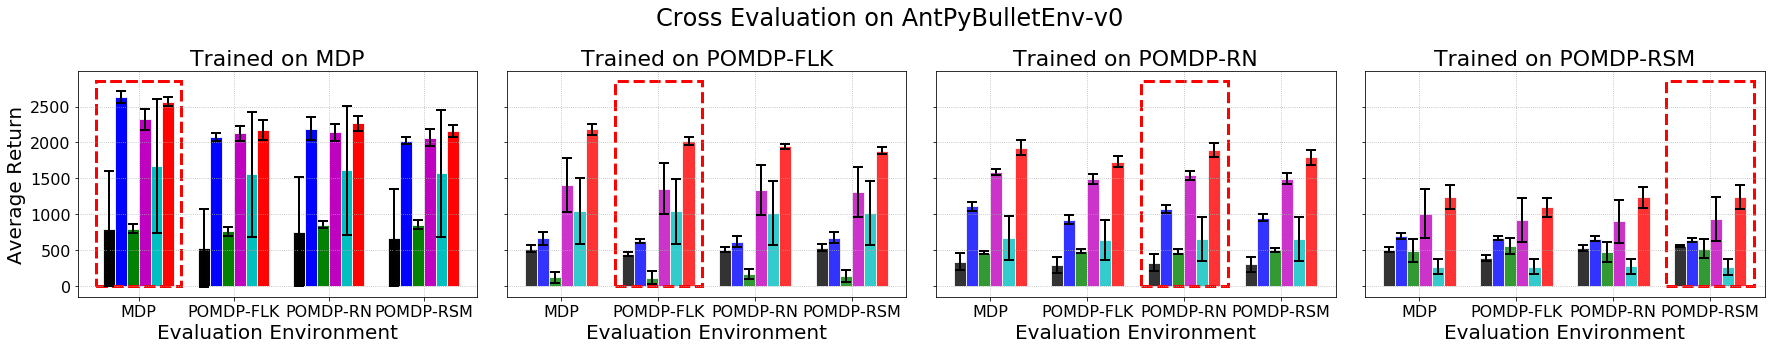

In [482]:
color = {'TD3':'b', 'TD3-OW':'m', 'TD3-OW-AddPastAct':'c', 'SAC':'g', 'DDPG':'k',
         'LSTM-TD3_HistLen0': 'k', 'LSTM-TD3_HistLen1': 'c', 'LSTM-TD3_HistLen3': 'b', 'LSTM-TD3_HistLen5': 'r'}
algs = ['DDPG', 'TD3', 'SAC', 'TD3-OW', 'TD3-OW-AddPastAct']
bar_width = 0.125
std_scale = 0.5
# Baselines
fig, axes = plt.subplots(1, 4, figsize = (25, 5), sharey=True)
for axes_i, original_pomdp_type in enumerate(['POMDP-Flickering-FlickProb-0.2', 'POMDP-RandomNoise-Sigma-0.1', 'POMDP-RandomSensorMissing-MissProb-0.1']):
    # Original MDP
    # Baselines
    for alg_i, alg in enumerate(algs):
        # Calculate mean
        pomdp_evaluation = []
        pomdp_evaluation_mean = []
        pomdp_evaluation_std = []
        for pomdp_type in ['MDP', 'flickering', 'random_noise', 'random_sensor_missing']:
            s_run_evals = []
            for s_run in MDP_to_POMDP[alg]['AntPyBulletEnv-v0'].keys():
                s_run_evals += MDP_to_POMDP[alg]['AntPyBulletEnv-v0'][s_run][pomdp_type]
            pomdp_evaluation.append(s_run_evals)
            pomdp_evaluation_mean.append(np.mean(s_run_evals))
            pomdp_evaluation_std.append(np.std(s_run_evals))

        # Plot
        axes[0].bar(np.arange(0,4) + alg_i*bar_width - 2.5*bar_width, pomdp_evaluation_mean, 
                    yerr = pomdp_evaluation_std, error_kw=dict(lw=2, capsize=5, capthick=2),
                    width = bar_width, label='{}'.format(alg), color=color[alg], alpha=0.8, edgecolor='w')
    # LSTM-TD3
    lstm_td3_pomdp_evaluation = []
    lstm_td3_pomdp_evaluation_mean = []
    lstm_td3_pomdp_evaluation_std = []
    for pomdp_type in ['MDP', 'flickering', 'random_noise', 'random_sensor_missing']:
        s_run_evals = []
        for s_run in lstm_td3_MDP_to_POMDP['LSTM-TD3']['AntPyBulletEnv-v0']['5'].keys():
            s_run_evals += lstm_td3_MDP_to_POMDP['LSTM-TD3']['AntPyBulletEnv-v0']['5'][s_run][pomdp_type]
        lstm_td3_pomdp_evaluation.append(s_run_evals)
        lstm_td3_pomdp_evaluation_mean.append(np.mean(s_run_evals))
        lstm_td3_pomdp_evaluation_std.append(np.std(s_run_evals))

    # Plot
    axes[0].bar(np.arange(0, 4) + 5*bar_width - 2.5*bar_width, lstm_td3_pomdp_evaluation_mean, 
                yerr = lstm_td3_pomdp_evaluation_std, error_kw=dict(lw=2, capsize=5, capthick=2),
             width = bar_width, label='{}'.format('LSTM-TD3'), color='r', alpha=0.8, edgecolor='w')
    axes[0].set_xticks(np.arange(len(['MDP', 'flickering', 'random_noise', 'random_sensor_missing'])))
    axes[0].set_xticklabels(['MDP', 'POMDP-FLK', 'POMDP-RN', 'POMDP-RSM'])
    axes[0].set_xlabel('Evaluation Environment', fontsize=20)
    axes[0].set_ylabel('Average Return', fontsize=20)
    axes[0].set_title('Trained on MDP', fontsize=22)
    axes[0].grid(True, linestyle=':')
    # Create a Rectangle patch
    rect = Rectangle((-0.45,0), 0.9, 2850, linewidth=3, linestyle = 'dashed', edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    axes[0].add_patch(rect)
    
    # Original POMDP
    for alg_i, alg in enumerate(algs):
        # Calculate mean
        pomdp_evaluation = []
        pomdp_evaluation_mean = []
        pomdp_evaluation_std = []
        for pomdp_type in ['MDP', 'flickering', 'random_noise', 'random_sensor_missing']:
            s_run_evals = []
            for s_run in baselines_POMDP_to_MDP[alg]['AntPyBulletEnv-v0'][original_pomdp_type].keys():
                s_run_evals += baselines_POMDP_to_MDP[alg]['AntPyBulletEnv-v0'][original_pomdp_type][s_run][pomdp_type]
            pomdp_evaluation.append(s_run_evals)
            pomdp_evaluation_mean.append(np.mean(s_run_evals))
            pomdp_evaluation_std.append(np.std(s_run_evals)*std_scale)
            
        # Plot
        axes[axes_i+1].bar(np.arange(0,4) + alg_i*bar_width - 2.5*bar_width, pomdp_evaluation_mean, 
                         yerr = pomdp_evaluation_std, error_kw=dict(lw=2, capsize=5, capthick=2),
                         width = bar_width,  label='{}'.format(alg), color=color[alg], alpha=0.8, edgecolor='w')

    # LSTM-TD3
    if 'Flickering' in original_pomdp_type:
        original_pomdp_type = 'flickering'
    if 'RandomNoise' in original_pomdp_type:
        original_pomdp_type = 'random_noise'
    if 'RandomSensorMissing' in original_pomdp_type:
        original_pomdp_type = 'random_sensor_missing'
    lstm_td3_pomdp_evaluation = []
    lstm_td3_pomdp_evaluation_mean = []
    lstm_td3_pomdp_evaluation_std = []
    for pomdp_type in ['MDP', 'flickering', 'random_noise', 'random_sensor_missing']:
        s_run_evals = []
        for s_run in lstm_td3_POMDP_to_MDP['LSTM-TD3']['AntPyBulletEnv-v0'][original_pomdp_type]['5'].keys():
            s_run_evals += lstm_td3_POMDP_to_MDP['LSTM-TD3']['AntPyBulletEnv-v0'][original_pomdp_type]['5'][s_run][pomdp_type]
        lstm_td3_pomdp_evaluation.append(s_run_evals)
        lstm_td3_pomdp_evaluation_mean.append(np.mean(s_run_evals))
        lstm_td3_pomdp_evaluation_std.append(np.std(s_run_evals)*std_scale)
    # Plot
    axes[axes_i+1].bar(np.arange(0, 4) + 5*bar_width - 2.5*bar_width, lstm_td3_pomdp_evaluation_mean, 
                     yerr = lstm_td3_pomdp_evaluation_std, error_kw=dict(lw=2, capsize=5, capthick=2),
                     width = bar_width, label='{}'.format('LSTM-TD3'), color='r', alpha=0.8, edgecolor='w')

    axes[axes_i+1].set_xticks(np.arange(len(['MDP', 'flickering', 'random_noise', 'random_sensor_missing'])))
    axes[axes_i+1].set_xticklabels(['MDP', 'POMDP-FLK', 'POMDP-RN', 'POMDP-RSM'])
    axes[axes_i+1].set_xlabel('Evaluation Environment', fontsize=20)
    if original_pomdp_type == 'flickering':
        original_pomdp_type_ = 'POMDP-FLK'
    if original_pomdp_type == 'random_noise':
        original_pomdp_type_ = 'POMDP-RN'
    if original_pomdp_type == 'random_sensor_missing':
        original_pomdp_type_ = 'POMDP-RSM'
    axes[axes_i+1].set_title('Trained on {}'.format(original_pomdp_type_), fontsize=22)
#     axes.legend(ncol=3, bbox_to_anchor=(1.05, 1))
    axes[axes_i+1].grid(True, linestyle=':')
    
    # Add rectangle
    rect = Rectangle((-0.45+(axes_i+1),0), 0.9, 2850, linewidth=3, linestyle = 'dashed', edgecolor='r', facecolor='none')
    axes[axes_i+1].add_patch(rect)
plt.tight_layout()
fig.suptitle('Cross Evaluation on AntPyBulletEnv-v0', fontsize=24)
fig.subplots_adjust(top=0.8)

fig.savefig("D:\POMDP_Data\images\MDP-to-POMDP_and_POMDP-to-MDP_evaluation.png", bbox_inches='tight')

## LSTM-TD3 Train and Evaluate with Different History Length

### MDP

In [427]:
root_dir = r"D:\POMDP_Data\new_spinup_resumable_MDP_LSTM_TD3"
DEVICE = "cpu"  # "cuda"

lstm_td3_trained_on_MDP_different_hist_len = {}
for sub_dir in os.listdir(root_dir):
    print(sub_dir)
    print(sub_dir.split('_'))
    params = sub_dir.split('_')
    alg_name = params[1]
    task_name = params[2]
    seed = params[4]
    hist_len = params[5]
    if task_name in tasks:
        if alg_name not in lstm_td3_trained_on_MDP_different_hist_len:
            lstm_td3_trained_on_MDP_different_hist_len[alg_name] = {}
        if task_name not in lstm_td3_trained_on_MDP_different_hist_len[alg_name]:
            lstm_td3_trained_on_MDP_different_hist_len[alg_name][task_name] = {}
        if hist_len not in lstm_td3_trained_on_MDP_different_hist_len[alg_name][task_name]:
            lstm_td3_trained_on_MDP_different_hist_len[alg_name][task_name][hist_len] = {}
        if seed not in lstm_td3_trained_on_MDP_different_hist_len[alg_name][task_name][hist_len]:
            lstm_td3_trained_on_MDP_different_hist_len[alg_name][task_name][hist_len][seed] = {}
        #
        print("********************************************************************")
        for exp_run in os.listdir(os.path.join(root_dir, sub_dir)):
            print(exp_run)
            # Load pre-trained model
            config_path = os.path.join(root_dir, sub_dir, exp_run, 'config.json')
            with open(config_path, 'r') as config_file:
                config_json = json.load(config_file)
            # Retrive hyper-parameters
            env_name = config_json['env_name']
            num_test_episodes = config_json['num_test_episodes']
            max_ep_len = config_json['max_ep_len']
            max_hist_len = config_json['max_hist_len']
            
            #
            env = gym.make(task_name)
            obs_dim = env.observation_space.shape[0]
            act_dim = env.action_space.shape[0]
            act_limit = env.action_space.high[0]
            critic_mem_pre_lstm_hid_sizes = config_json['critic_mem_pre_lstm_hid_sizes']
            critic_mem_lstm_hid_sizes = config_json['critic_mem_lstm_hid_sizes']
            critic_mem_after_lstm_hid_size = config_json['critic_mem_after_lstm_hid_size']
            critic_cur_feature_hid_sizes = config_json['critic_cur_feature_hid_sizes']
            critic_post_comb_hid_sizes = config_json['critic_post_comb_hid_sizes']
            critic_mem_gate = config_json['critic_mem_gate']
            critic_mem_gate_before_current_feature_extraction = config_json['critic_mem_gate_before_current_feature_extraction']
            critic_hist_with_past_act = config_json['critic_hist_with_past_act']
            critic_use_hist_mask = config_json['critic_use_hist_mask']
            actor_mem_pre_lstm_hid_sizes = config_json['actor_mem_pre_lstm_hid_sizes']
            actor_mem_lstm_hid_sizes = config_json['actor_mem_lstm_hid_sizes']
            actor_mem_after_lstm_hid_size = config_json['actor_mem_after_lstm_hid_size']
            actor_cur_feature_hid_sizes = config_json['actor_cur_feature_hid_sizes']
            actor_post_comb_hid_sizes = config_json['actor_post_comb_hid_sizes']
            actor_mem_gate = config_json['actor_mem_gate']
            actor_mem_gate_before_current_feature_extraction = config_json['actor_mem_gate_before_current_feature_extraction']
            actor_hist_with_past_act = config_json['actor_hist_with_past_act']
            actor_use_hist_mask = config_json['actor_use_hist_mask']    
            ac = MLPActorCritic(obs_dim, act_dim, act_limit,
                                critic_mem_pre_lstm_hid_sizes=critic_mem_pre_lstm_hid_sizes,
                                critic_mem_lstm_hid_sizes=critic_mem_lstm_hid_sizes,
                                critic_mem_after_lstm_hid_size=critic_mem_after_lstm_hid_size,
                                critic_cur_feature_hid_sizes=critic_cur_feature_hid_sizes,
                                critic_post_comb_hid_sizes=critic_post_comb_hid_sizes,
                                critic_mem_gate=critic_mem_gate,
                                critic_mem_gate_before_current_feature_extraction=critic_mem_gate_before_current_feature_extraction,
                                critic_hist_with_past_act=critic_hist_with_past_act,
                                critic_use_hist_mask=critic_use_hist_mask,
                                actor_mem_pre_lstm_hid_sizes=actor_mem_pre_lstm_hid_sizes,
                                actor_mem_lstm_hid_sizes=actor_mem_lstm_hid_sizes,
                                actor_mem_after_lstm_hid_size=actor_mem_after_lstm_hid_size,
                                actor_cur_feature_hid_sizes=actor_cur_feature_hid_sizes,
                                actor_post_comb_hid_sizes=actor_post_comb_hid_sizes,
                                actor_mem_gate=actor_mem_gate,
                                actor_mem_gate_before_current_feature_extraction=actor_mem_gate_before_current_feature_extraction,
                                actor_hist_with_past_act=actor_hist_with_past_act,
                                actor_use_hist_mask=actor_use_hist_mask)
            # Load model
            resume_checkpoint_path = os.path.join(root_dir, sub_dir, exp_run, "pyt_save")
            checkpoint_files = os.listdir(resume_checkpoint_path)
            latest_model_checkpoint_file_path = os.path.join(resume_checkpoint_path, checkpoint_files[-1])
            
            model_checkpoint = torch.load(latest_model_checkpoint_file_path)
            ac.load_state_dict(model_checkpoint['ac_state_dict'])
            
            # print(ac)

            
            # Not include POMDP-RV, because POMDP-RV changed the dimension of observation.
            for eval_hist_len in [0, 1, 3, 5, 8, 10, 15]:
                print("\t{}".format(eval_hist_len))
                lstm_td3_trained_on_MDP_different_hist_len[alg_name][task_name][hist_len][seed]['{}'.format(eval_hist_len)] = []
                
                
                # Evaluation
                for j in range(num_test_episodes):
                    # Reset environment
                    o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
                    if eval_hist_len > 0:
                        o_buff = np.zeros([eval_hist_len, obs_dim])
                        a_buff = np.zeros([eval_hist_len, act_dim])
                        o_buff[0, :] = o
                        o_buff_len = 0
                    else:
                        o_buff = np.zeros([1, obs_dim])
                        a_buff = np.zeros([1, act_dim])
                        o_buff_len = 0

                    # Interact
                    while not(d or (ep_len == max_ep_len)):
                        # Take deterministic actions at test time 
                        h_o = torch.tensor(o_buff).view(1, o_buff.shape[0], o_buff.shape[1]).float().to(DEVICE)
                        h_a = torch.tensor(a_buff).view(1, a_buff.shape[0], a_buff.shape[1]).float().to(DEVICE)
                        h_l = torch.tensor([o_buff_len]).float().to(DEVICE)
                        a = ac.act(torch.as_tensor(o, dtype=torch.float32).view(1, -1).to(DEVICE),
                                   h_o, h_a, h_l).reshape(act_dim)
                        
                        o2, r, d, _ = test_env.step(a)
                        ep_ret += r
                        ep_len += 1

                        # Add short history
                        if max_hist_len != 0:
                            if o_buff_len == eval_hist_len:
                                o_buff[:eval_hist_len - 1] = o_buff[1:]
                                a_buff[:eval_hist_len - 1] = a_buff[1:]
                                o_buff[eval_hist_len - 1] = list(o)
                                a_buff[eval_hist_len - 1] = list(a)
                            else:
                                o_buff[o_buff_len + 1 - 1] = list(o)
                                a_buff[o_buff_len + 1 - 1] = list(a)
                                o_buff_len += 1
                        o = o2
                    print('\t  Episod-{}: Ep_Return={}, Ep_Len={}'.format(j, ep_ret, ep_len))
                    lstm_td3_trained_on_MDP_different_hist_len[alg_name][task_name][hist_len][seed]['{}'.format(eval_hist_len)].append(ep_ret)


2021-01-22_LSTM-TD3_AntPyBulletEnv-v0_False_0_0
['2021-01-22', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'False', '0', '0']
********************************************************************
2021-01-22_21-34-24-LSTM-TD3_AntPyBulletEnv-v0_False_0_0_s0
WalkerBase::__init__
	0
	  Episod-0: Ep_Return=2010.2205942756732, Ep_Len=1000
	  Episod-1: Ep_Return=1924.8957066658018, Ep_Len=1000
	  Episod-2: Ep_Return=2026.1937346826876, Ep_Len=1000
	  Episod-3: Ep_Return=2065.735767228102, Ep_Len=1000
	  Episod-4: Ep_Return=1945.350584631377, Ep_Len=1000
	  Episod-5: Ep_Return=2040.9784977124573, Ep_Len=1000
	  Episod-6: Ep_Return=2024.1605840980335, Ep_Len=1000
	  Episod-7: Ep_Return=1992.329139570821, Ep_Len=1000
	  Episod-8: Ep_Return=2055.4860585104593, Ep_Len=1000
	  Episod-9: Ep_Return=2033.2478088742228, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1955.2780427704765, Ep_Len=1000
	  Episod-1: Ep_Return=2149.2910889066766, Ep_Len=1000
	  Episod-2: Ep_Return=2010.6195128319039, Ep_Len=1000
	  Episod-3: Ep_R

	  Episod-0: Ep_Return=1995.1065153248048, Ep_Len=1000
	  Episod-1: Ep_Return=1916.9952817821707, Ep_Len=1000
	  Episod-2: Ep_Return=2007.8151136164818, Ep_Len=1000
	  Episod-3: Ep_Return=2064.012190058516, Ep_Len=1000
	  Episod-4: Ep_Return=2025.4647151158388, Ep_Len=1000
	  Episod-5: Ep_Return=1973.2372167794915, Ep_Len=1000
	  Episod-6: Ep_Return=2060.527791595713, Ep_Len=1000
	  Episod-7: Ep_Return=1958.1139430223152, Ep_Len=1000
	  Episod-8: Ep_Return=1882.2378152888343, Ep_Len=1000
	  Episod-9: Ep_Return=2056.4619391680153, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1950.568931197589, Ep_Len=1000
	  Episod-1: Ep_Return=1966.0152242448385, Ep_Len=1000
	  Episod-2: Ep_Return=1938.9486553380334, Ep_Len=1000
	  Episod-3: Ep_Return=1901.9147855074364, Ep_Len=1000
	  Episod-4: Ep_Return=2099.408151645284, Ep_Len=1000
	  Episod-5: Ep_Return=1874.148782741245, Ep_Len=1000
	  Episod-6: Ep_Return=2079.9120823074213, Ep_Len=1000
	  Episod-7: Ep_Return=1967.2447620517269, Ep_Len=1000
	  Episod-8:

	  Episod-0: Ep_Return=1842.6358375220893, Ep_Len=1000
	  Episod-1: Ep_Return=1770.445405505251, Ep_Len=1000
	  Episod-2: Ep_Return=1821.1399302699351, Ep_Len=1000
	  Episod-3: Ep_Return=1907.2881051839204, Ep_Len=1000
	  Episod-4: Ep_Return=1947.1325725007025, Ep_Len=1000
	  Episod-5: Ep_Return=1950.686620444103, Ep_Len=1000
	  Episod-6: Ep_Return=1946.4050882069212, Ep_Len=1000
	  Episod-7: Ep_Return=1725.63884107597, Ep_Len=1000
	  Episod-8: Ep_Return=1891.8415794869502, Ep_Len=1000
	  Episod-9: Ep_Return=1833.2161040128778, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1767.182050920756, Ep_Len=1000
	  Episod-1: Ep_Return=1860.7444495075508, Ep_Len=1000
	  Episod-2: Ep_Return=1885.5800981071066, Ep_Len=1000
	  Episod-3: Ep_Return=1755.19586370146, Ep_Len=1000
	  Episod-4: Ep_Return=1985.2219602878772, Ep_Len=1000
	  Episod-5: Ep_Return=1966.7239758820335, Ep_Len=1000
	  Episod-6: Ep_Return=2035.7899679781146, Ep_Len=1000
	  Episod-7: Ep_Return=1822.5525616993734, Ep_Len=1000
	  Episod-8: E

	  Episod-0: Ep_Return=895.6484785836511, Ep_Len=1000
	  Episod-1: Ep_Return=532.2754722064736, Ep_Len=1000
	  Episod-2: Ep_Return=1561.833171952048, Ep_Len=1000
	  Episod-3: Ep_Return=1619.1670138970155, Ep_Len=1000
	  Episod-4: Ep_Return=1461.2212992593688, Ep_Len=1000
	  Episod-5: Ep_Return=1648.2226491702168, Ep_Len=1000
	  Episod-6: Ep_Return=1570.621623893472, Ep_Len=1000
	  Episod-7: Ep_Return=876.2061225273803, Ep_Len=1000
	  Episod-8: Ep_Return=1717.638755205015, Ep_Len=1000
	  Episod-9: Ep_Return=1666.072975611241, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1672.9597417131051, Ep_Len=1000
	  Episod-1: Ep_Return=918.043750002405, Ep_Len=1000
	  Episod-2: Ep_Return=1625.6296647650142, Ep_Len=1000
	  Episod-3: Ep_Return=1763.1114545061039, Ep_Len=1000
	  Episod-4: Ep_Return=890.3599997164845, Ep_Len=1000
	  Episod-5: Ep_Return=1712.049220308903, Ep_Len=1000
	  Episod-6: Ep_Return=1595.27005921611, Ep_Len=1000
	  Episod-7: Ep_Return=716.384770238625, Ep_Len=1000
	  Episod-8: Ep_Return

	  Episod-0: Ep_Return=1388.9039103878, Ep_Len=1000
	  Episod-1: Ep_Return=1476.504656916449, Ep_Len=1000
	  Episod-2: Ep_Return=1498.1841153267603, Ep_Len=1000
	  Episod-3: Ep_Return=1448.2604669536308, Ep_Len=1000
	  Episod-4: Ep_Return=1387.3434226536076, Ep_Len=1000
	  Episod-5: Ep_Return=1501.5012130551352, Ep_Len=1000
	  Episod-6: Ep_Return=1540.4170627578849, Ep_Len=1000
	  Episod-7: Ep_Return=1346.4577649313128, Ep_Len=1000
	  Episod-8: Ep_Return=1420.5002767693618, Ep_Len=1000
	  Episod-9: Ep_Return=1447.3148268443515, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1506.6130571704446, Ep_Len=1000
	  Episod-1: Ep_Return=1307.1689201038337, Ep_Len=1000
	  Episod-2: Ep_Return=1507.3258291686518, Ep_Len=1000
	  Episod-3: Ep_Return=1273.5650025701975, Ep_Len=1000
	  Episod-4: Ep_Return=1376.2825382440092, Ep_Len=1000
	  Episod-5: Ep_Return=1425.9366943878372, Ep_Len=1000
	  Episod-6: Ep_Return=1579.0342370823412, Ep_Len=1000
	  Episod-7: Ep_Return=1409.2598233398471, Ep_Len=1000
	  Episod-8

	  Episod-0: Ep_Return=380.9938084162133, Ep_Len=1000
	  Episod-1: Ep_Return=439.308735968953, Ep_Len=1000
	  Episod-2: Ep_Return=313.717218213658, Ep_Len=1000
	  Episod-3: Ep_Return=358.83288797434625, Ep_Len=1000
	  Episod-4: Ep_Return=340.7797459937248, Ep_Len=1000
	  Episod-5: Ep_Return=326.5881391084754, Ep_Len=1000
	  Episod-6: Ep_Return=362.92999795789683, Ep_Len=1000
	  Episod-7: Ep_Return=317.91075357396807, Ep_Len=1000
	  Episod-8: Ep_Return=436.3840904737955, Ep_Len=1000
	  Episod-9: Ep_Return=312.579029183259, Ep_Len=1000
	1
	  Episod-0: Ep_Return=279.652366290656, Ep_Len=1000
	  Episod-1: Ep_Return=363.5529483212044, Ep_Len=1000
	  Episod-2: Ep_Return=464.70656646264024, Ep_Len=1000
	  Episod-3: Ep_Return=368.94400574874174, Ep_Len=1000
	  Episod-4: Ep_Return=323.50822316980697, Ep_Len=1000
	  Episod-5: Ep_Return=363.444273864641, Ep_Len=1000
	  Episod-6: Ep_Return=415.0122293051713, Ep_Len=1000
	  Episod-7: Ep_Return=404.2729800336717, Ep_Len=1000
	  Episod-8: Ep_Return=3

	  Episod-0: Ep_Return=1352.824123147793, Ep_Len=1000
	  Episod-1: Ep_Return=1209.4171957686726, Ep_Len=1000
	  Episod-2: Ep_Return=1176.4745022421869, Ep_Len=1000
	  Episod-3: Ep_Return=1009.1415315417793, Ep_Len=1000
	  Episod-4: Ep_Return=1319.2186301975655, Ep_Len=1000
	  Episod-5: Ep_Return=671.9981994445013, Ep_Len=1000
	  Episod-6: Ep_Return=693.3467343414968, Ep_Len=1000
	  Episod-7: Ep_Return=810.4461324700587, Ep_Len=1000
	  Episod-8: Ep_Return=601.9653190888367, Ep_Len=1000
	  Episod-9: Ep_Return=919.3407006100725, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1029.8001310499187, Ep_Len=1000
	  Episod-1: Ep_Return=964.5155986197744, Ep_Len=1000
	  Episod-2: Ep_Return=1048.3313969981934, Ep_Len=1000
	  Episod-3: Ep_Return=1266.1566040656671, Ep_Len=1000
	  Episod-4: Ep_Return=629.0177669881249, Ep_Len=1000
	  Episod-5: Ep_Return=1296.8385392384007, Ep_Len=1000
	  Episod-6: Ep_Return=1110.4799963493824, Ep_Len=1000
	  Episod-7: Ep_Return=1250.3533815611736, Ep_Len=1000
	  Episod-8: Ep

	  Episod-0: Ep_Return=1901.815100599502, Ep_Len=1000
	  Episod-1: Ep_Return=1736.477520894107, Ep_Len=1000
	  Episod-2: Ep_Return=515.6045614733988, Ep_Len=1000
	  Episod-3: Ep_Return=1965.4731967409775, Ep_Len=1000
	  Episod-4: Ep_Return=1898.5054654733672, Ep_Len=1000
	  Episod-5: Ep_Return=1925.1405835253065, Ep_Len=1000
	  Episod-6: Ep_Return=1905.2660999081804, Ep_Len=1000
	  Episod-7: Ep_Return=1858.8313400697373, Ep_Len=1000
	  Episod-8: Ep_Return=1823.2538827491994, Ep_Len=1000
	  Episod-9: Ep_Return=1981.182794534466, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1901.5429769384796, Ep_Len=1000
	  Episod-1: Ep_Return=1882.71781595577, Ep_Len=1000
	  Episod-2: Ep_Return=1736.1640230503872, Ep_Len=1000
	  Episod-3: Ep_Return=1764.33885929374, Ep_Len=1000
	  Episod-4: Ep_Return=1950.4467618454255, Ep_Len=1000
	  Episod-5: Ep_Return=1938.031590696653, Ep_Len=1000
	  Episod-6: Ep_Return=1511.9626399617352, Ep_Len=1000
	  Episod-7: Ep_Return=1893.7070254287155, Ep_Len=1000
	  Episod-8: Ep_

### POMDP

In [369]:

root_dir = r"D:\POMDP_Data\new_spinup_resumable_POMDP_LSTM_TD3"
DEVICE = "cpu"  # "cuda"

lstm_td3_different_hist_len = {}
for sub_dir in os.listdir(root_dir):
    print(sub_dir)
    print(sub_dir.split('_'))
    params = sub_dir.split('_')
    alg_name = params[1]
    task_name = params[2]
    pomdp_hyperparam = '_'.join(params[4:-2])
    seed = params[-2]
    hist_len = params[-1]
    
    if task_name in tasks:
        if alg_name not in lstm_td3_different_hist_len:
            lstm_td3_different_hist_len[alg_name] = {}
        if task_name not in lstm_td3_different_hist_len[alg_name]:
            lstm_td3_different_hist_len[alg_name][task_name] = {}
        if pomdp_hyperparam not in lstm_td3_different_hist_len[alg_name][task_name]:
            lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam] = {}
        if hist_len not in lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam]:
            lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam][hist_len] = {}
        if seed not in lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam][hist_len]:
            lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam][hist_len][seed] = {}
        #
        print("********************************************************************")
        for exp_run in os.listdir(os.path.join(root_dir, sub_dir)):
            print(exp_run)
            # Load pre-trained model
            config_path = os.path.join(root_dir, sub_dir, exp_run, 'config.json')
            with open(config_path, 'r') as config_file:
                config_json = json.load(config_file)
            # Retrive hyper-parameters
            env_name = config_json['env_name']
            num_test_episodes = config_json['num_test_episodes']
            max_ep_len = config_json['max_ep_len']
            max_hist_len = config_json['max_hist_len']
            
            # Create environment
            if config_json['partially_observable']:
                env = POMDPWrapper(env_name, config_json['pomdp_type'], 
                                   config_json['flicker_prob'], config_json['random_noise_sigma'], 
                                   config_json['random_sensor_missing_prob'])
            else:
                env = gym.make(env_name)
            
            obs_dim = env.observation_space.shape[0]
            act_dim = env.action_space.shape[0]
            act_limit = env.action_space.high[0]
            
            critic_mem_pre_lstm_hid_sizes = config_json['critic_mem_pre_lstm_hid_sizes']
            critic_mem_lstm_hid_sizes = config_json['critic_mem_lstm_hid_sizes']
            critic_mem_after_lstm_hid_size = config_json['critic_mem_after_lstm_hid_size']
            critic_cur_feature_hid_sizes = config_json['critic_cur_feature_hid_sizes']
            critic_post_comb_hid_sizes = config_json['critic_post_comb_hid_sizes']
            critic_mem_gate = config_json['critic_mem_gate']
            critic_mem_gate_before_current_feature_extraction = config_json['critic_mem_gate_before_current_feature_extraction']
            critic_hist_with_past_act = config_json['critic_hist_with_past_act']
            critic_use_hist_mask = config_json['critic_use_hist_mask']
            actor_mem_pre_lstm_hid_sizes = config_json['actor_mem_pre_lstm_hid_sizes']
            actor_mem_lstm_hid_sizes = config_json['actor_mem_lstm_hid_sizes']
            actor_mem_after_lstm_hid_size = config_json['actor_mem_after_lstm_hid_size']
            actor_cur_feature_hid_sizes = config_json['actor_cur_feature_hid_sizes']
            actor_post_comb_hid_sizes = config_json['actor_post_comb_hid_sizes']
            actor_mem_gate = config_json['actor_mem_gate']
            actor_mem_gate_before_current_feature_extraction = config_json['actor_mem_gate_before_current_feature_extraction']
            actor_hist_with_past_act = config_json['actor_hist_with_past_act']
            actor_use_hist_mask = config_json['actor_use_hist_mask']    
            ac = MLPActorCritic(obs_dim, act_dim, act_limit,
                                critic_mem_pre_lstm_hid_sizes=critic_mem_pre_lstm_hid_sizes,
                                critic_mem_lstm_hid_sizes=critic_mem_lstm_hid_sizes,
                                critic_mem_after_lstm_hid_size=critic_mem_after_lstm_hid_size,
                                critic_cur_feature_hid_sizes=critic_cur_feature_hid_sizes,
                                critic_post_comb_hid_sizes=critic_post_comb_hid_sizes,
                                critic_mem_gate=critic_mem_gate,
                                critic_mem_gate_before_current_feature_extraction=critic_mem_gate_before_current_feature_extraction,
                                critic_hist_with_past_act=critic_hist_with_past_act,
                                critic_use_hist_mask=critic_use_hist_mask,
                                actor_mem_pre_lstm_hid_sizes=actor_mem_pre_lstm_hid_sizes,
                                actor_mem_lstm_hid_sizes=actor_mem_lstm_hid_sizes,
                                actor_mem_after_lstm_hid_size=actor_mem_after_lstm_hid_size,
                                actor_cur_feature_hid_sizes=actor_cur_feature_hid_sizes,
                                actor_post_comb_hid_sizes=actor_post_comb_hid_sizes,
                                actor_mem_gate=actor_mem_gate,
                                actor_mem_gate_before_current_feature_extraction=actor_mem_gate_before_current_feature_extraction,
                                actor_hist_with_past_act=actor_hist_with_past_act,
                                actor_use_hist_mask=actor_use_hist_mask)
            # Load model
            resume_checkpoint_path = os.path.join(root_dir, sub_dir, exp_run, "pyt_save")
            checkpoint_files = os.listdir(resume_checkpoint_path)
            latest_model_checkpoint_file_path = os.path.join(resume_checkpoint_path, checkpoint_files[-1])
            
            model_checkpoint = torch.load(latest_model_checkpoint_file_path)
            ac.load_state_dict(model_checkpoint['ac_state_dict'])
            
            # print(ac)
            
            # Evaluate on the same environment, but with different history length.
            for eval_hist_len in [0, 1, 3, 5, 8, 10, 15]:
                print("\t{}".format(eval_hist_len))
                lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam][hist_len][seed]['{}'.format(eval_hist_len)] = []
                
                # Evaluation
                for j in range(num_test_episodes):
                    # Reset environment
                    o, d, ep_ret, ep_len = env.reset(), False, 0, 0
                    if eval_hist_len > 0:
                        o_buff = np.zeros([eval_hist_len, obs_dim])
                        a_buff = np.zeros([eval_hist_len, act_dim])
                        o_buff[0, :] = o
                        o_buff_len = 0
                    else:
                        o_buff = np.zeros([1, obs_dim])
                        a_buff = np.zeros([1, act_dim])
                        o_buff_len = 0

                    # Interact
                    while not(d or (ep_len == max_ep_len)):
                        # Take deterministic actions at test time 
                        h_o = torch.tensor(o_buff).view(1, o_buff.shape[0], o_buff.shape[1]).float().to(DEVICE)
                        h_a = torch.tensor(a_buff).view(1, a_buff.shape[0], a_buff.shape[1]).float().to(DEVICE)
                        h_l = torch.tensor([o_buff_len]).float().to(DEVICE)
                        a = ac.act(torch.as_tensor(o, dtype=torch.float32).view(1, -1).to(DEVICE),
                                   h_o, h_a, h_l).reshape(act_dim)
                        
                        o2, r, d, _ = env.step(a)
                        ep_ret += r
                        ep_len += 1

                        # Add short history
                        if eval_hist_len != 0:
                            if o_buff_len == eval_hist_len:
                                o_buff[:eval_hist_len - 1] = o_buff[1:]
                                a_buff[:eval_hist_len - 1] = a_buff[1:]
                                o_buff[eval_hist_len - 1] = list(o)
                                a_buff[eval_hist_len - 1] = list(a)
                            else:
                                o_buff[o_buff_len + 1 - 1] = list(o)
                                a_buff[o_buff_len + 1 - 1] = list(a)
                                o_buff_len += 1
                        o = o2
                    print('\t  Episod-{}: Ep_Return={}, Ep_Len={}'.format(j, ep_ret, ep_len))
                    lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam][hist_len][seed]['{}'.format(eval_hist_len)].append(ep_ret)

2021-01-22_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_0
['2021-01-22', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '0', '0']
********************************************************************
2021-01-22_22-45-30-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_0_s0
WalkerBase::__init__
	0
options= 
	  Episod-0: Ep_Return=683.3195551060422, Ep_Len=1000
	  Episod-1: Ep_Return=658.343928481871, Ep_Len=1000
	  Episod-2: Ep_Return=562.1863115855616, Ep_Len=1000
	  Episod-3: Ep_Return=730.1319758924069, Ep_Len=1000
	  Episod-4: Ep_Return=567.6036346683248, Ep_Len=1000
	  Episod-5: Ep_Return=635.3525965094702, Ep_Len=1000
	  Episod-6: Ep_Return=600.6378107450779, Ep_Len=1000
	  Episod-7: Ep_Return=572.0976491683874, Ep_Len=1000
	  Episod-8: Ep_Return=656.8467463905081, Ep_Len=1000
	  Episod-9: Ep_Return=755.724065436991, Ep_Len=1000
	1
	  Episod-0: Ep_Return=665.369653829179, Ep_Len=1000
	  Episod-1: Ep_Return=577.0146326335704, Ep_Len=1000
	  Episod-2: Ep_Return=683.0624537840849,

	  Episod-0: Ep_Return=1531.6357055326391, Ep_Len=1000
	  Episod-1: Ep_Return=1633.795057959015, Ep_Len=1000
	  Episod-2: Ep_Return=1613.2092745850423, Ep_Len=1000
	  Episod-3: Ep_Return=1609.7646427906348, Ep_Len=1000
	  Episod-4: Ep_Return=1601.4183224953338, Ep_Len=1000
	  Episod-5: Ep_Return=1667.6185299125345, Ep_Len=1000
	  Episod-6: Ep_Return=1574.3245165877115, Ep_Len=1000
	  Episod-7: Ep_Return=1582.1343113356256, Ep_Len=1000
	  Episod-8: Ep_Return=1689.7242598599084, Ep_Len=1000
	  Episod-9: Ep_Return=1548.6784330092746, Ep_Len=1000
	1
	  Episod-0: Ep_Return=2061.729156979706, Ep_Len=1000
	  Episod-1: Ep_Return=2057.6487544409656, Ep_Len=1000
	  Episod-2: Ep_Return=1949.5131365644038, Ep_Len=1000
	  Episod-3: Ep_Return=2038.3895005439329, Ep_Len=1000
	  Episod-4: Ep_Return=2068.0459074370297, Ep_Len=1000
	  Episod-5: Ep_Return=2074.3069251451175, Ep_Len=1000
	  Episod-6: Ep_Return=2046.0572989689956, Ep_Len=1000
	  Episod-7: Ep_Return=2109.949622685602, Ep_Len=1000
	  Episod-

	  Episod-0: Ep_Return=374.13791668723417, Ep_Len=563
	  Episod-1: Ep_Return=541.4033915024758, Ep_Len=1000
	  Episod-2: Ep_Return=410.8562399943488, Ep_Len=693
	  Episod-3: Ep_Return=565.2482970220295, Ep_Len=1000
	  Episod-4: Ep_Return=502.5762251120612, Ep_Len=860
	  Episod-5: Ep_Return=268.6701218326402, Ep_Len=1000
	  Episod-6: Ep_Return=183.38337667690942, Ep_Len=281
	  Episod-7: Ep_Return=495.8596543966593, Ep_Len=1000
	  Episod-8: Ep_Return=361.92384182168485, Ep_Len=1000
	  Episod-9: Ep_Return=602.147590784463, Ep_Len=918
	1
	  Episod-0: Ep_Return=656.1116566807729, Ep_Len=1000
	  Episod-1: Ep_Return=627.3256596885274, Ep_Len=1000
	  Episod-2: Ep_Return=426.3420415006583, Ep_Len=693
	  Episod-3: Ep_Return=528.3547257355054, Ep_Len=1000
	  Episod-4: Ep_Return=120.98557225109109, Ep_Len=273
	  Episod-5: Ep_Return=213.98571673105764, Ep_Len=328
	  Episod-6: Ep_Return=60.39609694332029, Ep_Len=140
	  Episod-7: Ep_Return=378.51941127151485, Ep_Len=571
	  Episod-8: Ep_Return=406.514

	  Episod-0: Ep_Return=1469.795769382224, Ep_Len=1000
	  Episod-1: Ep_Return=1546.3390724482476, Ep_Len=1000
	  Episod-2: Ep_Return=1533.3633291391566, Ep_Len=1000
	  Episod-3: Ep_Return=1564.6587801233538, Ep_Len=1000
	  Episod-4: Ep_Return=1595.317323824949, Ep_Len=1000
	  Episod-5: Ep_Return=1553.2405575602706, Ep_Len=1000
	  Episod-6: Ep_Return=1552.7390452136503, Ep_Len=1000
	  Episod-7: Ep_Return=1602.2651212779374, Ep_Len=1000
	  Episod-8: Ep_Return=1629.0765418365083, Ep_Len=1000
	  Episod-9: Ep_Return=1604.227219498539, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1790.031032022043, Ep_Len=1000
	  Episod-1: Ep_Return=1734.2441843436795, Ep_Len=1000
	  Episod-2: Ep_Return=1750.4031333885819, Ep_Len=1000
	  Episod-3: Ep_Return=1686.7952412776506, Ep_Len=1000
	  Episod-4: Ep_Return=1401.4775492191359, Ep_Len=1000
	  Episod-5: Ep_Return=1719.699111885738, Ep_Len=1000
	  Episod-6: Ep_Return=1751.7977398664402, Ep_Len=1000
	  Episod-7: Ep_Return=1728.2438955762525, Ep_Len=1000
	  Episod-8:

	  Episod-0: Ep_Return=417.37900009954166, Ep_Len=1000
	  Episod-1: Ep_Return=369.8119710716379, Ep_Len=1000
	  Episod-2: Ep_Return=437.14891695089494, Ep_Len=1000
	  Episod-3: Ep_Return=492.53287015498813, Ep_Len=1000
	  Episod-4: Ep_Return=718.9248384093213, Ep_Len=1000
	  Episod-5: Ep_Return=528.7158805675036, Ep_Len=1000
	  Episod-6: Ep_Return=359.8320600192244, Ep_Len=1000
	  Episod-7: Ep_Return=510.924275415969, Ep_Len=1000
	  Episod-8: Ep_Return=500.5802414330634, Ep_Len=1000
	  Episod-9: Ep_Return=416.18378685285063, Ep_Len=1000
	1
	  Episod-0: Ep_Return=461.0674405792181, Ep_Len=1000
	  Episod-1: Ep_Return=521.3302667754813, Ep_Len=1000
	  Episod-2: Ep_Return=456.4605713824656, Ep_Len=1000
	  Episod-3: Ep_Return=430.1495296272156, Ep_Len=1000
	  Episod-4: Ep_Return=363.98654869521386, Ep_Len=1000
	  Episod-5: Ep_Return=473.76827538757055, Ep_Len=1000
	  Episod-6: Ep_Return=639.6549950564569, Ep_Len=1000
	  Episod-7: Ep_Return=370.69695624378335, Ep_Len=1000
	  Episod-8: Ep_Ret

	  Episod-0: Ep_Return=1100.3466558807459, Ep_Len=1000
	  Episod-1: Ep_Return=890.5184662311567, Ep_Len=1000
	  Episod-2: Ep_Return=1070.9906647978344, Ep_Len=1000
	  Episod-3: Ep_Return=1019.1128709506663, Ep_Len=1000
	  Episod-4: Ep_Return=995.463963020789, Ep_Len=1000
	  Episod-5: Ep_Return=958.916150051001, Ep_Len=1000
	  Episod-6: Ep_Return=587.0252870252485, Ep_Len=1000
	  Episod-7: Ep_Return=972.2508487284316, Ep_Len=1000
	  Episod-8: Ep_Return=848.7708343726006, Ep_Len=1000
	  Episod-9: Ep_Return=1005.4825588342827, Ep_Len=1000
	1
	  Episod-0: Ep_Return=2205.247911214438, Ep_Len=1000
	  Episod-1: Ep_Return=2238.0685459826673, Ep_Len=1000
	  Episod-2: Ep_Return=2103.5256591834764, Ep_Len=1000
	  Episod-3: Ep_Return=1899.6498337661603, Ep_Len=1000
	  Episod-4: Ep_Return=1997.320339244523, Ep_Len=1000
	  Episod-5: Ep_Return=1953.7684838616156, Ep_Len=1000
	  Episod-6: Ep_Return=2030.4274192683768, Ep_Len=1000
	  Episod-7: Ep_Return=1937.3538067202448, Ep_Len=1000
	  Episod-8: Ep_R

	  Episod-0: Ep_Return=623.7586476396987, Ep_Len=1000
	  Episod-1: Ep_Return=625.5971966702037, Ep_Len=1000
	  Episod-2: Ep_Return=637.4903506123995, Ep_Len=1000
	  Episod-3: Ep_Return=710.3847550285761, Ep_Len=1000
	  Episod-4: Ep_Return=624.2030674371961, Ep_Len=1000
	  Episod-5: Ep_Return=669.6873094432513, Ep_Len=1000
	  Episod-6: Ep_Return=626.6742214448465, Ep_Len=1000
	  Episod-7: Ep_Return=582.1016499170926, Ep_Len=1000
	  Episod-8: Ep_Return=801.8399344126024, Ep_Len=1000
	  Episod-9: Ep_Return=673.6616272528663, Ep_Len=1000
	1
	  Episod-0: Ep_Return=621.026975966507, Ep_Len=1000
	  Episod-1: Ep_Return=668.8233174468858, Ep_Len=1000
	  Episod-2: Ep_Return=623.5469525558117, Ep_Len=1000
	  Episod-3: Ep_Return=628.8400103133039, Ep_Len=1000
	  Episod-4: Ep_Return=622.9005762173825, Ep_Len=1000
	  Episod-5: Ep_Return=735.0720077390788, Ep_Len=1000
	  Episod-6: Ep_Return=737.7283947495247, Ep_Len=1000
	  Episod-7: Ep_Return=573.2061578388711, Ep_Len=1000
	  Episod-8: Ep_Return=656

	  Episod-0: Ep_Return=2042.6420394153865, Ep_Len=1000
	  Episod-1: Ep_Return=2149.2294666191838, Ep_Len=1000
	  Episod-2: Ep_Return=2031.8212271173693, Ep_Len=1000
	  Episod-3: Ep_Return=1994.7130845951508, Ep_Len=1000
	  Episod-4: Ep_Return=1874.8929077696898, Ep_Len=1000
	  Episod-5: Ep_Return=1640.981765589837, Ep_Len=1000
	  Episod-6: Ep_Return=1761.6309657363838, Ep_Len=1000
	  Episod-7: Ep_Return=1981.3552244912566, Ep_Len=1000
	  Episod-8: Ep_Return=1985.066181823778, Ep_Len=1000
	  Episod-9: Ep_Return=1888.9664247077953, Ep_Len=1000
	1
	  Episod-0: Ep_Return=2317.456978519428, Ep_Len=1000
	  Episod-1: Ep_Return=2281.763221316424, Ep_Len=1000
	  Episod-2: Ep_Return=2244.6990744391614, Ep_Len=1000
	  Episod-3: Ep_Return=2320.1932291200837, Ep_Len=1000
	  Episod-4: Ep_Return=2296.5802922030052, Ep_Len=1000
	  Episod-5: Ep_Return=2344.2755272479567, Ep_Len=1000
	  Episod-6: Ep_Return=2321.40226893699, Ep_Len=1000
	  Episod-7: Ep_Return=2323.4985975490845, Ep_Len=1000
	  Episod-8: 

	  Episod-0: Ep_Return=821.1323596984018, Ep_Len=1000
	  Episod-1: Ep_Return=821.814926582402, Ep_Len=1000
	  Episod-2: Ep_Return=846.1385780596535, Ep_Len=1000
	  Episod-3: Ep_Return=821.2619392061368, Ep_Len=1000
	  Episod-4: Ep_Return=792.4960011365151, Ep_Len=1000
	  Episod-5: Ep_Return=842.9157005655139, Ep_Len=1000
	  Episod-6: Ep_Return=803.4204277970842, Ep_Len=1000
	  Episod-7: Ep_Return=845.6801817097123, Ep_Len=1000
	  Episod-8: Ep_Return=821.6483779094525, Ep_Len=1000
	  Episod-9: Ep_Return=846.4012324498531, Ep_Len=1000
	1
	  Episod-0: Ep_Return=825.7057572528912, Ep_Len=1000
	  Episod-1: Ep_Return=824.9271600053221, Ep_Len=1000
	  Episod-2: Ep_Return=846.7140149484576, Ep_Len=1000
	  Episod-3: Ep_Return=842.2769941074419, Ep_Len=1000
	  Episod-4: Ep_Return=813.2500382003, Ep_Len=1000
	  Episod-5: Ep_Return=821.8317024025542, Ep_Len=1000
	  Episod-6: Ep_Return=840.7674168759115, Ep_Len=1000
	  Episod-7: Ep_Return=890.6191718683007, Ep_Len=1000
	  Episod-8: Ep_Return=818.01

	  Episod-0: Ep_Return=1462.9959785888707, Ep_Len=1000
	  Episod-1: Ep_Return=1508.5538844426417, Ep_Len=1000
	  Episod-2: Ep_Return=1539.8074775007078, Ep_Len=1000
	  Episod-3: Ep_Return=1497.0863933917592, Ep_Len=1000
	  Episod-4: Ep_Return=1518.7554749146375, Ep_Len=1000
	  Episod-5: Ep_Return=1386.1847517764281, Ep_Len=1000
	  Episod-6: Ep_Return=1524.0083976180604, Ep_Len=1000
	  Episod-7: Ep_Return=1550.0924461192872, Ep_Len=1000
	  Episod-8: Ep_Return=1527.3327717302805, Ep_Len=1000
	  Episod-9: Ep_Return=1493.609601053571, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1091.2100242815416, Ep_Len=1000
	  Episod-1: Ep_Return=1044.099978421918, Ep_Len=1000
	  Episod-2: Ep_Return=1106.577931346465, Ep_Len=1000
	  Episod-3: Ep_Return=1097.1553250650245, Ep_Len=1000
	  Episod-4: Ep_Return=1055.3010694938182, Ep_Len=1000
	  Episod-5: Ep_Return=1015.0037104905191, Ep_Len=1000
	  Episod-6: Ep_Return=1065.8910640781178, Ep_Len=1000
	  Episod-7: Ep_Return=1088.3814528411394, Ep_Len=1000
	  Episod-

	  Episod-0: Ep_Return=1137.7321106846373, Ep_Len=1000
	  Episod-1: Ep_Return=1240.0642386386714, Ep_Len=1000
	  Episod-2: Ep_Return=1250.825415840262, Ep_Len=1000
	  Episod-3: Ep_Return=1173.572866063361, Ep_Len=1000
	  Episod-4: Ep_Return=1210.3014124761673, Ep_Len=1000
	  Episod-5: Ep_Return=1081.0627270110876, Ep_Len=1000
	  Episod-6: Ep_Return=1174.0563628772195, Ep_Len=1000
	  Episod-7: Ep_Return=1198.390321555992, Ep_Len=1000
	  Episod-8: Ep_Return=1062.5494479104511, Ep_Len=1000
	  Episod-9: Ep_Return=1166.9548797906025, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1245.691579414537, Ep_Len=1000
	  Episod-1: Ep_Return=1063.080646813062, Ep_Len=1000
	  Episod-2: Ep_Return=1231.5586844757263, Ep_Len=1000
	  Episod-3: Ep_Return=1267.7131538501278, Ep_Len=1000
	  Episod-4: Ep_Return=1117.3852480105638, Ep_Len=1000
	  Episod-5: Ep_Return=884.0738144120552, Ep_Len=1000
	  Episod-6: Ep_Return=1152.406390881662, Ep_Len=1000
	  Episod-7: Ep_Return=1171.154077037771, Ep_Len=1000
	  Episod-8: Ep

	  Episod-0: Ep_Return=88.27180489078613, Ep_Len=1000
	  Episod-1: Ep_Return=80.45743539226544, Ep_Len=1000
	  Episod-2: Ep_Return=80.73528686789206, Ep_Len=1000
	  Episod-3: Ep_Return=88.61060056031268, Ep_Len=1000
	  Episod-4: Ep_Return=92.07168305401144, Ep_Len=1000
	  Episod-5: Ep_Return=80.30254892763627, Ep_Len=1000
	  Episod-6: Ep_Return=87.89774919973141, Ep_Len=1000
	  Episod-7: Ep_Return=79.71477828075145, Ep_Len=1000
	  Episod-8: Ep_Return=80.25378609749896, Ep_Len=1000
	  Episod-9: Ep_Return=87.86477609577703, Ep_Len=1000
	1
	  Episod-0: Ep_Return=80.4011711966836, Ep_Len=1000
	  Episod-1: Ep_Return=82.28101371562104, Ep_Len=1000
	  Episod-2: Ep_Return=89.22223986648373, Ep_Len=1000
	  Episod-3: Ep_Return=80.3871998579291, Ep_Len=1000
	  Episod-4: Ep_Return=82.22121264509256, Ep_Len=1000
	  Episod-5: Ep_Return=118.6548499619935, Ep_Len=1000
	  Episod-6: Ep_Return=81.04130047736453, Ep_Len=1000
	  Episod-7: Ep_Return=87.1322261148, Ep_Len=1000
	  Episod-8: Ep_Return=90.72435

	  Episod-0: Ep_Return=1055.2849404156607, Ep_Len=1000
	  Episod-1: Ep_Return=941.6592391540878, Ep_Len=1000
	  Episod-2: Ep_Return=917.6021395298263, Ep_Len=1000
	  Episod-3: Ep_Return=1013.368538897634, Ep_Len=1000
	  Episod-4: Ep_Return=927.4656427108044, Ep_Len=1000
	  Episod-5: Ep_Return=960.4452113724159, Ep_Len=1000
	  Episod-6: Ep_Return=924.7046963695959, Ep_Len=1000
	  Episod-7: Ep_Return=814.6831105938397, Ep_Len=1000
	  Episod-8: Ep_Return=1026.5695703484646, Ep_Len=1000
	  Episod-9: Ep_Return=1076.957620028919, Ep_Len=1000
	1
	  Episod-0: Ep_Return=986.4966835259577, Ep_Len=1000
	  Episod-1: Ep_Return=890.6931007898075, Ep_Len=1000
	  Episod-2: Ep_Return=1059.3469961367052, Ep_Len=1000
	  Episod-3: Ep_Return=947.8548683506284, Ep_Len=1000
	  Episod-4: Ep_Return=929.922840086334, Ep_Len=1000
	  Episod-5: Ep_Return=1067.9684737273365, Ep_Len=1000
	  Episod-6: Ep_Return=1089.6350880104942, Ep_Len=1000
	  Episod-7: Ep_Return=896.8775677136036, Ep_Len=1000
	  Episod-8: Ep_Retur

	  Episod-0: Ep_Return=1145.6475551746048, Ep_Len=1000
	  Episod-1: Ep_Return=1180.479674621237, Ep_Len=1000
	  Episod-2: Ep_Return=982.8046568661549, Ep_Len=1000
	  Episod-3: Ep_Return=1042.7276184111724, Ep_Len=1000
	  Episod-4: Ep_Return=1018.2343956839238, Ep_Len=1000
	  Episod-5: Ep_Return=1088.798278984272, Ep_Len=1000
	  Episod-6: Ep_Return=1080.3709355238143, Ep_Len=1000
	  Episod-7: Ep_Return=1073.055191610596, Ep_Len=1000
	  Episod-8: Ep_Return=1002.0055366557506, Ep_Len=1000
	  Episod-9: Ep_Return=1162.7911078516138, Ep_Len=1000
	1
	  Episod-0: Ep_Return=944.6894356857457, Ep_Len=1000
	  Episod-1: Ep_Return=880.6083263915056, Ep_Len=1000
	  Episod-2: Ep_Return=900.9754217502378, Ep_Len=1000
	  Episod-3: Ep_Return=831.6868342019094, Ep_Len=1000
	  Episod-4: Ep_Return=793.7583902670535, Ep_Len=1000
	  Episod-5: Ep_Return=1036.80693475104, Ep_Len=1000
	  Episod-6: Ep_Return=1001.0178641723272, Ep_Len=1000
	  Episod-7: Ep_Return=908.2741683885056, Ep_Len=1000
	  Episod-8: Ep_Ret

	  Episod-0: Ep_Return=1472.902863043477, Ep_Len=1000
	  Episod-1: Ep_Return=1467.3729251916977, Ep_Len=1000
	  Episod-2: Ep_Return=1437.4556659375512, Ep_Len=1000
	  Episod-3: Ep_Return=1469.6941339193743, Ep_Len=1000
	  Episod-4: Ep_Return=1490.6496596637032, Ep_Len=1000
	  Episod-5: Ep_Return=1482.125095060241, Ep_Len=1000
	  Episod-6: Ep_Return=1310.7220991930365, Ep_Len=1000
	  Episod-7: Ep_Return=1530.1258065088484, Ep_Len=1000
	  Episod-8: Ep_Return=1480.8628356025622, Ep_Len=1000
	  Episod-9: Ep_Return=1443.2266751571208, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1473.6608399634817, Ep_Len=1000
	  Episod-1: Ep_Return=1469.995940215898, Ep_Len=1000
	  Episod-2: Ep_Return=1451.9676268680178, Ep_Len=1000
	  Episod-3: Ep_Return=1424.8312055507388, Ep_Len=1000
	  Episod-4: Ep_Return=1178.8992842448704, Ep_Len=1000
	  Episod-5: Ep_Return=1461.3193714890408, Ep_Len=1000
	  Episod-6: Ep_Return=1488.566012341855, Ep_Len=1000
	  Episod-7: Ep_Return=1470.1968166650859, Ep_Len=1000
	  Episod-8

	  Episod-0: Ep_Return=1156.4827132714026, Ep_Len=1000
	  Episod-1: Ep_Return=1147.6985661912024, Ep_Len=1000
	  Episod-2: Ep_Return=1117.5946130357704, Ep_Len=1000
	  Episod-3: Ep_Return=1264.6233949156046, Ep_Len=1000
	  Episod-4: Ep_Return=1061.0731547322669, Ep_Len=1000
	  Episod-5: Ep_Return=988.3154002010696, Ep_Len=1000
	  Episod-6: Ep_Return=1154.660697417822, Ep_Len=1000
	  Episod-7: Ep_Return=1074.1786656079773, Ep_Len=1000
	  Episod-8: Ep_Return=1123.1644548071276, Ep_Len=1000
	  Episod-9: Ep_Return=1106.6021992472836, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1207.4095690258346, Ep_Len=1000
	  Episod-1: Ep_Return=1291.8854837212048, Ep_Len=1000
	  Episod-2: Ep_Return=1161.6925820958745, Ep_Len=1000
	  Episod-3: Ep_Return=1328.6577634081393, Ep_Len=1000
	  Episod-4: Ep_Return=1229.0489460056936, Ep_Len=1000
	  Episod-5: Ep_Return=1358.3987377716944, Ep_Len=1000
	  Episod-6: Ep_Return=1240.6309294818232, Ep_Len=1000
	  Episod-7: Ep_Return=1299.5787345729539, Ep_Len=1000
	  Episod

	  Episod-0: Ep_Return=502.2475623017892, Ep_Len=1000
	  Episod-1: Ep_Return=294.79013416901154, Ep_Len=1000
	  Episod-2: Ep_Return=482.2297237031293, Ep_Len=1000
	  Episod-3: Ep_Return=609.4529686471783, Ep_Len=1000
	  Episod-4: Ep_Return=352.8530137841964, Ep_Len=1000
	  Episod-5: Ep_Return=550.6675641114078, Ep_Len=1000
	  Episod-6: Ep_Return=460.80742150987624, Ep_Len=1000
	  Episod-7: Ep_Return=533.7192927481581, Ep_Len=1000
	  Episod-8: Ep_Return=574.7900344926945, Ep_Len=1000
	  Episod-9: Ep_Return=486.58588495247534, Ep_Len=1000
	1
	  Episod-0: Ep_Return=322.9908943293003, Ep_Len=1000
	  Episod-1: Ep_Return=572.3331936546076, Ep_Len=1000
	  Episod-2: Ep_Return=425.28348186126567, Ep_Len=1000
	  Episod-3: Ep_Return=533.9346298654644, Ep_Len=1000
	  Episod-4: Ep_Return=621.1875475891366, Ep_Len=1000
	  Episod-5: Ep_Return=580.042556534724, Ep_Len=1000
	  Episod-6: Ep_Return=519.8563849050722, Ep_Len=1000
	  Episod-7: Ep_Return=435.22052101566004, Ep_Len=1000
	  Episod-8: Ep_Retur

	  Episod-0: Ep_Return=812.1104551947433, Ep_Len=1000
	  Episod-1: Ep_Return=861.1609285575535, Ep_Len=1000
	  Episod-2: Ep_Return=986.2486465335182, Ep_Len=1000
	  Episod-3: Ep_Return=830.0610558587089, Ep_Len=1000
	  Episod-4: Ep_Return=988.2064845187734, Ep_Len=1000
	  Episod-5: Ep_Return=959.8673064636789, Ep_Len=1000
	  Episod-6: Ep_Return=926.140669561576, Ep_Len=1000
	  Episod-7: Ep_Return=753.4751286687215, Ep_Len=1000
	  Episod-8: Ep_Return=876.4375225887537, Ep_Len=1000
	  Episod-9: Ep_Return=836.3035965308466, Ep_Len=1000
	1
	  Episod-0: Ep_Return=906.4447962381239, Ep_Len=1000
	  Episod-1: Ep_Return=829.057819012341, Ep_Len=1000
	  Episod-2: Ep_Return=811.3206649002734, Ep_Len=1000
	  Episod-3: Ep_Return=817.7015516222672, Ep_Len=1000
	  Episod-4: Ep_Return=855.1425065912064, Ep_Len=1000
	  Episod-5: Ep_Return=883.5541417406833, Ep_Len=1000
	  Episod-6: Ep_Return=858.9394324053887, Ep_Len=1000
	  Episod-7: Ep_Return=829.0825447338528, Ep_Len=1000
	  Episod-8: Ep_Return=851.

	  Episod-0: Ep_Return=621.5293563398548, Ep_Len=1000
	  Episod-1: Ep_Return=641.8308472692302, Ep_Len=1000
	  Episod-2: Ep_Return=655.7231573840983, Ep_Len=1000
	  Episod-3: Ep_Return=608.4855945465907, Ep_Len=1000
	  Episod-4: Ep_Return=717.4025491544255, Ep_Len=1000
	  Episod-5: Ep_Return=586.2385339740484, Ep_Len=1000
	  Episod-6: Ep_Return=631.3773621351246, Ep_Len=1000
	  Episod-7: Ep_Return=623.8504860158432, Ep_Len=1000
	  Episod-8: Ep_Return=652.2598960053858, Ep_Len=1000
	  Episod-9: Ep_Return=657.0336575566912, Ep_Len=1000
	1
	  Episod-0: Ep_Return=647.1319584620765, Ep_Len=1000
	  Episod-1: Ep_Return=634.0386372019335, Ep_Len=1000
	  Episod-2: Ep_Return=661.3668736271231, Ep_Len=1000
	  Episod-3: Ep_Return=610.4013374397678, Ep_Len=1000
	  Episod-4: Ep_Return=687.4169104799407, Ep_Len=1000
	  Episod-5: Ep_Return=636.7015097159451, Ep_Len=1000
	  Episod-6: Ep_Return=687.2567566233291, Ep_Len=1000
	  Episod-7: Ep_Return=677.7440802154085, Ep_Len=1000
	  Episod-8: Ep_Return=64

	  Episod-0: Ep_Return=1687.0765717031336, Ep_Len=1000
	  Episod-1: Ep_Return=1607.326326702341, Ep_Len=1000
	  Episod-2: Ep_Return=1671.3092967878626, Ep_Len=1000
	  Episod-3: Ep_Return=1664.1832012650905, Ep_Len=1000
	  Episod-4: Ep_Return=1651.221766330438, Ep_Len=1000
	  Episod-5: Ep_Return=1649.459625290526, Ep_Len=1000
	  Episod-6: Ep_Return=1672.927990613563, Ep_Len=1000
	  Episod-7: Ep_Return=1688.0077079586013, Ep_Len=1000
	  Episod-8: Ep_Return=1668.298544745494, Ep_Len=1000
	  Episod-9: Ep_Return=1692.1241876766437, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1669.53410377492, Ep_Len=1000
	  Episod-1: Ep_Return=1638.9896630215137, Ep_Len=1000
	  Episod-2: Ep_Return=1732.354121515936, Ep_Len=1000
	  Episod-3: Ep_Return=1712.4881759906868, Ep_Len=1000
	  Episod-4: Ep_Return=1702.1958738106862, Ep_Len=1000
	  Episod-5: Ep_Return=1711.0582114555154, Ep_Len=1000
	  Episod-6: Ep_Return=1653.0982187649738, Ep_Len=1000
	  Episod-7: Ep_Return=1711.6979637527156, Ep_Len=1000
	  Episod-8: Ep

	  Episod-0: Ep_Return=600.8916098430286, Ep_Len=1000
	  Episod-1: Ep_Return=610.2841809499319, Ep_Len=1000
	  Episod-2: Ep_Return=675.4026785274463, Ep_Len=1000
	  Episod-3: Ep_Return=556.2386012468864, Ep_Len=1000
	  Episod-4: Ep_Return=564.9636214490833, Ep_Len=1000
	  Episod-5: Ep_Return=595.4929429378184, Ep_Len=1000
	  Episod-6: Ep_Return=587.5080543859598, Ep_Len=1000
	  Episod-7: Ep_Return=688.9568594470478, Ep_Len=1000
	  Episod-8: Ep_Return=651.1962007171318, Ep_Len=1000
	  Episod-9: Ep_Return=639.7488732672075, Ep_Len=1000
	1
	  Episod-0: Ep_Return=706.8186480605755, Ep_Len=1000
	  Episod-1: Ep_Return=698.0179638725245, Ep_Len=1000
	  Episod-2: Ep_Return=593.0196774904075, Ep_Len=1000
	  Episod-3: Ep_Return=559.1090447983358, Ep_Len=1000
	  Episod-4: Ep_Return=593.1646461226611, Ep_Len=1000
	  Episod-5: Ep_Return=602.2275232137299, Ep_Len=1000
	  Episod-6: Ep_Return=721.7884268901963, Ep_Len=1000
	  Episod-7: Ep_Return=654.636930770595, Ep_Len=1000
	  Episod-8: Ep_Return=650

	  Episod-0: Ep_Return=1528.5034477205081, Ep_Len=1000
	  Episod-1: Ep_Return=1544.714424607697, Ep_Len=1000
	  Episod-2: Ep_Return=1559.5976778537713, Ep_Len=1000
	  Episod-3: Ep_Return=1553.8761929262134, Ep_Len=1000
	  Episod-4: Ep_Return=1554.9231617521634, Ep_Len=1000
	  Episod-5: Ep_Return=1594.994539197243, Ep_Len=1000
	  Episod-6: Ep_Return=1558.8541838726162, Ep_Len=1000
	  Episod-7: Ep_Return=1589.950022928094, Ep_Len=1000
	  Episod-8: Ep_Return=1635.1313333934834, Ep_Len=1000
	  Episod-9: Ep_Return=1599.2143710124776, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1944.2687400384143, Ep_Len=1000
	  Episod-1: Ep_Return=1848.9241895628418, Ep_Len=1000
	  Episod-2: Ep_Return=1863.9852181893716, Ep_Len=1000
	  Episod-3: Ep_Return=1939.32189740228, Ep_Len=1000
	  Episod-4: Ep_Return=1926.0525321063492, Ep_Len=1000
	  Episod-5: Ep_Return=1943.783609684758, Ep_Len=1000
	  Episod-6: Ep_Return=1910.1615793692015, Ep_Len=1000
	  Episod-7: Ep_Return=1930.8039600530346, Ep_Len=1000
	  Episod-8: 

	  Episod-0: Ep_Return=192.71951900208848, Ep_Len=1000
	  Episod-1: Ep_Return=194.64396733243808, Ep_Len=1000
	  Episod-2: Ep_Return=195.35836434756956, Ep_Len=1000
	  Episod-3: Ep_Return=194.9409748313166, Ep_Len=1000
	  Episod-4: Ep_Return=113.88327469721719, Ep_Len=1000
	  Episod-5: Ep_Return=194.46030527343424, Ep_Len=1000
	  Episod-6: Ep_Return=194.11999774128236, Ep_Len=1000
	  Episod-7: Ep_Return=189.8635770343322, Ep_Len=1000
	  Episod-8: Ep_Return=198.1344080406577, Ep_Len=1000
	  Episod-9: Ep_Return=189.47438959810742, Ep_Len=1000
	1
	  Episod-0: Ep_Return=195.6173432963757, Ep_Len=1000
	  Episod-1: Ep_Return=136.88310022239114, Ep_Len=1000
	  Episod-2: Ep_Return=196.14423101851597, Ep_Len=1000
	  Episod-3: Ep_Return=192.4137090921654, Ep_Len=1000
	  Episod-4: Ep_Return=114.9697147426605, Ep_Len=1000
	  Episod-5: Ep_Return=193.89330773760193, Ep_Len=1000
	  Episod-6: Ep_Return=188.41246093413133, Ep_Len=1000
	  Episod-7: Ep_Return=195.94154009110235, Ep_Len=1000
	  Episod-8: 

	  Episod-0: Ep_Return=1229.9410199037447, Ep_Len=1000
	  Episod-1: Ep_Return=1230.7087991202152, Ep_Len=1000
	  Episod-2: Ep_Return=1205.2961291188642, Ep_Len=1000
	  Episod-3: Ep_Return=1298.5817452828992, Ep_Len=1000
	  Episod-4: Ep_Return=1314.1145373356921, Ep_Len=1000
	  Episod-5: Ep_Return=1318.7354010615695, Ep_Len=1000
	  Episod-6: Ep_Return=1184.0469890099876, Ep_Len=1000
	  Episod-7: Ep_Return=1259.2877313320735, Ep_Len=1000
	  Episod-8: Ep_Return=1260.8785934512402, Ep_Len=1000
	  Episod-9: Ep_Return=1273.3005405234883, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1683.512037246498, Ep_Len=1000
	  Episod-1: Ep_Return=1643.621853736052, Ep_Len=1000
	  Episod-2: Ep_Return=1698.1846950380495, Ep_Len=1000
	  Episod-3: Ep_Return=1709.5820549319026, Ep_Len=1000
	  Episod-4: Ep_Return=1662.990767903609, Ep_Len=1000
	  Episod-5: Ep_Return=1623.2773392086299, Ep_Len=1000
	  Episod-6: Ep_Return=1676.5655249316133, Ep_Len=1000
	  Episod-7: Ep_Return=1687.5432634839258, Ep_Len=1000
	  Episod-

	  Episod-0: Ep_Return=1556.7724729781228, Ep_Len=1000
	  Episod-1: Ep_Return=1583.0283805962397, Ep_Len=1000
	  Episod-2: Ep_Return=1591.9156721280356, Ep_Len=1000
	  Episod-3: Ep_Return=1562.2031276890286, Ep_Len=1000
	  Episod-4: Ep_Return=1564.3614327493078, Ep_Len=1000
	  Episod-5: Ep_Return=1581.0092099587462, Ep_Len=1000
	  Episod-6: Ep_Return=1568.6142355387726, Ep_Len=1000
	  Episod-7: Ep_Return=1573.2576500308712, Ep_Len=1000
	  Episod-8: Ep_Return=1561.836012246663, Ep_Len=1000
	  Episod-9: Ep_Return=1543.1975964008593, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1564.644264504592, Ep_Len=1000
	  Episod-1: Ep_Return=1593.4115339382208, Ep_Len=1000
	  Episod-2: Ep_Return=1579.7349365499404, Ep_Len=1000
	  Episod-3: Ep_Return=1536.7248468916332, Ep_Len=1000
	  Episod-4: Ep_Return=1598.4254095658764, Ep_Len=1000
	  Episod-5: Ep_Return=1564.3673101880015, Ep_Len=1000
	  Episod-6: Ep_Return=1587.2493848300383, Ep_Len=1000
	  Episod-7: Ep_Return=1571.3705525151358, Ep_Len=1000
	  Episod

	  Episod-0: Ep_Return=530.5320389167657, Ep_Len=1000
	  Episod-1: Ep_Return=524.7591863786977, Ep_Len=1000
	  Episod-2: Ep_Return=543.063679170873, Ep_Len=1000
	  Episod-3: Ep_Return=532.235985808186, Ep_Len=1000
	  Episod-4: Ep_Return=537.1293613474891, Ep_Len=1000
	  Episod-5: Ep_Return=534.2095456771941, Ep_Len=1000
	  Episod-6: Ep_Return=523.110078957635, Ep_Len=1000
	  Episod-7: Ep_Return=529.2849753307261, Ep_Len=1000
	  Episod-8: Ep_Return=536.7636761880921, Ep_Len=1000
	  Episod-9: Ep_Return=526.2458576692644, Ep_Len=1000
	1
	  Episod-0: Ep_Return=837.4935357935456, Ep_Len=1000
	  Episod-1: Ep_Return=889.5680688076227, Ep_Len=1000
	  Episod-2: Ep_Return=719.247131733857, Ep_Len=1000
	  Episod-3: Ep_Return=798.5887749972256, Ep_Len=1000
	  Episod-4: Ep_Return=782.1278305406807, Ep_Len=1000
	  Episod-5: Ep_Return=749.0465336450162, Ep_Len=1000
	  Episod-6: Ep_Return=736.5305983847004, Ep_Len=1000
	  Episod-7: Ep_Return=732.6547219447237, Ep_Len=1000
	  Episod-8: Ep_Return=741.79

	  Episod-0: Ep_Return=1366.9487449264745, Ep_Len=1000
	  Episod-1: Ep_Return=1341.7818228872306, Ep_Len=1000
	  Episod-2: Ep_Return=1365.5131125239523, Ep_Len=1000
	  Episod-3: Ep_Return=1340.3448003923552, Ep_Len=1000
	  Episod-4: Ep_Return=1375.080441824737, Ep_Len=1000
	  Episod-5: Ep_Return=1371.395593857931, Ep_Len=1000
	  Episod-6: Ep_Return=1375.0303308207763, Ep_Len=1000
	  Episod-7: Ep_Return=1320.2361123460278, Ep_Len=1000
	  Episod-8: Ep_Return=1348.0893707691337, Ep_Len=1000
	  Episod-9: Ep_Return=1351.4759438510596, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1334.5252381811429, Ep_Len=1000
	  Episod-1: Ep_Return=1360.9222639136196, Ep_Len=1000
	  Episod-2: Ep_Return=1347.4656853315048, Ep_Len=1000
	  Episod-3: Ep_Return=1334.0970628075988, Ep_Len=1000
	  Episod-4: Ep_Return=1363.9848148796757, Ep_Len=1000
	  Episod-5: Ep_Return=837.2813374531505, Ep_Len=1000
	  Episod-6: Ep_Return=1356.7143605600731, Ep_Len=1000
	  Episod-7: Ep_Return=1345.884081691498, Ep_Len=1000
	  Episod-8

	  Episod-0: Ep_Return=416.61206661954526, Ep_Len=1000
	  Episod-1: Ep_Return=402.73171393321496, Ep_Len=1000
	  Episod-2: Ep_Return=400.8008219291993, Ep_Len=1000
	  Episod-3: Ep_Return=620.7484563723461, Ep_Len=1000
	  Episod-4: Ep_Return=409.87237717864065, Ep_Len=1000
	  Episod-5: Ep_Return=426.07185097975037, Ep_Len=1000
	  Episod-6: Ep_Return=413.2087665734712, Ep_Len=1000
	  Episod-7: Ep_Return=542.2045970088585, Ep_Len=1000
	  Episod-8: Ep_Return=392.5337339002569, Ep_Len=1000
	  Episod-9: Ep_Return=418.70508931099243, Ep_Len=1000
	1
	  Episod-0: Ep_Return=621.7666291081599, Ep_Len=1000
	  Episod-1: Ep_Return=746.4203649518653, Ep_Len=1000
	  Episod-2: Ep_Return=340.499757215567, Ep_Len=1000
	  Episod-3: Ep_Return=554.627086757736, Ep_Len=1000
	  Episod-4: Ep_Return=715.4106804056072, Ep_Len=1000
	  Episod-5: Ep_Return=693.519476484256, Ep_Len=1000
	  Episod-6: Ep_Return=400.5316513375253, Ep_Len=1000
	  Episod-7: Ep_Return=600.3740791971195, Ep_Len=1000
	  Episod-8: Ep_Return=

	  Episod-0: Ep_Return=1583.9123387828747, Ep_Len=1000
	  Episod-1: Ep_Return=1593.260912735171, Ep_Len=1000
	  Episod-2: Ep_Return=1642.7530838403875, Ep_Len=1000
	  Episod-3: Ep_Return=1580.6158313430806, Ep_Len=1000
	  Episod-4: Ep_Return=1575.9255259993483, Ep_Len=1000
	  Episod-5: Ep_Return=1575.7549792057011, Ep_Len=1000
	  Episod-6: Ep_Return=1590.8165097033032, Ep_Len=1000
	  Episod-7: Ep_Return=1602.8645985350786, Ep_Len=1000
	  Episod-8: Ep_Return=1618.4797930951736, Ep_Len=1000
	  Episod-9: Ep_Return=1571.4520133114268, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1583.9479475575758, Ep_Len=1000
	  Episod-1: Ep_Return=1579.8120993891205, Ep_Len=1000
	  Episod-2: Ep_Return=1606.2774542223974, Ep_Len=1000
	  Episod-3: Ep_Return=1602.502943663204, Ep_Len=1000
	  Episod-4: Ep_Return=1593.803057715817, Ep_Len=1000
	  Episod-5: Ep_Return=1594.8105676432472, Ep_Len=1000
	  Episod-6: Ep_Return=1604.3831540282204, Ep_Len=1000
	  Episod-7: Ep_Return=1557.4578828809506, Ep_Len=1000
	  Episod-

	  Episod-0: Ep_Return=727.4540889156792, Ep_Len=1000
	  Episod-1: Ep_Return=670.0807186594511, Ep_Len=1000
	  Episod-2: Ep_Return=650.5715979054822, Ep_Len=1000
	  Episod-3: Ep_Return=689.1658649130114, Ep_Len=1000
	  Episod-4: Ep_Return=647.7398077689395, Ep_Len=1000
	  Episod-5: Ep_Return=685.3641222569021, Ep_Len=1000
	  Episod-6: Ep_Return=672.7516664322036, Ep_Len=1000
	  Episod-7: Ep_Return=676.4486852084681, Ep_Len=1000
	  Episod-8: Ep_Return=656.6146615641054, Ep_Len=1000
	  Episod-9: Ep_Return=679.8823569490537, Ep_Len=1000
	1
	  Episod-0: Ep_Return=624.5238810692325, Ep_Len=1000
	  Episod-1: Ep_Return=579.7216513437083, Ep_Len=1000
	  Episod-2: Ep_Return=625.2799822901212, Ep_Len=1000
	  Episod-3: Ep_Return=610.24110972727, Ep_Len=1000
	  Episod-4: Ep_Return=670.670145852117, Ep_Len=1000
	  Episod-5: Ep_Return=655.4620049875492, Ep_Len=1000
	  Episod-6: Ep_Return=664.6196926396076, Ep_Len=1000
	  Episod-7: Ep_Return=731.2505174486087, Ep_Len=1000
	  Episod-8: Ep_Return=646.8

	  Episod-0: Ep_Return=1520.9106074597953, Ep_Len=1000
	  Episod-1: Ep_Return=1526.1046867031155, Ep_Len=1000
	  Episod-2: Ep_Return=1529.928155788572, Ep_Len=1000
	  Episod-3: Ep_Return=1485.4317074271214, Ep_Len=1000
	  Episod-4: Ep_Return=1520.1189188984638, Ep_Len=1000
	  Episod-5: Ep_Return=1439.512522393503, Ep_Len=1000
	  Episod-6: Ep_Return=1524.9806644990529, Ep_Len=1000
	  Episod-7: Ep_Return=1510.2913209960484, Ep_Len=1000
	  Episod-8: Ep_Return=1507.173920915572, Ep_Len=1000
	  Episod-9: Ep_Return=1528.0614759463167, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1534.9102223189257, Ep_Len=1000
	  Episod-1: Ep_Return=1538.9531160473468, Ep_Len=1000
	  Episod-2: Ep_Return=1513.6490115209526, Ep_Len=1000
	  Episod-3: Ep_Return=1527.3938360728228, Ep_Len=1000
	  Episod-4: Ep_Return=1473.6077813634363, Ep_Len=1000
	  Episod-5: Ep_Return=1528.5531042575979, Ep_Len=1000
	  Episod-6: Ep_Return=1512.2125377750106, Ep_Len=1000
	  Episod-7: Ep_Return=1456.7617095679527, Ep_Len=1000
	  Episod-

	  Episod-0: Ep_Return=608.8688053379385, Ep_Len=1000
	  Episod-1: Ep_Return=582.5616465106043, Ep_Len=1000
	  Episod-2: Ep_Return=580.4192099595879, Ep_Len=1000
	  Episod-3: Ep_Return=595.2570123647573, Ep_Len=1000
	  Episod-4: Ep_Return=605.4967817272035, Ep_Len=1000
	  Episod-5: Ep_Return=595.1768069378267, Ep_Len=1000
	  Episod-6: Ep_Return=584.8954310393042, Ep_Len=1000
	  Episod-7: Ep_Return=618.0579172584189, Ep_Len=1000
	  Episod-8: Ep_Return=583.5154668623182, Ep_Len=1000
	  Episod-9: Ep_Return=615.5484169384554, Ep_Len=1000
	1
	  Episod-0: Ep_Return=1166.4872272737493, Ep_Len=1000
	  Episod-1: Ep_Return=1148.7516251090758, Ep_Len=1000
	  Episod-2: Ep_Return=1170.6306571051189, Ep_Len=1000
	  Episod-3: Ep_Return=1143.3895367739517, Ep_Len=1000
	  Episod-4: Ep_Return=1159.1943392343157, Ep_Len=1000
	  Episod-5: Ep_Return=1179.113845176965, Ep_Len=1000
	  Episod-6: Ep_Return=1180.831973279786, Ep_Len=1000
	  Episod-7: Ep_Return=1145.9900354897263, Ep_Len=1000
	  Episod-8: Ep_Ret

In [16]:
import joblib
fname = 'D:\POMDP_Data\evaluation_on_different_environment.pkl'
# joblib.dump({'baselines_MDP_to_POMDP': MDP_to_POMDP, 'lstm_td3_MDP_to_POMDP': lstm_td3_MDP_to_POMDP, 
#              'baselines_POMDP_to_MDP': baselines_POMDP_to_MDP, 'lstm_td3_POMDP_to_MDP': lstm_td3_POMDP_to_MDP,
#              'lstm_td3_different_hist_len': lstm_td3_different_hist_len,
#              'lstm_td3_trained_on_MDP_different_hist_len': lstm_td3_trained_on_MDP_different_hist_len}, fname)
reload_collected_environment_change_data = joblib.load(fname)


In [20]:
lstm_td3_trained_on_MDP_different_hist_len = reload_collected_environment_change_data['lstm_td3_trained_on_MDP_different_hist_len']

In [17]:
lstm_td3_different_hist_len['LSTM-TD3']['AntPyBulletEnv-v0'].keys()

dict_keys(['flickering-0.05', 'flickering-0.1', 'flickering-0.15', 'flickering-0.2', 'flickering-0.25', 'flickering-0.3', 'flickering-0.35', 'flickering-0.4', 'flickering-0.45', 'flickering-0.5'])

In [438]:
original_hist_len = ['0', '1', '3', '5']
eval_results_on_diff_hist_len = {}
eval_results_on_diff_hist_len_mean = {}
eval_results_on_diff_hist_len_std = {}
for pomdp_type in ['flickering', 'random_noise', 'random_sensor_missing', 'remove_velocity']:
    eval_results_on_diff_hist_len[pomdp_type] = {}
    eval_results_on_diff_hist_len_mean[pomdp_type] = {}
    eval_results_on_diff_hist_len_std[pomdp_type] = {}
    for orig_hist_len in ['0', '1', '3', '5']:
        eval_results_on_diff_hist_len[pomdp_type][orig_hist_len] = {}
        eval_results_on_diff_hist_len_mean[pomdp_type][orig_hist_len] = []
        eval_results_on_diff_hist_len_std[pomdp_type][orig_hist_len] = []
        for eval_hist_len in ['0', '1', '3', '5', '8', '10', '15']:
            eval_results = []
            for run_seed in ['0', '1', '2', '3']:
                eval_results += lstm_td3_different_hist_len['LSTM-TD3']['AntPyBulletEnv-v0'][pomdp_type][orig_hist_len][run_seed][eval_hist_len]
            eval_results_on_diff_hist_len[pomdp_type][orig_hist_len][eval_hist_len] = eval_results
            eval_results_on_diff_hist_len_mean[pomdp_type][orig_hist_len].append(np.mean(eval_results))
            eval_results_on_diff_hist_len_std[pomdp_type][orig_hist_len].append(np.std(eval_results))

In [435]:
# lstm_td3_trained_on_MDP_different_hist_len['LSTM-TD3']['AntPyBulletEnv-v0']['0']['0']

In [24]:
lstm_td3_trained_on_MDP_different_hist_len['LSTM-TD3']['AntPyBulletEnv-v0'].keys()


lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len = {}
lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len_mean = {}
lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len_std = {}
    
for orig_hist_len in ['0', '1', '3', '5']:
    lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len[orig_hist_len] = {}
    lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len_mean[orig_hist_len] = []
    lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len_std[orig_hist_len] = []
    
    for eval_hist_len in ['0', '1', '3', '5', '8', '10', '15']:
        eval_results = []
        for run_seed in ['0', '1', '2', '3']:
            eval_results += lstm_td3_trained_on_MDP_different_hist_len['LSTM-TD3']['AntPyBulletEnv-v0'][orig_hist_len][run_seed][eval_hist_len]
        lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len[orig_hist_len][eval_hist_len] = eval_results
        lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len_mean[orig_hist_len].append(np.mean(eval_results))
        lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len_std[orig_hist_len].append(np.std(eval_results))

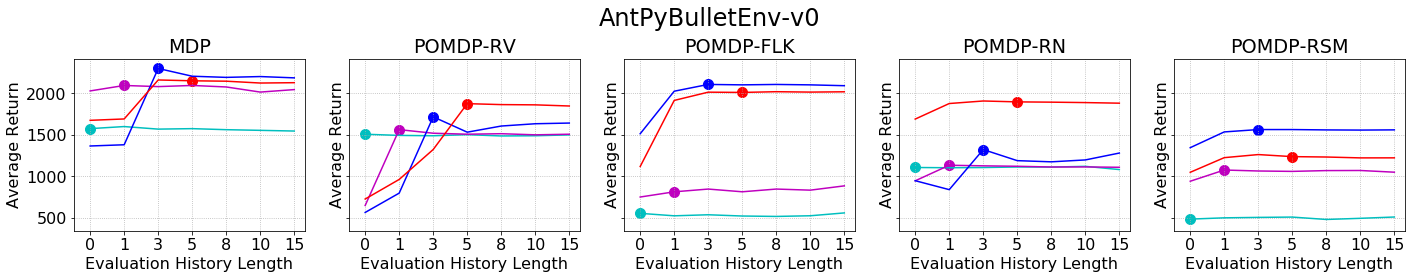

In [470]:
color = {'0':'c', '1':'m', '3':'b', '5':'r', 'DDPG':'k'}

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
for axes_i, pomdp_type in enumerate(['MDP', 'remove_velocity', 'flickering', 'random_noise', 'random_sensor_missing']):
    if pomdp_type == 'MDP':
        # Trained on MDP
        for orig_hist_len in lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len_mean.keys():
            axes[axes_i].plot(np.arange(7), lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len_mean[orig_hist_len], 
                              label='Training Hist Len: {}'.format(orig_hist_len), color=color[orig_hist_len])
            if orig_hist_len == '0':
                index = 0
            if orig_hist_len == '1':
                index = 1
            if orig_hist_len == '3':
                index = 2
            if orig_hist_len == '5':
                index = 3
            axes[axes_i].scatter(index, lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len_mean[orig_hist_len][index],
                                 color=color[orig_hist_len], s=100)
        axes[axes_i].set_xticks(np.arange(7))
        axes[axes_i].set_xticklabels(['0', '1', '3', '5', '8', '10', '15'])
        axes[axes_i].set_xlabel('Evaluation History Length')
        axes[axes_i].set_ylabel('Average Return')
        axes[axes_i].set_title('{}'.format(pomdp_type))
        axes[axes_i].grid(linestyle=':')
    else:
        # Trained on POMDP
        for orig_hist_len in eval_results_on_diff_hist_len_mean[pomdp_type].keys():
            axes[axes_i].plot(np.arange(7), eval_results_on_diff_hist_len_mean[pomdp_type][orig_hist_len], 
                              label='Training Hist Len: {}'.format(orig_hist_len), color=color[orig_hist_len])
#             axes[axes_i].errorbar(np.arange(7), eval_results_on_diff_hist_len_mean[pomdp_type][orig_hist_len], 
#                                   yerr=eval_results_on_diff_hist_len_std[pomdp_type][orig_hist_len], label='Training Hist Len: {}'.format(orig_hist_len))
            if orig_hist_len == '0':
                index = 0
            if orig_hist_len == '1':
                index = 1
            if orig_hist_len == '3':
                index = 2
            if orig_hist_len == '5':
                index = 3
            axes[axes_i].scatter(index, eval_results_on_diff_hist_len_mean[pomdp_type][orig_hist_len][index],
                                 color=color[orig_hist_len], s=100)
        axes[axes_i].set_xticks(np.arange(7))
        axes[axes_i].set_xticklabels(['0', '1', '3', '5', '8', '10', '15'])
        axes[axes_i].set_xlabel('Evaluation History Length')
        axes[axes_i].set_ylabel('Average Return')
        if pomdp_type == 'remove_velocity':
            pomdp_type = 'POMDP-RV'
        if pomdp_type == 'flickering':
            pomdp_type = 'POMDP-FLK'
        if pomdp_type == 'random_noise':
            pomdp_type = 'POMDP-RN'
        if pomdp_type == 'random_sensor_missing':
            pomdp_type = 'POMDP-RSM'
        axes[axes_i].set_title('{}'.format(pomdp_type))
        axes[axes_i].grid(linestyle=':')
plt.tight_layout()
fig.suptitle("{}".format('AntPyBulletEnv-v0'), fontsize=24)
fig.subplots_adjust(top=0.8)
fig.savefig("D:\POMDP_Data\images\evaluation_on_different_history_length.png", bbox_inches='tight')

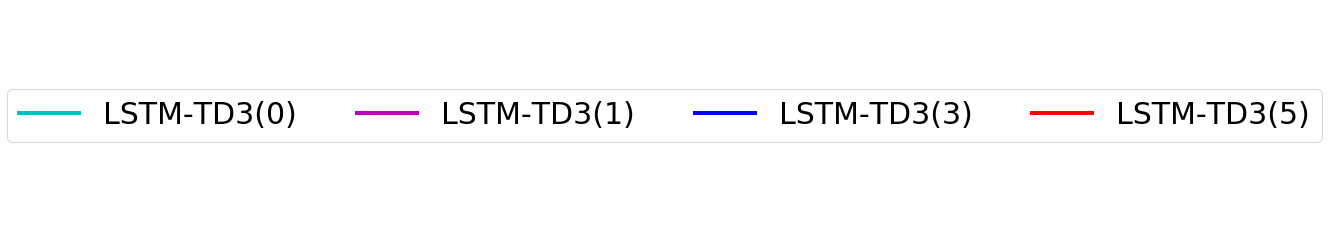

In [487]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

color = {'0':'c', '1':'m', '3':'b', '5':'r'}

lw_scale = 4

legend_elements= []
for train_hist_len in color.keys():
    label='LSTM-TD3({})'.format(train_hist_len)
    legend_elements.append(Line2D([0], [0], color=color[train_hist_len], lw=lw_scale*1, label=label))

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axis(False)
plt.show()
plt.rc('font', size=30)
fig.savefig("D:\POMDP_Data\images\evaluation_on_different_history_length_legend.png", bbox_inches='tight')

In [488]:
plt.rc('font', size=16)

### POMDP-FLK

In [2]:
import torch.nn as nn

In [4]:
root_dir = r"D:\new_spinup_resumable_POMDP_LSTM_TD3_POMDP-FLK"
DEVICE = "cpu"  # "cuda"

lstm_td3_different_hist_len_POMDP_FLK = {}
for sub_dir in os.listdir(root_dir):
    if 'lstm_td3' in sub_dir:
        print(sub_dir)
        print(sub_dir.split('_'))
        params = sub_dir.split('_')
        alg_name = '-'.format(params[1].upper(), params[2].upper)
        task_name = params[3]
        seed = params[4]
        hist_len = params[6]
        
        pomdp_hyperparam = 'POMDP-{}'.format('-'.join(params[-2:]))
        
        if task_name in tasks:
            if alg_name not in lstm_td3_different_hist_len_POMDP_FLK:
                lstm_td3_different_hist_len_POMDP_FLK[alg_name] = {}
            if task_name not in lstm_td3_different_hist_len_POMDP_FLK[alg_name]:
                lstm_td3_different_hist_len_POMDP_FLK[alg_name][task_name] = {}
            if pomdp_hyperparam not in lstm_td3_different_hist_len_POMDP_FLK[alg_name][task_name]:
                lstm_td3_different_hist_len_POMDP_FLK[alg_name][task_name][pomdp_hyperparam] = {}
            if hist_len not in lstm_td3_different_hist_len_POMDP_FLK[alg_name][task_name][pomdp_hyperparam]:
                lstm_td3_different_hist_len_POMDP_FLK[alg_name][task_name][pomdp_hyperparam][hist_len] = {}
            if seed not in lstm_td3_different_hist_len_POMDP_FLK[alg_name][task_name][pomdp_hyperparam][hist_len]:
                lstm_td3_different_hist_len_POMDP_FLK[alg_name][task_name][pomdp_hyperparam][hist_len][seed] = {}
            #
            print("********************************************************************")
            for exp_run in os.listdir(os.path.join(root_dir, sub_dir)):
                print(exp_run)
                # Load pre-trained model
                config_path = os.path.join(root_dir, sub_dir, exp_run, 'config.json')
                with open(config_path, 'r') as config_file:
                    config_json = json.load(config_file)
                model_path = os.path.join(root_dir, sub_dir, exp_run, 'pyt_save', 'model.pt')
                ac = torch.load(model_path)
                ac.pi.mem_after_lstm_layers = nn.ModuleList()
                # print(ac)
                
                # Evaluate on the same environment, but with different history length.
                for eval_hist_len in [0, 1, 3, 5, 8, 10, 15]:
                    print("\t{}".format(eval_hist_len))
                    lstm_td3_different_hist_len_POMDP_FLK[alg_name][task_name][pomdp_hyperparam][hist_len][seed]['{}'.format(eval_hist_len)] = []

                    # Evaluation
                    for j in range(num_test_episodes):
                        # Reset environment
                        o, d, ep_ret, ep_len = env.reset(), False, 0, 0
                        if eval_hist_len > 0:
                            o_buff = np.zeros([eval_hist_len, obs_dim])
                            a_buff = np.zeros([eval_hist_len, act_dim])
                            o_buff[0, :] = o
                            o_buff_len = 0
                        else:
                            o_buff = np.zeros([1, obs_dim])
                            a_buff = np.zeros([1, act_dim])
                            o_buff_len = 0

                        # Interact
                        while not(d or (ep_len == max_ep_len)):
                            # Take deterministic actions at test time 
                            h_o = torch.tensor(o_buff).view(1, o_buff.shape[0], o_buff.shape[1]).float().to(DEVICE)
                            h_a = torch.tensor(a_buff).view(1, a_buff.shape[0], a_buff.shape[1]).float().to(DEVICE)
                            h_l = torch.tensor([o_buff_len]).float().to(DEVICE)
                            a = ac.act(torch.as_tensor(o, dtype=torch.float32).view(1, -1).to(DEVICE),
                                       h_o, h_a, h_l).reshape(act_dim)

                            o2, r, d, _ = env.step(a)
                            ep_ret += r
                            ep_len += 1

                            # Add short history
                            if eval_hist_len != 0:
                                if o_buff_len == eval_hist_len:
                                    o_buff[:eval_hist_len - 1] = o_buff[1:]
                                    a_buff[:eval_hist_len - 1] = a_buff[1:]
                                    o_buff[eval_hist_len - 1] = list(o)
                                    a_buff[eval_hist_len - 1] = list(a)
                                else:
                                    o_buff[o_buff_len + 1 - 1] = list(o)
                                    a_buff[o_buff_len + 1 - 1] = list(a)
                                    o_buff_len += 1
                            o = o2
                        print('\t  Episod-{}: Ep_Return={}, Ep_Len={}'.format(j, ep_ret, ep_len))
                        lstm_td3_different_hist_len_POMDP_FLK[alg_name][task_name][pomdp_hyperparam][hist_len][seed]['{}'.format(eval_hist_len)].append(ep_ret)

In [509]:
lstm_td3_different_hist_len_POMDP_FLK[alg_name][task_name][pomdp_hyperparam]

{'0': {}}

In [44]:
tasks = ['AntPyBulletEnv-v0']

root_dir = r"D:\new_spinup_resumable_POMDP_LSTM_TD3_POMDP-FLK"
DEVICE = "cpu"  # "cuda"

# lstm_td3_different_hist_len = {}
for sub_dir in os.listdir(root_dir):
    print(sub_dir)
    print(sub_dir.split('_'))
    params = sub_dir.split('_')
    alg_name = params[1]
    task_name = params[2]
    pomdp_hyperparam = '{}-{}'.format(params[4], params[-1])
    seed = params[-3]
    hist_len = params[-2]
    
    if task_name in tasks:
        if alg_name not in lstm_td3_different_hist_len:
            lstm_td3_different_hist_len[alg_name] = {}
        if task_name not in lstm_td3_different_hist_len[alg_name]:
            lstm_td3_different_hist_len[alg_name][task_name] = {}
        if pomdp_hyperparam not in lstm_td3_different_hist_len[alg_name][task_name]:
            lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam] = {}
        if hist_len not in lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam]:
            lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam][hist_len] = {}
        if seed not in lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam][hist_len]:
            lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam][hist_len][seed] = {}
        #
        print("********************************************************************")
        for exp_run in os.listdir(os.path.join(root_dir, sub_dir)):
            print(exp_run)
            # Load pre-trained model
            config_path = os.path.join(root_dir, sub_dir, exp_run, 'config.json')
            with open(config_path, 'r') as config_file:
                config_json = json.load(config_file)
            # Retrive hyper-parameters
            env_name = config_json['env_name']
            num_test_episodes = config_json['num_test_episodes']
            max_ep_len = config_json['max_ep_len']
            max_hist_len = config_json['max_hist_len']
            
            # Create environment
            if config_json['partially_observable']:
                env = POMDPWrapper(env_name, config_json['pomdp_type'], 
                                   config_json['flicker_prob'], config_json['random_noise_sigma'], 
                                   config_json['random_sensor_missing_prob'])
            else:
                env = gym.make(env_name)
            
            obs_dim = env.observation_space.shape[0]
            act_dim = env.action_space.shape[0]
            act_limit = env.action_space.high[0]
            
            critic_mem_pre_lstm_hid_sizes = config_json['critic_mem_pre_lstm_hid_sizes']
            critic_mem_lstm_hid_sizes = config_json['critic_mem_lstm_hid_sizes']
            critic_mem_after_lstm_hid_size = config_json['critic_mem_after_lstm_hid_size']
            critic_cur_feature_hid_sizes = config_json['critic_cur_feature_hid_sizes']
            critic_post_comb_hid_sizes = config_json['critic_post_comb_hid_sizes']
            critic_mem_gate = config_json['critic_mem_gate']
            critic_mem_gate_before_current_feature_extraction = config_json['critic_mem_gate_before_current_feature_extraction']
            critic_hist_with_past_act = config_json['critic_hist_with_past_act']
            critic_use_hist_mask = config_json['critic_use_hist_mask']
            actor_mem_pre_lstm_hid_sizes = config_json['actor_mem_pre_lstm_hid_sizes']
            actor_mem_lstm_hid_sizes = config_json['actor_mem_lstm_hid_sizes']
            actor_mem_after_lstm_hid_size = config_json['actor_mem_after_lstm_hid_size']
            actor_cur_feature_hid_sizes = config_json['actor_cur_feature_hid_sizes']
            actor_post_comb_hid_sizes = config_json['actor_post_comb_hid_sizes']
            actor_mem_gate = config_json['actor_mem_gate']
            actor_mem_gate_before_current_feature_extraction = config_json['actor_mem_gate_before_current_feature_extraction']
            actor_hist_with_past_act = config_json['actor_hist_with_past_act']
            actor_use_hist_mask = config_json['actor_use_hist_mask']    
            ac = MLPActorCritic(obs_dim, act_dim, act_limit,
                                critic_mem_pre_lstm_hid_sizes=critic_mem_pre_lstm_hid_sizes,
                                critic_mem_lstm_hid_sizes=critic_mem_lstm_hid_sizes,
                                critic_mem_after_lstm_hid_size=critic_mem_after_lstm_hid_size,
                                critic_cur_feature_hid_sizes=critic_cur_feature_hid_sizes,
                                critic_post_comb_hid_sizes=critic_post_comb_hid_sizes,
                                critic_mem_gate=critic_mem_gate,
                                critic_mem_gate_before_current_feature_extraction=critic_mem_gate_before_current_feature_extraction,
                                critic_hist_with_past_act=critic_hist_with_past_act,
                                critic_use_hist_mask=critic_use_hist_mask,
                                actor_mem_pre_lstm_hid_sizes=actor_mem_pre_lstm_hid_sizes,
                                actor_mem_lstm_hid_sizes=actor_mem_lstm_hid_sizes,
                                actor_mem_after_lstm_hid_size=actor_mem_after_lstm_hid_size,
                                actor_cur_feature_hid_sizes=actor_cur_feature_hid_sizes,
                                actor_post_comb_hid_sizes=actor_post_comb_hid_sizes,
                                actor_mem_gate=actor_mem_gate,
                                actor_mem_gate_before_current_feature_extraction=actor_mem_gate_before_current_feature_extraction,
                                actor_hist_with_past_act=actor_hist_with_past_act,
                                actor_use_hist_mask=actor_use_hist_mask)
            # Load model
            resume_checkpoint_path = os.path.join(root_dir, sub_dir, exp_run, "pyt_save")
            checkpoint_files = os.listdir(resume_checkpoint_path)
            latest_model_checkpoint_file_path = os.path.join(resume_checkpoint_path, checkpoint_files[-1])
            
            model_checkpoint = torch.load(latest_model_checkpoint_file_path)
            ac.load_state_dict(model_checkpoint['ac_state_dict'])
            
            # print(ac)
            
            # Evaluate on the same environment, but with different history length.
#             for eval_hist_len in [0, 1, 3, 5, 8, 10, 15]:
            for eval_hist_len in [12, 18, 20]:
                print("\t{}".format(eval_hist_len))
                lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam][hist_len][seed]['{}'.format(eval_hist_len)] = []
                
                # Evaluation
                for j in range(num_test_episodes):
                    # Reset environment
                    o, d, ep_ret, ep_len = env.reset(), False, 0, 0
                    if eval_hist_len > 0:
                        o_buff = np.zeros([eval_hist_len, obs_dim])
                        a_buff = np.zeros([eval_hist_len, act_dim])
                        o_buff[0, :] = o
                        o_buff_len = 0
                    else:
                        o_buff = np.zeros([1, obs_dim])
                        a_buff = np.zeros([1, act_dim])
                        o_buff_len = 0

                    # Interact
                    while not(d or (ep_len == max_ep_len)):
                        # Take deterministic actions at test time 
                        h_o = torch.tensor(o_buff).view(1, o_buff.shape[0], o_buff.shape[1]).float().to(DEVICE)
                        h_a = torch.tensor(a_buff).view(1, a_buff.shape[0], a_buff.shape[1]).float().to(DEVICE)
                        h_l = torch.tensor([o_buff_len]).float().to(DEVICE)
                        a = ac.act(torch.as_tensor(o, dtype=torch.float32).view(1, -1).to(DEVICE),
                                   h_o, h_a, h_l).reshape(act_dim)
                        
                        o2, r, d, _ = env.step(a)
                        ep_ret += r
                        ep_len += 1

                        # Add short history
                        if eval_hist_len != 0:
                            if o_buff_len == eval_hist_len:
                                o_buff[:eval_hist_len - 1] = o_buff[1:]
                                a_buff[:eval_hist_len - 1] = a_buff[1:]
                                o_buff[eval_hist_len - 1] = list(o)
                                a_buff[eval_hist_len - 1] = list(a)
                            else:
                                o_buff[o_buff_len + 1 - 1] = list(o)
                                a_buff[o_buff_len + 1 - 1] = list(a)
                                o_buff_len += 1
                        o = o2
                    print('\t  Episod-{}: Ep_Return={}, Ep_Len={}'.format(j, ep_ret, ep_len))
                    lstm_td3_different_hist_len[alg_name][task_name][pomdp_hyperparam][hist_len][seed]['{}'.format(eval_hist_len)].append(ep_ret)

2021-02-02_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_0_0.05
['2021-02-02', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '0', '0', '0.05']
********************************************************************
2021-02-02_20-45-28-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_0_0.05_s0
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=673.4297048498074, Ep_Len=1000
	  Episod-1: Ep_Return=756.486757548007, Ep_Len=1000
	  Episod-2: Ep_Return=851.8130652847996, Ep_Len=1000
	  Episod-3: Ep_Return=766.7225645044565, Ep_Len=1000
	  Episod-4: Ep_Return=839.7766613994444, Ep_Len=1000
	  Episod-5: Ep_Return=741.3840025769848, Ep_Len=1000
	  Episod-6: Ep_Return=746.4224034759958, Ep_Len=1000
	  Episod-7: Ep_Return=698.8981055861092, Ep_Len=1000
	  Episod-8: Ep_Return=792.4396333817363, Ep_Len=1000
	  Episod-9: Ep_Return=796.9431260508637, Ep_Len=1000
	18
	  Episod-0: Ep_Return=769.7695885388945, Ep_Len=1000
	  Episod-1: Ep_Return=804.5937367087231, Ep_Len=1000
	  Episod-2: Ep_Ret

	  Episod-1: Ep_Return=708.8931575039444, Ep_Len=1000
	  Episod-2: Ep_Return=697.4420226644087, Ep_Len=1000
	  Episod-3: Ep_Return=698.181622115255, Ep_Len=1000
	  Episod-4: Ep_Return=669.0409210592895, Ep_Len=1000
	  Episod-5: Ep_Return=617.9389074722217, Ep_Len=1000
	  Episod-6: Ep_Return=682.0681757572911, Ep_Len=1000
	  Episod-7: Ep_Return=461.95950046148187, Ep_Len=1000
	  Episod-8: Ep_Return=531.7268658665074, Ep_Len=1000
	  Episod-9: Ep_Return=838.8085877484206, Ep_Len=1000
	18
	  Episod-0: Ep_Return=695.5691998113654, Ep_Len=1000
	  Episod-1: Ep_Return=687.5197976871463, Ep_Len=1000
	  Episod-2: Ep_Return=540.406139621837, Ep_Len=1000
	  Episod-3: Ep_Return=581.1767090781261, Ep_Len=1000
	  Episod-4: Ep_Return=619.1438062799543, Ep_Len=1000
	  Episod-5: Ep_Return=584.5961935944002, Ep_Len=1000
	  Episod-6: Ep_Return=551.5244012058096, Ep_Len=1000
	  Episod-7: Ep_Return=504.4814325894504, Ep_Len=1000
	  Episod-8: Ep_Return=642.2354791060791, Ep_Len=1000
	  Episod-9: Ep_Return=80

	  Episod-8: Ep_Return=684.8988565531765, Ep_Len=1000
	  Episod-9: Ep_Return=225.8647576405465, Ep_Len=455
	18
	  Episod-0: Ep_Return=579.821844487225, Ep_Len=1000
	  Episod-1: Ep_Return=123.24645101460774, Ep_Len=242
	  Episod-2: Ep_Return=575.033619480234, Ep_Len=1000
	  Episod-3: Ep_Return=559.5740080896786, Ep_Len=1000
	  Episod-4: Ep_Return=676.2107392407696, Ep_Len=1000
	  Episod-5: Ep_Return=666.3527309156989, Ep_Len=1000
	  Episod-6: Ep_Return=740.8406370287619, Ep_Len=1000
	  Episod-7: Ep_Return=639.0739583742483, Ep_Len=1000
	  Episod-8: Ep_Return=493.1471504034606, Ep_Len=1000
	  Episod-9: Ep_Return=646.7879940605487, Ep_Len=1000
	20
	  Episod-0: Ep_Return=597.4638815785518, Ep_Len=1000
	  Episod-1: Ep_Return=636.9498974263499, Ep_Len=1000
	  Episod-2: Ep_Return=443.90657453660884, Ep_Len=1000
	  Episod-3: Ep_Return=384.38714823654465, Ep_Len=850
	  Episod-4: Ep_Return=550.064995310976, Ep_Len=1000
	  Episod-5: Ep_Return=711.147530663341, Ep_Len=1000
	  Episod-6: Ep_Return=5

	  Episod-4: Ep_Return=2216.862985667792, Ep_Len=1000
	  Episod-5: Ep_Return=2152.6964135450426, Ep_Len=1000
	  Episod-6: Ep_Return=2304.3242783270784, Ep_Len=1000
	  Episod-7: Ep_Return=2274.9849423888945, Ep_Len=1000
	  Episod-8: Ep_Return=2335.822967530515, Ep_Len=1000
	  Episod-9: Ep_Return=2361.3786775193103, Ep_Len=1000
	20
	  Episod-0: Ep_Return=2309.9543956799203, Ep_Len=1000
	  Episod-1: Ep_Return=2332.4275298968123, Ep_Len=1000
	  Episod-2: Ep_Return=2261.4237657258127, Ep_Len=1000
	  Episod-3: Ep_Return=2353.4401301652647, Ep_Len=1000
	  Episod-4: Ep_Return=2314.7985370109227, Ep_Len=1000
	  Episod-5: Ep_Return=2260.672003551569, Ep_Len=1000
	  Episod-6: Ep_Return=2293.9258853486704, Ep_Len=1000
	  Episod-7: Ep_Return=2211.63377834073, Ep_Len=1000
	  Episod-8: Ep_Return=2261.332117129382, Ep_Len=1000
	  Episod-9: Ep_Return=2301.120181967916, Ep_Len=1000
2021-02-02_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_10_0.2
['2021-02-02', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'fli

	  Episod-0: Ep_Return=1715.8569562927712, Ep_Len=1000
	  Episod-1: Ep_Return=1691.474571775601, Ep_Len=1000
	  Episod-2: Ep_Return=1699.6958530307131, Ep_Len=1000
	  Episod-3: Ep_Return=1687.8742836515387, Ep_Len=1000
	  Episod-4: Ep_Return=1673.5609631473699, Ep_Len=1000
	  Episod-5: Ep_Return=1706.1307548725854, Ep_Len=1000
	  Episod-6: Ep_Return=1669.6092758865257, Ep_Len=1000
	  Episod-7: Ep_Return=1641.6512383801025, Ep_Len=1000
	  Episod-8: Ep_Return=1694.0952555553065, Ep_Len=1000
	  Episod-9: Ep_Return=1739.0838708820356, Ep_Len=1000
2021-02-02_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_10_0.4
['2021-02-02', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '0', '10', '0.4']
********************************************************************
2021-02-02_22-36-32-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_10_0.4_s0
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=1560.4521313804566, Ep_Len=1000
	  Episod-1: Ep_Return=1491.2643998535295, Ep_Len=1000
	  Episod-2

	  Episod-6: Ep_Return=2273.427385330678, Ep_Len=1000
	  Episod-7: Ep_Return=2289.53505655429, Ep_Len=1000
	  Episod-8: Ep_Return=2319.6677254713913, Ep_Len=1000
	  Episod-9: Ep_Return=2280.3310353747406, Ep_Len=1000
2021-02-02_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_12_0.1
['2021-02-02', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '0', '12', '0.1']
********************************************************************
2021-02-02_22-45-45-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_12_0.1_s0
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=2130.108274759658, Ep_Len=1000
	  Episod-1: Ep_Return=2234.121189306625, Ep_Len=1000
	  Episod-2: Ep_Return=2103.995166255221, Ep_Len=1000
	  Episod-3: Ep_Return=2155.0877598282927, Ep_Len=1000
	  Episod-4: Ep_Return=2224.136428091809, Ep_Len=1000
	  Episod-5: Ep_Return=2234.6738522292703, Ep_Len=1000
	  Episod-6: Ep_Return=2183.96543190462, Ep_Len=1000
	  Episod-7: Ep_Return=2101.83525725509, Ep_Len=1000
	  Episod-8: Ep_Retur

	  Episod-0: Ep_Return=1540.0910911405072, Ep_Len=1000
	  Episod-1: Ep_Return=1612.8190453575824, Ep_Len=1000
	  Episod-2: Ep_Return=1503.0976206027656, Ep_Len=1000
	  Episod-3: Ep_Return=1486.6035574490024, Ep_Len=1000
	  Episod-4: Ep_Return=1486.2998093351794, Ep_Len=1000
	  Episod-5: Ep_Return=1519.3646808505757, Ep_Len=1000
	  Episod-6: Ep_Return=1546.4248210720489, Ep_Len=1000
	  Episod-7: Ep_Return=1477.9334262507878, Ep_Len=1000
	  Episod-8: Ep_Return=1523.9000016089044, Ep_Len=1000
	  Episod-9: Ep_Return=1527.5132862529872, Ep_Len=1000
	18
	  Episod-0: Ep_Return=1579.8840192128368, Ep_Len=1000
	  Episod-1: Ep_Return=1558.651871284729, Ep_Len=1000
	  Episod-2: Ep_Return=1509.5708406801527, Ep_Len=1000
	  Episod-3: Ep_Return=1517.9490456204946, Ep_Len=1000
	  Episod-4: Ep_Return=1499.3183994819149, Ep_Len=1000
	  Episod-5: Ep_Return=1557.0437953307296, Ep_Len=1000
	  Episod-6: Ep_Return=1544.0301137535128, Ep_Len=1000
	  Episod-7: Ep_Return=1462.4083953264014, Ep_Len=1000
	  Epis

	  Episod-6: Ep_Return=867.3336169732335, Ep_Len=1000
	  Episod-7: Ep_Return=697.6341236303026, Ep_Len=1000
	  Episod-8: Ep_Return=776.582338688258, Ep_Len=1000
	  Episod-9: Ep_Return=701.8663764157975, Ep_Len=1000
	18
	  Episod-0: Ep_Return=773.8903144086547, Ep_Len=1000
	  Episod-1: Ep_Return=801.1905496868733, Ep_Len=1000
	  Episod-2: Ep_Return=834.6424300754485, Ep_Len=1000
	  Episod-3: Ep_Return=698.7477197231149, Ep_Len=1000
	  Episod-4: Ep_Return=832.2230652469051, Ep_Len=1000
	  Episod-5: Ep_Return=791.1216040567487, Ep_Len=1000
	  Episod-6: Ep_Return=804.2582758420414, Ep_Len=1000
	  Episod-7: Ep_Return=697.2281969937933, Ep_Len=1000
	  Episod-8: Ep_Return=794.7301981656758, Ep_Len=1000
	  Episod-9: Ep_Return=699.9364403233619, Ep_Len=1000
	20
	  Episod-0: Ep_Return=701.9035643653359, Ep_Len=1000
	  Episod-1: Ep_Return=795.6679056441104, Ep_Len=1000
	  Episod-2: Ep_Return=790.309655283569, Ep_Len=1000
	  Episod-3: Ep_Return=705.0583063055311, Ep_Len=1000
	  Episod-4: Ep_Return

	  Episod-2: Ep_Return=2223.5148925499893, Ep_Len=1000
	  Episod-3: Ep_Return=2321.619944671714, Ep_Len=1000
	  Episod-4: Ep_Return=2203.040030332509, Ep_Len=1000
	  Episod-5: Ep_Return=2255.9731469147546, Ep_Len=1000
	  Episod-6: Ep_Return=2188.11359593073, Ep_Len=1000
	  Episod-7: Ep_Return=2339.865360797771, Ep_Len=1000
	  Episod-8: Ep_Return=2210.2101083518364, Ep_Len=1000
	  Episod-9: Ep_Return=2246.1989733695086, Ep_Len=1000
	20
	  Episod-0: Ep_Return=2188.4237424937896, Ep_Len=1000
	  Episod-1: Ep_Return=2281.07180179506, Ep_Len=1000
	  Episod-2: Ep_Return=2255.6993972837627, Ep_Len=1000
	  Episod-3: Ep_Return=2298.4482263432856, Ep_Len=1000
	  Episod-4: Ep_Return=2211.672346808674, Ep_Len=1000
	  Episod-5: Ep_Return=2263.9032552019758, Ep_Len=1000
	  Episod-6: Ep_Return=2241.912535007329, Ep_Len=1000
	  Episod-7: Ep_Return=2120.5415282549984, Ep_Len=1000
	  Episod-8: Ep_Return=2269.2196964531972, Ep_Len=1000
	  Episod-9: Ep_Return=2291.292519950211, Ep_Len=1000
2021-02-02_LSTM-

	  Episod-7: Ep_Return=1099.106279799327, Ep_Len=1000
	  Episod-8: Ep_Return=1109.1315744496274, Ep_Len=1000
	  Episod-9: Ep_Return=1050.8717493194147, Ep_Len=1000
	20
	  Episod-0: Ep_Return=1114.365937679454, Ep_Len=1000
	  Episod-1: Ep_Return=1119.998032932582, Ep_Len=1000
	  Episod-2: Ep_Return=1103.4317125746545, Ep_Len=1000
	  Episod-3: Ep_Return=1115.489378605527, Ep_Len=1000
	  Episod-4: Ep_Return=1122.6228350957447, Ep_Len=1000
	  Episod-5: Ep_Return=1087.5070793896243, Ep_Len=1000
	  Episod-6: Ep_Return=1107.2725863832823, Ep_Len=1000
	  Episod-7: Ep_Return=1138.850752167599, Ep_Len=1000
	  Episod-8: Ep_Return=1096.158666300435, Ep_Len=1000
	  Episod-9: Ep_Return=1118.573121528117, Ep_Len=1000
2021-02-02_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_15_0.45
['2021-02-02', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '0', '15', '0.45']
********************************************************************
2021-02-02_23-18-57-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_1

	  Episod-4: Ep_Return=2550.0153075670205, Ep_Len=1000
	  Episod-5: Ep_Return=2523.4059160930333, Ep_Len=1000
	  Episod-6: Ep_Return=2546.290842489829, Ep_Len=1000
	  Episod-7: Ep_Return=2536.4543243332632, Ep_Len=1000
	  Episod-8: Ep_Return=2570.931918895644, Ep_Len=1000
	  Episod-9: Ep_Return=2557.6173038046422, Ep_Len=1000
2021-02-02_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_18_0.15
['2021-02-02', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '0', '18', '0.15']
********************************************************************
2021-02-02_23-23-48-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_18_0.15_s0
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=2049.2510912088496, Ep_Len=1000
	  Episod-1: Ep_Return=2002.1707182771625, Ep_Len=1000
	  Episod-2: Ep_Return=2058.424350451825, Ep_Len=1000
	  Episod-3: Ep_Return=2061.6335829706227, Ep_Len=1000
	  Episod-4: Ep_Return=2060.4947175203356, Ep_Len=1000
	  Episod-5: Ep_Return=2043.0768957890011, Ep_Len=1000
	  Episod-

	  Episod-0: Ep_Return=886.3027399025856, Ep_Len=1000
	  Episod-1: Ep_Return=986.5941494140728, Ep_Len=1000
	  Episod-2: Ep_Return=921.3755155779216, Ep_Len=1000
	  Episod-3: Ep_Return=960.2749433914215, Ep_Len=1000
	  Episod-4: Ep_Return=981.9467369737932, Ep_Len=1000
	  Episod-5: Ep_Return=989.36353940592, Ep_Len=1000
	  Episod-6: Ep_Return=815.6551295796318, Ep_Len=1000
	  Episod-7: Ep_Return=877.0686793540654, Ep_Len=1000
	  Episod-8: Ep_Return=1007.8282350887679, Ep_Len=1000
	  Episod-9: Ep_Return=841.7665871222445, Ep_Len=1000
	18
	  Episod-0: Ep_Return=1018.4057186643013, Ep_Len=1000
	  Episod-1: Ep_Return=986.3746903294575, Ep_Len=1000
	  Episod-2: Ep_Return=871.9625907354284, Ep_Len=1000
	  Episod-3: Ep_Return=970.0246355994619, Ep_Len=1000
	  Episod-4: Ep_Return=969.9955954973393, Ep_Len=1000
	  Episod-5: Ep_Return=914.6979404297589, Ep_Len=1000
	  Episod-6: Ep_Return=1010.6635636156415, Ep_Len=1000
	  Episod-7: Ep_Return=995.1065584205744, Ep_Len=1000
	  Episod-8: Ep_Return=

	  Episod-6: Ep_Return=2154.3608478379665, Ep_Len=1000
	  Episod-7: Ep_Return=2474.6067026775972, Ep_Len=1000
	  Episod-8: Ep_Return=1969.7183342559147, Ep_Len=1000
	  Episod-9: Ep_Return=2485.3087091759317, Ep_Len=1000
	18
	  Episod-0: Ep_Return=2518.183435088826, Ep_Len=1000
	  Episod-1: Ep_Return=2474.093068695967, Ep_Len=1000
	  Episod-2: Ep_Return=2301.9459124270534, Ep_Len=1000
	  Episod-3: Ep_Return=2436.0413049087515, Ep_Len=1000
	  Episod-4: Ep_Return=2392.301043758658, Ep_Len=1000
	  Episod-5: Ep_Return=2306.4264218653125, Ep_Len=1000
	  Episod-6: Ep_Return=2460.0619876521578, Ep_Len=1000
	  Episod-7: Ep_Return=2452.398202508017, Ep_Len=1000
	  Episod-8: Ep_Return=2387.8118243113818, Ep_Len=1000
	  Episod-9: Ep_Return=2367.5625341625287, Ep_Len=1000
	20
	  Episod-0: Ep_Return=2476.808155551847, Ep_Len=1000
	  Episod-1: Ep_Return=2352.8808194986327, Ep_Len=1000
	  Episod-2: Ep_Return=2472.5973857628787, Ep_Len=1000
	  Episod-3: Ep_Return=2491.083564797793, Ep_Len=1000
	  Episo

	  Episod-3: Ep_Return=523.2769895052319, Ep_Len=1000
	  Episod-4: Ep_Return=713.4168210342053, Ep_Len=1000
	  Episod-5: Ep_Return=691.5264540732129, Ep_Len=1000
	  Episod-6: Ep_Return=611.9091180355226, Ep_Len=1000
	  Episod-7: Ep_Return=675.9440553001856, Ep_Len=1000
	  Episod-8: Ep_Return=667.0275532167361, Ep_Len=1000
	  Episod-9: Ep_Return=615.7716992985651, Ep_Len=1000
	20
	  Episod-0: Ep_Return=670.3982720745748, Ep_Len=1000
	  Episod-1: Ep_Return=593.3283124650204, Ep_Len=1000
	  Episod-2: Ep_Return=549.8148447390697, Ep_Len=1000
	  Episod-3: Ep_Return=545.4117306499346, Ep_Len=1000
	  Episod-4: Ep_Return=699.0617569508801, Ep_Len=1000
	  Episod-5: Ep_Return=708.8014556151026, Ep_Len=1000
	  Episod-6: Ep_Return=608.7012257375762, Ep_Len=1000
	  Episod-7: Ep_Return=725.6935770821541, Ep_Len=1000
	  Episod-8: Ep_Return=613.2340427016537, Ep_Len=1000
	  Episod-9: Ep_Return=687.5923746909007, Ep_Len=1000
2021-02-03_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_1_0.3
['2021-02-03', '

	  Episod-0: Ep_Return=621.7861341367111, Ep_Len=1000
	  Episod-1: Ep_Return=637.9334287150499, Ep_Len=1000
	  Episod-2: Ep_Return=571.6861420106039, Ep_Len=1000
	  Episod-3: Ep_Return=629.2865604709796, Ep_Len=1000
	  Episod-4: Ep_Return=596.9648805193301, Ep_Len=1000
	  Episod-5: Ep_Return=554.5394584929259, Ep_Len=1000
	  Episod-6: Ep_Return=664.1274514003209, Ep_Len=1000
	  Episod-7: Ep_Return=668.760913710187, Ep_Len=1000
	  Episod-8: Ep_Return=598.9574183256783, Ep_Len=1000
	  Episod-9: Ep_Return=639.5888204879393, Ep_Len=1000
2021-02-03_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_1_0.5
['2021-02-03', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '0', '1', '0.5']
********************************************************************
2021-02-03_00-58-34-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_1_0.5_s0
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=584.5785555534148, Ep_Len=1000
	  Episod-1: Ep_Return=559.9021301647936, Ep_Len=1000
	  Episod-2: Ep_Return=500

	  Episod-6: Ep_Return=2135.1638328726845, Ep_Len=1000
	  Episod-7: Ep_Return=2129.9770395119717, Ep_Len=1000
	  Episod-8: Ep_Return=2137.46360272154, Ep_Len=1000
	  Episod-9: Ep_Return=2172.5854442527634, Ep_Len=1000
2021-02-03_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_20_0.2
['2021-02-03', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '0', '20', '0.2']
********************************************************************
2021-02-03_01-12-27-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_20_0.2_s0
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=1925.2967452370858, Ep_Len=1000
	  Episod-1: Ep_Return=1811.397030270599, Ep_Len=1000
	  Episod-2: Ep_Return=1905.188794918732, Ep_Len=1000
	  Episod-3: Ep_Return=1845.4156108287084, Ep_Len=1000
	  Episod-4: Ep_Return=1880.9794899506778, Ep_Len=1000
	  Episod-5: Ep_Return=1840.6336707536066, Ep_Len=1000
	  Episod-6: Ep_Return=1927.1554490683595, Ep_Len=1000
	  Episod-7: Ep_Return=1880.6810388889187, Ep_Len=1000
	  Episod-8: E

	  Episod-0: Ep_Return=989.2991062758767, Ep_Len=1000
	  Episod-1: Ep_Return=922.0289539350922, Ep_Len=1000
	  Episod-2: Ep_Return=976.9764492866146, Ep_Len=1000
	  Episod-3: Ep_Return=988.9026988237898, Ep_Len=1000
	  Episod-4: Ep_Return=976.9023960863437, Ep_Len=1000
	  Episod-5: Ep_Return=959.9942450239241, Ep_Len=1000
	  Episod-6: Ep_Return=941.974061030461, Ep_Len=1000
	  Episod-7: Ep_Return=992.6048055613525, Ep_Len=1000
	  Episod-8: Ep_Return=953.1587654190434, Ep_Len=1000
	  Episod-9: Ep_Return=875.4236452517254, Ep_Len=1000
	18
	  Episod-0: Ep_Return=980.1171829700819, Ep_Len=1000
	  Episod-1: Ep_Return=951.6553602617283, Ep_Len=1000
	  Episod-2: Ep_Return=927.2926254423415, Ep_Len=1000
	  Episod-3: Ep_Return=893.5079750322153, Ep_Len=1000
	  Episod-4: Ep_Return=981.0914793495631, Ep_Len=1000
	  Episod-5: Ep_Return=991.2508973853096, Ep_Len=1000
	  Episod-6: Ep_Return=973.7904916264645, Ep_Len=1000
	  Episod-7: Ep_Return=995.707773782948, Ep_Len=1000
	  Episod-8: Ep_Return=918

	  Episod-7: Ep_Return=2055.130958298595, Ep_Len=1000
	  Episod-8: Ep_Return=2041.8392418011058, Ep_Len=1000
	  Episod-9: Ep_Return=2062.0140202927105, Ep_Len=1000
	18
	  Episod-0: Ep_Return=2081.506356814536, Ep_Len=1000
	  Episod-1: Ep_Return=2032.7071037832957, Ep_Len=1000
	  Episod-2: Ep_Return=2068.1847942480763, Ep_Len=1000
	  Episod-3: Ep_Return=2068.077941953738, Ep_Len=1000
	  Episod-4: Ep_Return=2003.2268173966906, Ep_Len=1000
	  Episod-5: Ep_Return=2056.963300159039, Ep_Len=1000
	  Episod-6: Ep_Return=2054.0802040142116, Ep_Len=1000
	  Episod-7: Ep_Return=2073.0520227616266, Ep_Len=1000
	  Episod-8: Ep_Return=2071.094975554117, Ep_Len=1000
	  Episod-9: Ep_Return=2041.9321657232072, Ep_Len=1000
	20
	  Episod-0: Ep_Return=2101.005496294506, Ep_Len=1000
	  Episod-1: Ep_Return=1904.9521562863276, Ep_Len=1000
	  Episod-2: Ep_Return=2011.2622493306148, Ep_Len=1000
	  Episod-3: Ep_Return=1997.021716731121, Ep_Len=1000
	  Episod-4: Ep_Return=2058.2535107892254, Ep_Len=1000
	  Episod

	  Episod-3: Ep_Return=1862.3810964884808, Ep_Len=1000
	  Episod-4: Ep_Return=1899.800767557829, Ep_Len=1000
	  Episod-5: Ep_Return=1549.6671528637414, Ep_Len=1000
	  Episod-6: Ep_Return=1836.1697815365148, Ep_Len=1000
	  Episod-7: Ep_Return=1782.4410845048096, Ep_Len=1000
	  Episod-8: Ep_Return=1795.397623510797, Ep_Len=1000
	  Episod-9: Ep_Return=1697.1092123074934, Ep_Len=1000
	20
	  Episod-0: Ep_Return=1726.4398864302793, Ep_Len=1000
	  Episod-1: Ep_Return=1954.1233106476598, Ep_Len=1000
	  Episod-2: Ep_Return=1637.7831807847301, Ep_Len=1000
	  Episod-3: Ep_Return=1957.5728911539927, Ep_Len=1000
	  Episod-4: Ep_Return=1775.0149852638428, Ep_Len=1000
	  Episod-5: Ep_Return=1897.6680353289862, Ep_Len=1000
	  Episod-6: Ep_Return=1711.3919871695127, Ep_Len=1000
	  Episod-7: Ep_Return=1708.798517566307, Ep_Len=1000
	  Episod-8: Ep_Return=1933.9786001412547, Ep_Len=1000
	  Episod-9: Ep_Return=1757.4954079535933, Ep_Len=1000
2021-02-03_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_3_0.35
[

	  Episod-9: Ep_Return=680.4924886619186, Ep_Len=1000
	20
	  Episod-0: Ep_Return=665.5218572784023, Ep_Len=1000
	  Episod-1: Ep_Return=780.88895608222, Ep_Len=1000
	  Episod-2: Ep_Return=702.5307324122648, Ep_Len=1000
	  Episod-3: Ep_Return=795.6776152157026, Ep_Len=1000
	  Episod-4: Ep_Return=804.5199154665634, Ep_Len=1000
	  Episod-5: Ep_Return=667.6299691062343, Ep_Len=1000
	  Episod-6: Ep_Return=660.3238127326917, Ep_Len=1000
	  Episod-7: Ep_Return=608.130606052311, Ep_Len=1000
	  Episod-8: Ep_Return=657.5767781930771, Ep_Len=1000
	  Episod-9: Ep_Return=682.6379192737429, Ep_Len=1000
2021-02-03_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_5_0.05
['2021-02-03', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '0', '5', '0.05']
********************************************************************
2021-02-03_03-16-59-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_5_0.05_s0
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=2368.1592735808354, Ep_Len=1000
	  Episod-1: Ep_Retu

	  Episod-5: Ep_Return=2374.155856947431, Ep_Len=1000
	  Episod-6: Ep_Return=2311.030227598355, Ep_Len=1000
	  Episod-7: Ep_Return=2327.4448720106075, Ep_Len=1000
	  Episod-8: Ep_Return=2293.4189976147795, Ep_Len=1000
	  Episod-9: Ep_Return=2337.947055740128, Ep_Len=1000
2021-02-03_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_5_0.25
['2021-02-03', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '0', '5', '0.25']
********************************************************************
2021-02-03_03-17-00-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_0_5_0.25_s0
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=2288.1873432274824, Ep_Len=1000
	  Episod-1: Ep_Return=2264.412120341557, Ep_Len=1000
	  Episod-2: Ep_Return=2261.4388795497102, Ep_Len=1000
	  Episod-3: Ep_Return=2262.8175833268365, Ep_Len=1000
	  Episod-4: Ep_Return=2301.760592461487, Ep_Len=1000
	  Episod-5: Ep_Return=2285.811179574652, Ep_Len=1000
	  Episod-6: Ep_Return=2353.0933535274307, Ep_Len=1000
	  Episod-7: Ep_

	  Episod-0: Ep_Return=1094.9831573158424, Ep_Len=1000
	  Episod-1: Ep_Return=999.379968787955, Ep_Len=1000
	  Episod-2: Ep_Return=1082.492968040087, Ep_Len=1000
	  Episod-3: Ep_Return=1037.9796985414519, Ep_Len=1000
	  Episod-4: Ep_Return=1181.3799233488476, Ep_Len=1000
	  Episod-5: Ep_Return=1020.0737222856719, Ep_Len=1000
	  Episod-6: Ep_Return=961.3081754458619, Ep_Len=1000
	  Episod-7: Ep_Return=1041.9279410511126, Ep_Len=1000
	  Episod-8: Ep_Return=952.0301248111475, Ep_Len=1000
	  Episod-9: Ep_Return=975.3138031956067, Ep_Len=1000
	18
	  Episod-0: Ep_Return=916.0390348605798, Ep_Len=1000
	  Episod-1: Ep_Return=1013.5315643366508, Ep_Len=1000
	  Episod-2: Ep_Return=1013.9125200217189, Ep_Len=1000
	  Episod-3: Ep_Return=944.7439433364171, Ep_Len=1000
	  Episod-4: Ep_Return=944.8052378241641, Ep_Len=1000
	  Episod-5: Ep_Return=1015.9200633776562, Ep_Len=1000
	  Episod-6: Ep_Return=1064.8616576592613, Ep_Len=1000
	  Episod-7: Ep_Return=962.232551713374, Ep_Len=1000
	  Episod-8: Ep_R

	  Episod-6: Ep_Return=2387.5281781489034, Ep_Len=1000
	  Episod-7: Ep_Return=2455.6279995375176, Ep_Len=1000
	  Episod-8: Ep_Return=2478.678580581615, Ep_Len=1000
	  Episod-9: Ep_Return=2496.6718703199344, Ep_Len=1000
	18
	  Episod-0: Ep_Return=2447.3095095106655, Ep_Len=1000
	  Episod-1: Ep_Return=2468.877226212997, Ep_Len=1000
	  Episod-2: Ep_Return=2431.6184864510087, Ep_Len=1000
	  Episod-3: Ep_Return=2376.111200816007, Ep_Len=1000
	  Episod-4: Ep_Return=2470.2507504007126, Ep_Len=1000
	  Episod-5: Ep_Return=2372.6169532322447, Ep_Len=1000
	  Episod-6: Ep_Return=2414.297544095773, Ep_Len=1000
	  Episod-7: Ep_Return=2417.6931146993174, Ep_Len=1000
	  Episod-8: Ep_Return=2479.4654572139343, Ep_Len=1000
	  Episod-9: Ep_Return=2474.042445639961, Ep_Len=1000
	20
	  Episod-0: Ep_Return=2529.223236913563, Ep_Len=1000
	  Episod-1: Ep_Return=2414.993623556173, Ep_Len=1000
	  Episod-2: Ep_Return=2405.025551331263, Ep_Len=1000
	  Episod-3: Ep_Return=2303.822307570442, Ep_Len=1000
	  Episod-4

	  Episod-2: Ep_Return=2152.9249328795536, Ep_Len=1000
	  Episod-3: Ep_Return=2180.7896054652797, Ep_Len=1000
	  Episod-4: Ep_Return=2134.1525867257897, Ep_Len=1000
	  Episod-5: Ep_Return=2146.7727125745796, Ep_Len=1000
	  Episod-6: Ep_Return=2109.040830406364, Ep_Len=1000
	  Episod-7: Ep_Return=2123.480473272541, Ep_Len=1000
	  Episod-8: Ep_Return=2192.527991550546, Ep_Len=1000
	  Episod-9: Ep_Return=2120.5138112762993, Ep_Len=1000
	20
	  Episod-0: Ep_Return=2121.088450693848, Ep_Len=1000
	  Episod-1: Ep_Return=2127.1898324033587, Ep_Len=1000
	  Episod-2: Ep_Return=2125.7049650510344, Ep_Len=1000
	  Episod-3: Ep_Return=2156.1908195739675, Ep_Len=1000
	  Episod-4: Ep_Return=2139.0763853583553, Ep_Len=1000
	  Episod-5: Ep_Return=2028.4417177471098, Ep_Len=1000
	  Episod-6: Ep_Return=2235.7189260801642, Ep_Len=1000
	  Episod-7: Ep_Return=2000.9779334497514, Ep_Len=1000
	  Episod-8: Ep_Return=2176.909980128895, Ep_Len=1000
	  Episod-9: Ep_Return=2235.8137655491614, Ep_Len=1000
2021-02-03_

	  Episod-8: Ep_Return=685.6263736029433, Ep_Len=1000
	  Episod-9: Ep_Return=696.1928685909199, Ep_Len=1000
	20
	  Episod-0: Ep_Return=710.6269001728076, Ep_Len=1000
	  Episod-1: Ep_Return=704.6818294107951, Ep_Len=1000
	  Episod-2: Ep_Return=724.5603790738514, Ep_Len=1000
	  Episod-3: Ep_Return=654.2325866701239, Ep_Len=1000
	  Episod-4: Ep_Return=689.7648018908076, Ep_Len=1000
	  Episod-5: Ep_Return=693.0003633968639, Ep_Len=1000
	  Episod-6: Ep_Return=733.0768688670653, Ep_Len=1000
	  Episod-7: Ep_Return=680.4580001746453, Ep_Len=1000
	  Episod-8: Ep_Return=658.0264006029173, Ep_Len=1000
	  Episod-9: Ep_Return=691.4300403340577, Ep_Len=1000
2021-02-03_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_0_0.1
['2021-02-03', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '1', '0', '0.1']
********************************************************************
2021-02-03_20-28-27-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_0_0.1_s1
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Retur

	  Episod-6: Ep_Return=666.9303756233851, Ep_Len=1000
	  Episod-7: Ep_Return=743.7337132181343, Ep_Len=1000
	  Episod-8: Ep_Return=683.8199897213593, Ep_Len=1000
	  Episod-9: Ep_Return=703.3627675790799, Ep_Len=1000
2021-02-03_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_0_0.3
['2021-02-03', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '1', '0', '0.3']
********************************************************************
2021-02-03_22-54-53-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_0_0.3_s1
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=499.7349446550168, Ep_Len=1000
	  Episod-1: Ep_Return=536.4485134468164, Ep_Len=1000
	  Episod-2: Ep_Return=491.01110262524315, Ep_Len=1000
	  Episod-3: Ep_Return=524.0071818581725, Ep_Len=1000
	  Episod-4: Ep_Return=619.221007517843, Ep_Len=1000
	  Episod-5: Ep_Return=497.0888115691185, Ep_Len=1000
	  Episod-6: Ep_Return=551.8680037552465, Ep_Len=1000
	  Episod-7: Ep_Return=595.9692214311466, Ep_Len=1000
	  Episod-8: Ep_Return=52

	  Episod-0: Ep_Return=666.691304568347, Ep_Len=1000
	  Episod-1: Ep_Return=616.4147047053777, Ep_Len=1000
	  Episod-2: Ep_Return=681.3121689322296, Ep_Len=1000
	  Episod-3: Ep_Return=745.3302708691402, Ep_Len=1000
	  Episod-4: Ep_Return=706.5217523234809, Ep_Len=1000
	  Episod-5: Ep_Return=685.2928697264049, Ep_Len=1000
	  Episod-6: Ep_Return=744.6563579236157, Ep_Len=1000
	  Episod-7: Ep_Return=646.9658684779398, Ep_Len=1000
	  Episod-8: Ep_Return=746.6791202940769, Ep_Len=1000
	  Episod-9: Ep_Return=716.4442078192433, Ep_Len=1000
	18
	  Episod-0: Ep_Return=646.1856918844378, Ep_Len=1000
	  Episod-1: Ep_Return=726.9916054095496, Ep_Len=1000
	  Episod-2: Ep_Return=757.4120472480715, Ep_Len=1000
	  Episod-3: Ep_Return=737.1814550652717, Ep_Len=1000
	  Episod-4: Ep_Return=674.1912119735945, Ep_Len=1000
	  Episod-5: Ep_Return=675.2438208323288, Ep_Len=1000
	  Episod-6: Ep_Return=676.1429746243025, Ep_Len=1000
	  Episod-7: Ep_Return=655.8975608456708, Ep_Len=1000
	  Episod-8: Ep_Return=76

	  Episod-6: Ep_Return=2072.30155144674, Ep_Len=1000
	  Episod-7: Ep_Return=2120.128964247091, Ep_Len=1000
	  Episod-8: Ep_Return=2098.1589542208467, Ep_Len=1000
	  Episod-9: Ep_Return=2066.3372189710153, Ep_Len=1000
	18
	  Episod-0: Ep_Return=2108.0003535922874, Ep_Len=1000
	  Episod-1: Ep_Return=2091.2564605314237, Ep_Len=1000
	  Episod-2: Ep_Return=2092.8021190922764, Ep_Len=1000
	  Episod-3: Ep_Return=2102.9371961742568, Ep_Len=1000
	  Episod-4: Ep_Return=2077.2464648317186, Ep_Len=1000
	  Episod-5: Ep_Return=2080.8421878306667, Ep_Len=1000
	  Episod-6: Ep_Return=2109.419100275243, Ep_Len=1000
	  Episod-7: Ep_Return=2114.883211794223, Ep_Len=1000
	  Episod-8: Ep_Return=2106.3189614584617, Ep_Len=1000
	  Episod-9: Ep_Return=2019.5582314716683, Ep_Len=1000
	20
	  Episod-0: Ep_Return=2132.891484433415, Ep_Len=1000
	  Episod-1: Ep_Return=2147.79316404248, Ep_Len=1000
	  Episod-2: Ep_Return=2067.2547366107306, Ep_Len=1000
	  Episod-3: Ep_Return=2138.355280738947, Ep_Len=1000
	  Episod-4

	  Episod-2: Ep_Return=1589.5117456704284, Ep_Len=1000
	  Episod-3: Ep_Return=1540.6712707525, Ep_Len=1000
	  Episod-4: Ep_Return=1534.5019470401587, Ep_Len=1000
	  Episod-5: Ep_Return=1505.1194775328336, Ep_Len=1000
	  Episod-6: Ep_Return=1494.8521618549878, Ep_Len=1000
	  Episod-7: Ep_Return=612.3115146847929, Ep_Len=1000
	  Episod-8: Ep_Return=1545.9682935020003, Ep_Len=1000
	  Episod-9: Ep_Return=1522.0019210334156, Ep_Len=1000
	20
	  Episod-0: Ep_Return=1563.458194446804, Ep_Len=1000
	  Episod-1: Ep_Return=1613.7102459306075, Ep_Len=1000
	  Episod-2: Ep_Return=1592.9398788481174, Ep_Len=1000
	  Episod-3: Ep_Return=1581.2565418961326, Ep_Len=1000
	  Episod-4: Ep_Return=1471.6707164248362, Ep_Len=1000
	  Episod-5: Ep_Return=1628.7653119642343, Ep_Len=1000
	  Episod-6: Ep_Return=1585.4589632871046, Ep_Len=1000
	  Episod-7: Ep_Return=1494.2530469170024, Ep_Len=1000
	  Episod-8: Ep_Return=1651.166158889022, Ep_Len=1000
	  Episod-9: Ep_Return=1591.262296071322, Ep_Len=1000
2021-02-04_LS

	  Episod-8: Ep_Return=2222.4662345615066, Ep_Len=1000
	  Episod-9: Ep_Return=2271.4118487060236, Ep_Len=1000
	20
	  Episod-0: Ep_Return=2250.7811148410033, Ep_Len=1000
	  Episod-1: Ep_Return=2351.0692331803757, Ep_Len=1000
	  Episod-2: Ep_Return=2237.7515016475545, Ep_Len=1000
	  Episod-3: Ep_Return=2292.8174941611037, Ep_Len=1000
	  Episod-4: Ep_Return=2345.1148518646473, Ep_Len=1000
	  Episod-5: Ep_Return=2334.1814267072273, Ep_Len=1000
	  Episod-6: Ep_Return=2341.3851592641386, Ep_Len=1000
	  Episod-7: Ep_Return=2203.1796377553105, Ep_Len=1000
	  Episod-8: Ep_Return=2273.1351248084775, Ep_Len=1000
	  Episod-9: Ep_Return=2319.486783998253, Ep_Len=1000
2021-02-04_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_12_0.15
['2021-02-04', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '1', '12', '0.15']
********************************************************************
2021-02-04_00-13-53-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_12_0.15_s1
WalkerBase::__init__
	12
options= 
	  E

	  Episod-4: Ep_Return=1710.6259142071324, Ep_Len=1000
	  Episod-5: Ep_Return=1603.4495795715866, Ep_Len=1000
	  Episod-6: Ep_Return=1630.8372998133043, Ep_Len=1000
	  Episod-7: Ep_Return=1644.9760050928455, Ep_Len=1000
	  Episod-8: Ep_Return=1625.7070077307603, Ep_Len=1000
	  Episod-9: Ep_Return=1607.3790028511232, Ep_Len=1000
2021-02-04_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_12_0.35
['2021-02-04', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '1', '12', '0.35']
********************************************************************
2021-02-04_01-14-09-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_12_0.35_s1
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=1694.1923792502266, Ep_Len=1000
	  Episod-1: Ep_Return=1712.5244679297057, Ep_Len=1000
	  Episod-2: Ep_Return=1628.9355091628672, Ep_Len=1000
	  Episod-3: Ep_Return=1599.429767827764, Ep_Len=1000
	  Episod-4: Ep_Return=1605.1321841746724, Ep_Len=1000
	  Episod-5: Ep_Return=1642.9492978717617, Ep_Len=1000
	  Episo

	  Episod-0: Ep_Return=2680.8156282806763, Ep_Len=1000
	  Episod-1: Ep_Return=2731.122535295259, Ep_Len=1000
	  Episod-2: Ep_Return=2684.801686986059, Ep_Len=1000
	  Episod-3: Ep_Return=2668.223760622121, Ep_Len=1000
	  Episod-4: Ep_Return=2660.5884451299644, Ep_Len=1000
	  Episod-5: Ep_Return=2654.7543943138253, Ep_Len=1000
	  Episod-6: Ep_Return=2642.589647646827, Ep_Len=1000
	  Episod-7: Ep_Return=2645.074807347427, Ep_Len=1000
	  Episod-8: Ep_Return=2667.2914133567197, Ep_Len=1000
	  Episod-9: Ep_Return=2663.801976541297, Ep_Len=1000
	18
	  Episod-0: Ep_Return=2685.5931929799262, Ep_Len=1000
	  Episod-1: Ep_Return=2662.3559200067966, Ep_Len=1000
	  Episod-2: Ep_Return=2710.262268573583, Ep_Len=1000
	  Episod-3: Ep_Return=2666.487488004731, Ep_Len=1000
	  Episod-4: Ep_Return=2718.785354744653, Ep_Len=1000
	  Episod-5: Ep_Return=2645.4986012581344, Ep_Len=1000
	  Episod-6: Ep_Return=2674.4852310614897, Ep_Len=1000
	  Episod-7: Ep_Return=2703.7564889848773, Ep_Len=1000
	  Episod-8: Ep

	  Episod-6: Ep_Return=1004.4314019921773, Ep_Len=1000
	  Episod-7: Ep_Return=991.7630667911747, Ep_Len=1000
	  Episod-8: Ep_Return=982.4534538137132, Ep_Len=1000
	  Episod-9: Ep_Return=992.2316300136646, Ep_Len=1000
	18
	  Episod-0: Ep_Return=990.5780151706333, Ep_Len=1000
	  Episod-1: Ep_Return=977.8167997354489, Ep_Len=1000
	  Episod-2: Ep_Return=984.2135028136857, Ep_Len=1000
	  Episod-3: Ep_Return=991.5486524282417, Ep_Len=1000
	  Episod-4: Ep_Return=995.1217099632406, Ep_Len=1000
	  Episod-5: Ep_Return=1005.2744384687098, Ep_Len=1000
	  Episod-6: Ep_Return=981.4374020294608, Ep_Len=1000
	  Episod-7: Ep_Return=993.2231440605619, Ep_Len=1000
	  Episod-8: Ep_Return=989.5863208725385, Ep_Len=1000
	  Episod-9: Ep_Return=980.9584875390959, Ep_Len=1000
	20
	  Episod-0: Ep_Return=974.4800028689189, Ep_Len=1000
	  Episod-1: Ep_Return=905.5606534637493, Ep_Len=1000
	  Episod-2: Ep_Return=998.021527573549, Ep_Len=1000
	  Episod-3: Ep_Return=987.240256223022, Ep_Len=1000
	  Episod-4: Ep_Retu

	  Episod-2: Ep_Return=762.3753973918566, Ep_Len=1000
	  Episod-3: Ep_Return=770.0885475223075, Ep_Len=1000
	  Episod-4: Ep_Return=768.2582172788292, Ep_Len=1000
	  Episod-5: Ep_Return=835.2783727626565, Ep_Len=1000
	  Episod-6: Ep_Return=793.0777276431257, Ep_Len=1000
	  Episod-7: Ep_Return=847.1968341201575, Ep_Len=1000
	  Episod-8: Ep_Return=769.9729269873113, Ep_Len=1000
	  Episod-9: Ep_Return=800.8225349153678, Ep_Len=1000
	20
	  Episod-0: Ep_Return=848.1565164440844, Ep_Len=1000
	  Episod-1: Ep_Return=829.0268174988263, Ep_Len=1000
	  Episod-2: Ep_Return=819.6975423769876, Ep_Len=1000
	  Episod-3: Ep_Return=821.8723843069101, Ep_Len=1000
	  Episod-4: Ep_Return=859.6615655682538, Ep_Len=1000
	  Episod-5: Ep_Return=809.5244293035482, Ep_Len=1000
	  Episod-6: Ep_Return=788.0702048246835, Ep_Len=1000
	  Episod-7: Ep_Return=769.4670993007894, Ep_Len=1000
	  Episod-8: Ep_Return=783.1717128113843, Ep_Len=1000
	  Episod-9: Ep_Return=836.7825915547136, Ep_Len=1000
2021-02-04_LSTM-TD3_AntP

	  Episod-8: Ep_Return=1016.2450156347588, Ep_Len=1000
	  Episod-9: Ep_Return=1047.1192544025687, Ep_Len=1000
	20
	  Episod-0: Ep_Return=1023.6471161251195, Ep_Len=1000
	  Episod-1: Ep_Return=1001.7779564654659, Ep_Len=1000
	  Episod-2: Ep_Return=993.0534843442482, Ep_Len=1000
	  Episod-3: Ep_Return=1021.5849179486247, Ep_Len=1000
	  Episod-4: Ep_Return=1018.3868090126288, Ep_Len=1000
	  Episod-5: Ep_Return=1039.2812756288047, Ep_Len=1000
	  Episod-6: Ep_Return=1027.4860173734437, Ep_Len=1000
	  Episod-7: Ep_Return=1038.2906543456045, Ep_Len=1000
	  Episod-8: Ep_Return=1003.6915574300958, Ep_Len=1000
	  Episod-9: Ep_Return=1048.6474292201874, Ep_Len=1000
2021-02-04_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_18_0.2
['2021-02-04', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '1', '18', '0.2']
********************************************************************
2021-02-04_03-09-43-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_18_0.2_s1
WalkerBase::__init__
	12
options= 
	  Epis

	  Episod-4: Ep_Return=998.4463607255785, Ep_Len=1000
	  Episod-5: Ep_Return=1020.4563614406516, Ep_Len=1000
	  Episod-6: Ep_Return=976.1392266869402, Ep_Len=1000
	  Episod-7: Ep_Return=1013.3325407555822, Ep_Len=1000
	  Episod-8: Ep_Return=1005.2707403020927, Ep_Len=1000
	  Episod-9: Ep_Return=997.1193252406722, Ep_Len=1000
2021-02-04_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_18_0.4
['2021-02-04', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '1', '18', '0.4']
********************************************************************
2021-02-04_03-09-43-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_18_0.4_s1
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=1292.517891433479, Ep_Len=1000
	  Episod-1: Ep_Return=1274.7703209052984, Ep_Len=1000
	  Episod-2: Ep_Return=1290.4811944164992, Ep_Len=1000
	  Episod-3: Ep_Return=1203.9831296126217, Ep_Len=1000
	  Episod-4: Ep_Return=1259.4279002569883, Ep_Len=1000
	  Episod-5: Ep_Return=1296.624516272897, Ep_Len=1000
	  Episod-6: Ep

	  Episod-0: Ep_Return=675.0995190491952, Ep_Len=1000
	  Episod-1: Ep_Return=703.4805347146131, Ep_Len=1000
	  Episod-2: Ep_Return=643.1399835011134, Ep_Len=1000
	  Episod-3: Ep_Return=666.3085783055618, Ep_Len=1000
	  Episod-4: Ep_Return=706.4499608794243, Ep_Len=1000
	  Episod-5: Ep_Return=635.6451270442883, Ep_Len=1000
	  Episod-6: Ep_Return=759.5361218686757, Ep_Len=1000
	  Episod-7: Ep_Return=713.0792421463842, Ep_Len=1000
	  Episod-8: Ep_Return=757.8643431693292, Ep_Len=1000
	  Episod-9: Ep_Return=737.5357383068139, Ep_Len=1000
	18
	  Episod-0: Ep_Return=815.063740163829, Ep_Len=1000
	  Episod-1: Ep_Return=784.741369606621, Ep_Len=1000
	  Episod-2: Ep_Return=813.4446068761861, Ep_Len=1000
	  Episod-3: Ep_Return=644.5929364194589, Ep_Len=1000
	  Episod-4: Ep_Return=783.2852781375329, Ep_Len=1000
	  Episod-5: Ep_Return=724.6477965121769, Ep_Len=1000
	  Episod-6: Ep_Return=767.0636329875985, Ep_Len=1000
	  Episod-7: Ep_Return=819.3021441050115, Ep_Len=1000
	  Episod-8: Ep_Return=667

	  Episod-6: Ep_Return=96.59013627905604, Ep_Len=1000
	  Episod-7: Ep_Return=99.7713572390697, Ep_Len=1000
	  Episod-8: Ep_Return=108.03847588425205, Ep_Len=1000
	  Episod-9: Ep_Return=140.50674261034968, Ep_Len=1000
	18
	  Episod-0: Ep_Return=143.84192481232222, Ep_Len=1000
	  Episod-1: Ep_Return=97.42503959111812, Ep_Len=1000
	  Episod-2: Ep_Return=142.19313795520333, Ep_Len=1000
	  Episod-3: Ep_Return=51.79873146665489, Ep_Len=96
	  Episod-4: Ep_Return=141.2466026524658, Ep_Len=1000
	  Episod-5: Ep_Return=139.24899456575503, Ep_Len=1000
	  Episod-6: Ep_Return=131.81632198565043, Ep_Len=1000
	  Episod-7: Ep_Return=114.01195829582453, Ep_Len=1000
	  Episod-8: Ep_Return=151.99563936125014, Ep_Len=1000
	  Episod-9: Ep_Return=100.92194487570376, Ep_Len=1000
	20
	  Episod-0: Ep_Return=127.51526172646467, Ep_Len=1000
	  Episod-1: Ep_Return=97.07362628094859, Ep_Len=1000
	  Episod-2: Ep_Return=103.99376809203318, Ep_Len=1000
	  Episod-3: Ep_Return=122.54114632051024, Ep_Len=1000
	  Episod-4

	  Episod-3: Ep_Return=589.1782884014517, Ep_Len=1000
	  Episod-4: Ep_Return=563.9361198462091, Ep_Len=1000
	  Episod-5: Ep_Return=598.2247771279187, Ep_Len=1000
	  Episod-6: Ep_Return=712.8969320929434, Ep_Len=1000
	  Episod-7: Ep_Return=683.5532128843882, Ep_Len=1000
	  Episod-8: Ep_Return=634.4817031659678, Ep_Len=1000
	  Episod-9: Ep_Return=669.1882210313635, Ep_Len=1000
	20
	  Episod-0: Ep_Return=582.4824680508403, Ep_Len=1000
	  Episod-1: Ep_Return=658.7319711353466, Ep_Len=1000
	  Episod-2: Ep_Return=653.992144625621, Ep_Len=1000
	  Episod-3: Ep_Return=619.2851864702872, Ep_Len=1000
	  Episod-4: Ep_Return=713.8668753471923, Ep_Len=1000
	  Episod-5: Ep_Return=693.6315494506862, Ep_Len=1000
	  Episod-6: Ep_Return=655.8318269185843, Ep_Len=1000
	  Episod-7: Ep_Return=689.4555393461953, Ep_Len=1000
	  Episod-8: Ep_Return=617.3519791098602, Ep_Len=1000
	  Episod-9: Ep_Return=584.6516729669353, Ep_Len=1000
2021-02-04_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_20_0.05
['2021-02-04', 

	  Episod-9: Ep_Return=1624.4106290428351, Ep_Len=1000
	20
	  Episod-0: Ep_Return=1667.5954739111926, Ep_Len=1000
	  Episod-1: Ep_Return=1650.5429757419822, Ep_Len=1000
	  Episod-2: Ep_Return=1636.2026747312211, Ep_Len=1000
	  Episod-3: Ep_Return=1683.6783731162704, Ep_Len=1000
	  Episod-4: Ep_Return=1662.3053920698974, Ep_Len=1000
	  Episod-5: Ep_Return=1672.9453395596008, Ep_Len=1000
	  Episod-6: Ep_Return=1652.4819314568313, Ep_Len=1000
	  Episod-7: Ep_Return=1675.2433837222973, Ep_Len=1000
	  Episod-8: Ep_Return=1672.2497813968662, Ep_Len=1000
	  Episod-9: Ep_Return=1681.7974305603634, Ep_Len=1000
2021-02-04_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_20_0.25
['2021-02-04', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '1', '20', '0.25']
********************************************************************
2021-02-04_07-55-16-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_20_0.25_s1
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=1883.0987033545325, Ep_Len=1000
	  

	  Episod-5: Ep_Return=908.537922872593, Ep_Len=1000
	  Episod-6: Ep_Return=927.0805871495693, Ep_Len=1000
	  Episod-7: Ep_Return=984.7952082493283, Ep_Len=1000
	  Episod-8: Ep_Return=838.291956277579, Ep_Len=1000
	  Episod-9: Ep_Return=901.3973336858977, Ep_Len=1000
2021-02-04_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_20_0.45
['2021-02-04', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '1', '20', '0.45']
********************************************************************
2021-02-04_08-28-50-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_20_0.45_s1
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=979.1528055864181, Ep_Len=1000
	  Episod-1: Ep_Return=905.9319739076499, Ep_Len=1000
	  Episod-2: Ep_Return=975.7433690544768, Ep_Len=1000
	  Episod-3: Ep_Return=980.5361638908778, Ep_Len=1000
	  Episod-4: Ep_Return=976.79378094764, Ep_Len=1000
	  Episod-5: Ep_Return=970.1616725701642, Ep_Len=1000
	  Episod-6: Ep_Return=981.1695051442633, Ep_Len=1000
	  Episod-7: Ep_Return=

	  Episod-0: Ep_Return=2029.9860872457198, Ep_Len=1000
	  Episod-1: Ep_Return=2013.8049996437214, Ep_Len=1000
	  Episod-2: Ep_Return=1975.5951677850076, Ep_Len=1000
	  Episod-3: Ep_Return=1945.577929261806, Ep_Len=1000
	  Episod-4: Ep_Return=2016.5832568375235, Ep_Len=1000
	  Episod-5: Ep_Return=1891.8547000427275, Ep_Len=1000
	  Episod-6: Ep_Return=2009.8707763524744, Ep_Len=1000
	  Episod-7: Ep_Return=2002.264539722836, Ep_Len=1000
	  Episod-8: Ep_Return=1985.4658826064492, Ep_Len=1000
	  Episod-9: Ep_Return=1906.9554187125323, Ep_Len=1000
	18
	  Episod-0: Ep_Return=2010.5402203766869, Ep_Len=1000
	  Episod-1: Ep_Return=1924.0401137504405, Ep_Len=1000
	  Episod-2: Ep_Return=1965.061010218888, Ep_Len=1000
	  Episod-3: Ep_Return=1935.804370847796, Ep_Len=1000
	  Episod-4: Ep_Return=2027.3081958574344, Ep_Len=1000
	  Episod-5: Ep_Return=1915.876079028915, Ep_Len=1000
	  Episod-6: Ep_Return=1985.584394463007, Ep_Len=1000
	  Episod-7: Ep_Return=2006.7875231873911, Ep_Len=1000
	  Episod-8:

	  Episod-6: Ep_Return=1347.8908411555221, Ep_Len=1000
	  Episod-7: Ep_Return=1347.0850352959767, Ep_Len=1000
	  Episod-8: Ep_Return=1344.7030491546375, Ep_Len=1000
	  Episod-9: Ep_Return=1350.7912645888134, Ep_Len=1000
	18
	  Episod-0: Ep_Return=1350.3638612334169, Ep_Len=1000
	  Episod-1: Ep_Return=1326.261143530225, Ep_Len=1000
	  Episod-2: Ep_Return=1360.7696382096651, Ep_Len=1000
	  Episod-3: Ep_Return=1413.2228413834582, Ep_Len=1000
	  Episod-4: Ep_Return=1346.5882216482426, Ep_Len=1000
	  Episod-5: Ep_Return=1401.2832394424436, Ep_Len=1000
	  Episod-6: Ep_Return=1360.4850748344297, Ep_Len=1000
	  Episod-7: Ep_Return=1335.4513900119307, Ep_Len=1000
	  Episod-8: Ep_Return=1323.381836502966, Ep_Len=1000
	  Episod-9: Ep_Return=1334.7671282547533, Ep_Len=1000
	20
	  Episod-0: Ep_Return=1327.7066095022335, Ep_Len=1000
	  Episod-1: Ep_Return=1089.0582769002262, Ep_Len=1000
	  Episod-2: Ep_Return=1307.1327758176312, Ep_Len=1000
	  Episod-3: Ep_Return=1369.4833728020676, Ep_Len=1000
	  E

	  Episod-2: Ep_Return=2479.3798082678704, Ep_Len=1000
	  Episod-3: Ep_Return=2497.9046742871124, Ep_Len=1000
	  Episod-4: Ep_Return=2551.635600106176, Ep_Len=1000
	  Episod-5: Ep_Return=2496.0173084214825, Ep_Len=1000
	  Episod-6: Ep_Return=2474.6014874830853, Ep_Len=1000
	  Episod-7: Ep_Return=2512.6647123878456, Ep_Len=1000
	  Episod-8: Ep_Return=2535.7274072177333, Ep_Len=1000
	  Episod-9: Ep_Return=2500.1442477528253, Ep_Len=1000
	20
	  Episod-0: Ep_Return=2582.308534563438, Ep_Len=1000
	  Episod-1: Ep_Return=2544.1811670750076, Ep_Len=1000
	  Episod-2: Ep_Return=2512.2272986923913, Ep_Len=1000
	  Episod-3: Ep_Return=2450.2222320778915, Ep_Len=1000
	  Episod-4: Ep_Return=2494.9909887860626, Ep_Len=1000
	  Episod-5: Ep_Return=2493.133571588937, Ep_Len=1000
	  Episod-6: Ep_Return=2489.951916259937, Ep_Len=1000
	  Episod-7: Ep_Return=2494.35412622726, Ep_Len=1000
	  Episod-8: Ep_Return=2506.102950289335, Ep_Len=1000
	  Episod-9: Ep_Return=2565.7561791842254, Ep_Len=1000
2021-02-04_LS

	  Episod-8: Ep_Return=1785.2575284432644, Ep_Len=1000
	  Episod-9: Ep_Return=1786.1639573838722, Ep_Len=1000
	20
	  Episod-0: Ep_Return=1821.4957466885248, Ep_Len=1000
	  Episod-1: Ep_Return=1760.2236574608978, Ep_Len=1000
	  Episod-2: Ep_Return=1788.4260408099005, Ep_Len=1000
	  Episod-3: Ep_Return=1792.2300248461352, Ep_Len=1000
	  Episod-4: Ep_Return=1752.203845462566, Ep_Len=1000
	  Episod-5: Ep_Return=1812.8372851787635, Ep_Len=1000
	  Episod-6: Ep_Return=1774.362252400926, Ep_Len=1000
	  Episod-7: Ep_Return=1787.7913231506589, Ep_Len=1000
	  Episod-8: Ep_Return=1800.777044303129, Ep_Len=1000
	  Episod-9: Ep_Return=1813.4543536640808, Ep_Len=1000
2021-02-04_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_5_0.3
['2021-02-04', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '1', '5', '0.3']
********************************************************************
2021-02-04_11-07-17-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_5_0.3_s1
WalkerBase::__init__
	12
options= 
	  Episod-0:

	  Episod-4: Ep_Return=1163.0967615476611, Ep_Len=1000
	  Episod-5: Ep_Return=1189.139691136212, Ep_Len=1000
	  Episod-6: Ep_Return=1202.1487161268033, Ep_Len=1000
	  Episod-7: Ep_Return=1205.6127892824247, Ep_Len=1000
	  Episod-8: Ep_Return=1175.9072136633122, Ep_Len=1000
	  Episod-9: Ep_Return=1162.7802436910672, Ep_Len=1000
2021-02-04_LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_5_0.5
['2021-02-04', 'LSTM-TD3', 'AntPyBulletEnv-v0', 'True', 'flickering', '1', '5', '0.5']
********************************************************************
2021-02-04_11-07-18-LSTM-TD3_AntPyBulletEnv-v0_True_flickering_1_5_0.5_s1
WalkerBase::__init__
	12
options= 
	  Episod-0: Ep_Return=1726.7712150809364, Ep_Len=1000
	  Episod-1: Ep_Return=1723.4203819108886, Ep_Len=1000
	  Episod-2: Ep_Return=1866.864717759425, Ep_Len=1000
	  Episod-3: Ep_Return=1763.2012707764998, Ep_Len=1000
	  Episod-4: Ep_Return=1788.9791227144913, Ep_Len=1000
	  Episod-5: Ep_Return=1710.3736057207445, Ep_Len=1000
	  Episod-6: Ep

	  Episod-0: Ep_Return=2315.8281913228825, Ep_Len=1000
	  Episod-1: Ep_Return=2209.215111835309, Ep_Len=1000
	  Episod-2: Ep_Return=2281.883018072423, Ep_Len=1000
	  Episod-3: Ep_Return=2221.105749832713, Ep_Len=1000
	  Episod-4: Ep_Return=2349.4420196753163, Ep_Len=1000
	  Episod-5: Ep_Return=2187.4751656323724, Ep_Len=1000
	  Episod-6: Ep_Return=2235.5805212945816, Ep_Len=1000
	  Episod-7: Ep_Return=2305.1042681615863, Ep_Len=1000
	  Episod-8: Ep_Return=2259.9710747605204, Ep_Len=1000
	  Episod-9: Ep_Return=2303.0970640325245, Ep_Len=1000
	18
	  Episod-0: Ep_Return=2289.0582150691325, Ep_Len=1000
	  Episod-1: Ep_Return=2242.697147614214, Ep_Len=1000
	  Episod-2: Ep_Return=2192.6828301263836, Ep_Len=1000
	  Episod-3: Ep_Return=2350.088521521915, Ep_Len=1000
	  Episod-4: Ep_Return=2254.140213972388, Ep_Len=1000
	  Episod-5: Ep_Return=2270.5333610489342, Ep_Len=1000
	  Episod-6: Ep_Return=2325.4551381567367, Ep_Len=1000
	  Episod-7: Ep_Return=2276.1490420464947, Ep_Len=1000
	  Episod-8:

	  Episod-6: Ep_Return=1677.340026048274, Ep_Len=1000
	  Episod-7: Ep_Return=1657.7088022582564, Ep_Len=1000
	  Episod-8: Ep_Return=1618.6822198384225, Ep_Len=1000
	  Episod-9: Ep_Return=1595.118681428045, Ep_Len=1000
	18
	  Episod-0: Ep_Return=1584.788700350509, Ep_Len=1000
	  Episod-1: Ep_Return=1646.6808508799277, Ep_Len=1000
	  Episod-2: Ep_Return=1684.2836786813118, Ep_Len=1000
	  Episod-3: Ep_Return=1708.347148281962, Ep_Len=1000
	  Episod-4: Ep_Return=1583.0555361522886, Ep_Len=1000
	  Episod-5: Ep_Return=1661.2144076900822, Ep_Len=1000
	  Episod-6: Ep_Return=1631.3414156154458, Ep_Len=1000
	  Episod-7: Ep_Return=1580.0532858273218, Ep_Len=1000
	  Episod-8: Ep_Return=1614.6174107288232, Ep_Len=1000
	  Episod-9: Ep_Return=1627.004756877542, Ep_Len=1000
	20
	  Episod-0: Ep_Return=1647.2216746572174, Ep_Len=1000
	  Episod-1: Ep_Return=1581.0720176835982, Ep_Len=1000
	  Episod-2: Ep_Return=1578.291365246914, Ep_Len=1000
	  Episod-3: Ep_Return=1714.455019817054, Ep_Len=1000
	  Episod

In [11]:
import joblib
fname = 'D:\POMDP_Data\evaluation_on_different_environment_POMDP_LSTM_TD3_POMDP-FLK.pkl'
joblib.dump({'lstm_td3_different_hist_len': lstm_td3_different_hist_len}, fname)
# reload_collected_environment_change_data = joblib.load(fname)

['D:\\POMDP_Data\\evaluation_on_different_environment_POMDP_LSTM_TD3_POMDP-FLK.pkl']

In [45]:
lstm_td3_different_hist_len['LSTM-TD3']['AntPyBulletEnv-v0']['flickering-0.05'][orig_hist_len][run_seed].keys()

dict_keys(['0', '1', '3', '5', '8', '10', '15', '12', '18', '20'])

In [31]:
lstm_td3_different_hist_len['LSTM-TD3']['AntPyBulletEnv-v0'].keys()

dict_keys(['flickering-0.05', 'flickering-0.1', 'flickering-0.15', 'flickering-0.2', 'flickering-0.25', 'flickering-0.3', 'flickering-0.35', 'flickering-0.4', 'flickering-0.45', 'flickering-0.5'])

In [46]:
original_hist_len = ['0', '1', '3', '5', '8', '10', '12', '15', '18', '20']
eval_results_on_diff_hist_len = {}
eval_results_on_diff_hist_len_mean = {}
eval_results_on_diff_hist_len_std = {}
for pomdp_type in lstm_td3_different_hist_len['LSTM-TD3']['AntPyBulletEnv-v0'].keys():
    eval_results_on_diff_hist_len[pomdp_type] = {}
    eval_results_on_diff_hist_len_mean[pomdp_type] = {}
    eval_results_on_diff_hist_len_std[pomdp_type] = {}
    for orig_hist_len in original_hist_len:
        eval_results_on_diff_hist_len[pomdp_type][orig_hist_len] = {}
        eval_results_on_diff_hist_len_mean[pomdp_type][orig_hist_len] = []
        eval_results_on_diff_hist_len_std[pomdp_type][orig_hist_len] = []
        for eval_hist_len in ['0', '1', '3', '5', '8', '10', '12', '15', '18', '20']:
            eval_results = []
            for run_seed in ['0', '1']:
                eval_results += lstm_td3_different_hist_len['LSTM-TD3']['AntPyBulletEnv-v0'][pomdp_type][orig_hist_len][run_seed][eval_hist_len]
            eval_results_on_diff_hist_len[pomdp_type][orig_hist_len][eval_hist_len] = eval_results
            eval_results_on_diff_hist_len_mean[pomdp_type][orig_hist_len].append(np.mean(eval_results))
            eval_results_on_diff_hist_len_std[pomdp_type][orig_hist_len].append(np.std(eval_results))

In [39]:
original_hist_len.index(orig_hist_len)

9

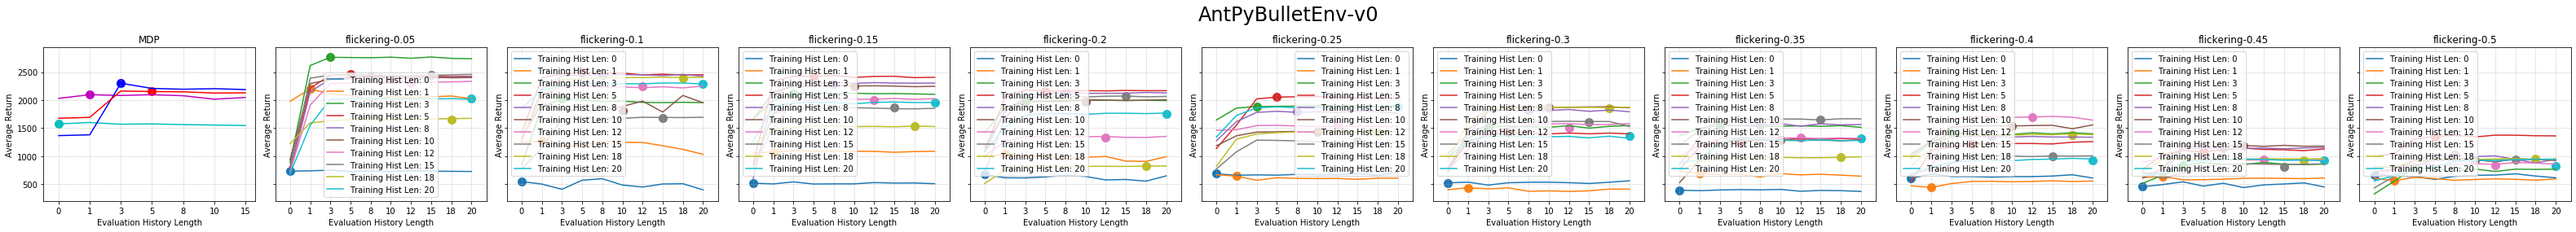

In [48]:
color = {'0':'c', '1':'m', '3':'b', '5':'r', 'DDPG':'k'}

fig, axes = plt.subplots(1, len(original_hist_len)+1, figsize=(4*(len(original_hist_len)+1), 4), sharey=True)
for axes_i, pomdp_type in enumerate(['MDP', 'flickering-0.05', 'flickering-0.1', 'flickering-0.15', 'flickering-0.2', 'flickering-0.25', 'flickering-0.3', 'flickering-0.35', 'flickering-0.4', 'flickering-0.45', 'flickering-0.5']):
    if pomdp_type == 'MDP':
        # Trained on MDP
        for orig_hist_len in lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len_mean.keys():
            axes[axes_i].plot(np.arange(7), lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len_mean[orig_hist_len], 
                              label='Training Hist Len: {}'.format(orig_hist_len), color=color[orig_hist_len])
            if orig_hist_len == '0':
                index = 0
            if orig_hist_len == '1':
                index = 1
            if orig_hist_len == '3':
                index = 2
            if orig_hist_len == '5':
                index = 3
            axes[axes_i].scatter(index, lstm_td3_trained_on_MDP_eval_results_on_diff_hist_len_mean[orig_hist_len][index],
                                 color=color[orig_hist_len], s=100)
        axes[axes_i].set_xticks(np.arange(7))
        axes[axes_i].set_xticklabels(['0', '1', '3', '5', '8', '10', '15'])
        axes[axes_i].set_xlabel('Evaluation History Length')
        axes[axes_i].set_ylabel('Average Return')
        axes[axes_i].set_title('{}'.format(pomdp_type))
        axes[axes_i].grid(linestyle=':')
    else:
        # Trained on POMDP
        for orig_hist_len in eval_results_on_diff_hist_len_mean[pomdp_type].keys():
            axes[axes_i].plot(np.arange(10), eval_results_on_diff_hist_len_mean[pomdp_type][orig_hist_len], 
                              label='Training Hist Len: {}'.format(orig_hist_len))
            if orig_hist_len == '0':
                index = 0
            if orig_hist_len == '1':
                index = 1
            if orig_hist_len == '3':
                index = 2
            if orig_hist_len == '5':
                index = 3
            axes[axes_i].scatter(original_hist_len.index(orig_hist_len), eval_results_on_diff_hist_len_mean[pomdp_type][orig_hist_len][index],
                                 s=100)
        axes[axes_i].set_xticks(np.arange(len(original_hist_len)))
        axes[axes_i].set_xticklabels(original_hist_len)
        axes[axes_i].set_xlabel('Evaluation History Length')
        axes[axes_i].set_ylabel('Average Return')
        if pomdp_type == 'remove_velocity':
            pomdp_type = 'POMDP-RV'
        if pomdp_type == 'flickering':
            pomdp_type = 'POMDP-FLK'
        if pomdp_type == 'random_noise':
            pomdp_type = 'POMDP-RN'
        if pomdp_type == 'random_sensor_missing':
            pomdp_type = 'POMDP-RSM'
        axes[axes_i].set_title('{}'.format(pomdp_type))
        axes[axes_i].grid(linestyle=':')
        axes[axes_i].legend()
plt.tight_layout()
fig.suptitle("{}".format('AntPyBulletEnv-v0'), fontsize=24)
fig.subplots_adjust(top=0.8)
fig.savefig("D:\POMDP_Data\images\evaluation_on_different_history_length.png", bbox_inches='tight')